# Carregamento dos dados

In [33]:
from datetime import datetime
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytz
from scipy import stats 
from scipy.stats import ttest_1samp, ttest_ind
import seaborn as sns
import sys
import tabulate
from tqdm import tqdm

sys.path.append("../")
pd.options.display.max_colwidth = 50
sns.set_style("whitegrid")
plt.style.use('ggplot')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
bin_palette = ['indianred', 'steelblue']
trin_palette = ['#CD5C5C', '#4682B4', '#7C9051']
presentation_figsize = (10, 4)

In [2]:
candidates_file_path = "../data/processed/se_candidates_output_3.csv"
cand_df = pd.read_csv(candidates_file_path, sep=";", encoding="utf-8")

print(cand_df.shape)
# cand_df.info()

(1250, 79)


In [3]:
tweets_file_path = (
    "../data/processed/sp_elected_all_dep_tweets.parquet"
)
tts_df = pd.read_parquet(tweets_file_path)

print(tts_df.shape)
tts_df.info()

(125112, 12)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125112 entries, 0 to 215619
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   id                 125112 non-null  object             
 1   date               125112 non-null  datetime64[ns, UTC]
 2   content            125112 non-null  object             
 3   user               125112 non-null  object             
 4   in_reply_to_user   117868 non-null  object             
 5   conversation_user  125112 non-null  object             
 6   reply_count        125112 non-null  int64              
 7   retweet_count      125112 non-null  int64              
 8   like_count         125112 non-null  int64              
 9   quote_count        125112 non-null  int64              
 10  class_label        125112 non-null  bool               
 11  class_score        125112 non-null  float64            
dtypes: bool(1), datet

## Dataset de Candidatos

In [4]:
# Removendo colunas não utilizadas
cand_cols = [
    "SG_UF",
    "DS_CARGO",
    "SQ_CANDIDATO",
    "NM_URNA_CANDIDATO",
    "NR_PARTIDO",
    "SG_PARTIDO",
    "NM_MUNICIPIO_NASCIMENTO",
    "NR_IDADE_DATA_POSSE",
    "DS_GENERO",
    "DS_GRAU_INSTRUCAO",
    "DS_ESTADO_CIVIL",
    "DS_COR_RACA",
    "DS_OCUPACAO",
    "DS_SIT_TOT_TURNO",
    "ST_REELEICAO",
    "TW_USER",
    "TW_followersCount",
    "TW_friendsCount",
    "TW_statusesCount",
    "TW_favouritesCount",
]
cand_df = cand_df[cand_cols]
print(cand_df.shape)

(1250, 20)


In [5]:
# Filtrando somente os deputados estaduais de SP
cand_df = cand_df[cand_df["SG_UF"] == "SP"]
cand_df = cand_df[(cand_df["DS_CARGO"] == "DEPUTADO ESTADUAL") | (cand_df["DS_CARGO"] == "DEPUTADO FEDERAL")]
cand_df.shape

(595, 20)

In [6]:
# Convertendo usernames para minusculo
cand_df["TW_USER"] = cand_df["TW_USER"].str.lower()

## Juntando os datasets

In [7]:
df = pd.merge(
    tts_df, cand_df, left_on="conversation_user", right_on="TW_USER", how="left"
)
print(df.shape)
df.info()

(125112, 32)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 125112 entries, 0 to 125111
Data columns (total 32 columns):
 #   Column                   Non-Null Count   Dtype              
---  ------                   --------------   -----              
 0   id                       125112 non-null  object             
 1   date                     125112 non-null  datetime64[ns, UTC]
 2   content                  125112 non-null  object             
 3   user                     125112 non-null  object             
 4   in_reply_to_user         117868 non-null  object             
 5   conversation_user        125112 non-null  object             
 6   reply_count              125112 non-null  int64              
 7   retweet_count            125112 non-null  int64              
 8   like_count               125112 non-null  int64              
 9   quote_count              125112 non-null  int64              
 10  class_label              125112 non-null  bool               
 11  

In [8]:
# Adicionando coluna para indicar se o usuário do tweet é um candidato
deputies_usernames = list(df.TW_USER.str.lower().unique())
df["user_is_candidate"] = df["user"].apply(lambda u: u in deputies_usernames)

In [9]:
# Salvando arquivos consolidado
output_path = "../data/processed/"
file_name = 'sp_elected_all_dep_tweets'
output_suffix = "analysis"
file_format = 'parquet'

output_file = f"{output_path}{file_name}-{output_suffix}.{file_format}"
print(output_file)

df.to_parquet(output_file)

../data/processed/sp_elected_all_dep_tweets-analysis.parquet


# Pré-processamento dos Dados

## Funções auxiliares
Vamos definir algumas funções para padronizar e facilitar nossas análises

### Funções de Visualização

Estas funções serão utiizadas para exibir informações e gráficos das colunas que vamos analisar

In [36]:
figsize = (20, 4)
percentiles = [0.05, 0.25, 0.5, 0.75, 0.95]
cand_id_cols = ['TW_USER']

def side_by_side(*dfs):
    """Exibe dataframes lado a lado"""
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

def print_quant_data(df, cols, sort_by):
    """Exibe lado a lado as descrições estatísticas das colunas, e os 10 maiores valores de coluna passada"""
    side_by_side(
        df[cols].describe(percentiles=percentiles),
        df[cand_id_cols + cols].sort_values(sort_by, ascending=False).head(10)
    )

def plot_histograms(df, cols, figsize=figsize):
    """Plota histogramas das colunas passadas lado a lado"""
    fig, ax = plt.subplots(1, len(cols), figsize=figsize)
    for i, col in enumerate(cols):
        sns.histplot(
            df,
            x=col,
            kde=True,
            ax=ax[i],
        ).set(title=f'Histograma de {col}')  

def plot_boxplots(df, cols, figsize=figsize):
    """Plota boxplots das colunas passadas um acima do outro"""
    plt.figure(figsize=figsize)
    sns.boxplot(
        data=df[cols],
        orient='h',
    ).set(title=f'Boxplot de {cols}')
    
def plot_cols(df, cols, figsize=figsize):
    """Plota histogramas e boxplots das colunas passadas"""
    plot_histograms(df, cols, figsize)
    plt.show()
    plot_boxplots(df, cols, figsize)

def plot_corr_heatmap(df, figsize=(12, 4)):
    """Plota um mapa de calor com as correlações entre as colunas passadas"""
    plt.figure(figsize=figsize)
    _corr = df.corr()
    sns.heatmap(
        _corr,
        annot=True, fmt='.2f',
        cmap='PRGn', vmin=-1, vmax=1,
        mask=np.triu(np.ones_like(_corr))
    )
    return _corr
    

### Funções para Testes de Hipóteses

Estas funções serão utilizadas para medirmos se uma diferença entre médias encontrada é estatisticamente significante.

In [37]:
def t_student_test(df, x_col, y_col='class_label', y_val_0=False, y_val_1=True, alpha=0.05, print_results=True):
    """Teste T de Student para comparar a diferença entre as médias de `x_col`, agrupado de acordo com `y_col`"""
    sample_0 = df[df[y_col] == y_val_0][x_col]
    sample_1 = df[df[y_col] == y_val_1][x_col]
    t_stat, p_value = ttest_ind(sample_0, sample_1)

    if p_value <= alpha:
        msg = f'Diferença significativa entre as médias de "{x_col}" agrupadas por "{y_col}": {p_value=}, {t_stat=}'
        insight = {
            'col_1': y_col,
            'col_2': x_col,
            'association': 'Diferença significativa de médias',
            'metrics': {'t_stat': t_stat, "p_value": p_value}, 
            'extra': '',
        }
        insights.append(insight)
    else:
        msg = f'Sem diferença significativa'

    if print_results:
        print(msg, '\n')

    return p_value, t_stat


def t_test_candidate_quali_columns(cand_df, x_cols, y_col, y_val_0, y_val_1, alpha=0.05):
    """Realiza um teste T de Student com cada coluna de `x_cols`, comparando as médias agrupadas por `y_val`"""
    results = []
    for col in x_cols:
        p_value, t_stat = t_student_test(cand_df, x_col=col, y_col=y_col, y_val_0=y_val_0, y_val_1=y_val_1, alpha=alpha, print_results=False)
        result = {
            'col': col,
            'p_value': p_value, 
            't_stat': t_stat,
            'sig_dif': bool(p_value <= alpha),
        }
        results.append(result)
    
    ttest_df = pd.DataFrame(results)
    
    dif_cols = list(ttest_df[ttest_df['sig_dif'] == True].col)
    if dif_cols:
        print(f'Diferença significativa encontrada nas colunas: {dif_cols}\n')
        display(ttest_df[ttest_df['sig_dif'] == True])    
        for i, col in enumerate(dif_cols):
            plt.figure(figsize=(20, 2))
            p = sns.boxplot(
                data=cand_df[[y_col] + dif_cols],
                x=col,
                y=y_col,
                order=[y_val_1, y_val_0],
                palette=trin_palette,
            )
            p.set(
                title=f'Boxplot de {col}', xlabel=None, ylabel=None,
            )
            plt.show()
    else:
        print(f'Nenhuma coluna apresentou diferença significativa para {y_col}')

    return ttest_df

## Aplicação de filtros de Tweets

In [10]:
# Visualizando proporções antes dos filtros
print(df.shape)
df['class_label'].value_counts(normalize=True)

(125112, 33)


False    0.831951
True     0.168049
Name: class_label, dtype: float64

In [11]:
# Criando uma cópia dos dados não filtrados para futura conferência
unfiltered_tweet_df = df
unfiltered_cand_df = cand_df

# Criando variável para armazenar os filtros aplicados e facilitar a comparação de análises
filters = []
filter_template = {
    'col': 'coluna X',
    'condition': '<= Y'
}

### Filtro de tweets por período

Vamos filtrar e analisar somente os tweets do período das eleições de 2022, de 01/09/2022 à 01/11/2022.

In [11]:
# Filtra os tweets pela data
local_tz = pytz.timezone("America/Sao_Paulo")
since = datetime(year=2022, month=9, day=1, tzinfo=local_tz)
until = datetime(year=2022, month=11, day=1, tzinfo=local_tz)
df = df[(df["date"] >= since) & (df["date"] <= until)]

# Grava os filtros utilizados
filters.append({'col': 'date', 'condition': f'>= {since}'})
filters.append({'col': 'date', 'condition': f'<= {until}'})

df.shape

(125112, 33)

### Filtro de tweets por score de classificação

Uma pequena parte dos tweets teve um score baixo durante a classificação de conteúdo ofensivo, indicando uma baixa confiabilidade na classe.
Por isso, vamos filtrar os tweets de score mais baixo.

In [12]:
_perc = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.95]
df['class_score'].describe(percentiles=_perc)

count    125112.000000
mean          0.936455
std           0.102501
min           0.500001
1%            0.537435
5%            0.673406
10%           0.798449
25%           0.936217
50%           0.982340
75%           0.991623
95%           0.997579
max           0.999262
Name: class_score, dtype: float64

In [13]:
# Removendo tweets abaixo do limite
max_score = 0.798449  # 10th percentil
df = df[df['class_score'] > max_score]
filters.append({'col': 'class_score', 'condition': f'> {max_score}'})

# Visualizando como ficou a distribuição após o filtro
print(df.shape)
df['class_score'].describe(percentiles=_perc)

(112600, 33)


count    112600.000000
mean          0.966565
std           0.041901
min           0.798466
1%            0.814669
5%            0.865422
10%           0.905459
25%           0.958557
50%           0.985181
75%           0.992428
95%           0.997685
max           0.999262
Name: class_score, dtype: float64

In [14]:
df['class_label'].value_counts(normalize=True)

False    0.858819
True     0.141181
Name: class_label, dtype: float64

## Extração de Features

Vamos criar algumas features a partir de métricas de atividade, engajamento e conteúdo ofensivo dos tweets, e agrupá-las em listas para facilitar a análise.

### Conteúdo do Tweet

Vamos criar uma nova coluna com o conteúdo do Tweets, mas sem as tags de usuários.

Também iremos criar novas features para o tamanho dos tweets (com e sem tags de usuários).

In [14]:
def extract_account_tags(content):
    """Remove tags de marcação de usuário em um tweet"""
    words = content.split(' ')
    
    def is_not_account_tag(word):
        if len(word) > 0:
            return word[0] != '@'
        return True
        
    words_list = list(filter(is_not_account_tag, words))
    return ' '.join(words_list)

df['filtered_content'] = df['content'].apply(extract_account_tags)

/tmp/ipykernel_14782/1281314365.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filtered_content'] = df['content'].apply(extract_account_tags)


In [15]:
# Adicionando colunas com o tamanho dos tweets
df['content_length'] = df['content'].str.len()
df['filtered_content_length'] = df['filtered_content'].str.len()

/tmp/ipykernel_14782/2126495672.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content_length'] = df['content'].str.len()
/tmp/ipykernel_14782/2126495672.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filtered_content_length'] = df['filtered_content'].str.len()


### Atividade no Twitter (absoluta)

In [16]:
%%time
def get_tweets(user):
    """Total de tweets postados pelo usuário"""
    _df = df[df['user'] == user]
    return _df.shape[0]

def get_threads(user):
    """Total de threads criadas pelo usuário"""
    _df = df[df['user'] == user]
    threads = _df[_df['in_reply_to_user'].isna()]
    return threads.shape[0]

def get_replies(user):
    """Total de replies de outras pessoas recebidas pelo usuário"""
    _df = df[df['in_reply_to_user'] == user]
    _df = _df[_df['user'] != user]
    return _df.shape[0]

def get_thread_tts(user):
    """Total de tweets postados em threads do usuário (incluindo os próprios tweets do usuario)"""
    _df = df[df['conversation_user'] == user]
    return _df.shape[0]

cand_df['TW_tweets'] = cand_df['TW_USER'].apply(get_tweets)
cand_df['TW_threads'] = cand_df['TW_USER'].apply(get_threads)
cand_df['TW_replies'] = cand_df['TW_USER'].apply(get_replies)
cand_df['TW_thread_tts'] = cand_df['TW_USER'].apply(get_thread_tts)

abs_activity_cols = ['TW_tweets', 'TW_threads', 'TW_replies', 'TW_thread_tts',]

cand_df[abs_activity_cols].describe()

CPU times: user 8.42 s, sys: 8.07 ms, total: 8.43 s
Wall time: 8.43 s


TW_tweets  TW_threads    TW_replies  TW_thread_tts
count   595.000000  595.000000    595.000000     595.000000
mean     14.684034   11.221849    174.658824     189.243697
std      77.878268   56.673748   1772.790373    1825.667128
min       0.000000    0.000000      0.000000       0.000000
25%       0.000000    0.000000      0.000000       0.000000
50%       0.000000    0.000000      0.000000       0.000000
75%       0.000000    0.000000      0.000000       0.000000
max    1068.000000  606.000000  34164.000000   34925.000000

In [24]:
cand_df[cand_df['TW_thread_tts'] > 0]['TW_thread_tts'].describe(percentiles=[0.33, 0.67])

count       47.000000
mean      2395.744681
std       6135.048816
min          1.000000
33%        101.260000
50%        146.000000
67%        249.920000
max      34925.000000
Name: TW_thread_tts, dtype: float64

In [25]:
# Como a quantidade de tweets por thread varia bastante entre os candidatos, vamos criar uma categoria para facilitar a visualização destas diferenças
def get_engagement_level(thread_tts):
    low_limit = 101  # 33º percentil
    high_limit = 588  # 66º percentil
    # high_limit = 250 # 66º percentil
    if thread_tts <= low_limit:
        return 'Baixo'
    if thread_tts < high_limit:
        return 'Médio'
    return 'Alto'
    
cand_df['TW_engage_lvl'] = cand_df['TW_thread_tts'].apply(get_engagement_level)
cand_df['TW_engage_lvl'].value_counts()

Baixo    564
Médio     17
Alto      14
Name: TW_engage_lvl, dtype: int64

### Atividade no Twitter (proporcional)

In [26]:
"""
Média de tweets do usuario por threads do usuário. 
Indica o quanto o usuario interage com outros tweets dentro de suas threads
"""
cand_df['TW_avg_thread_user_tts'] = cand_df['TW_tweets'] / cand_df['TW_threads']

"""
Média de tweets do usuario pelo total de tweets em suas threads. 
Indica o quanto do engajamento das threads vem do próprio usuário
"""
cand_df['TW_avg_thread_part'] = cand_df['TW_tweets'] / cand_df['TW_thread_tts']

"""
Média de replies que o usuário recebe para cada tweet postado.
Indica se o usuário recebe um alto engajamento direto
"""
cand_df['TW_avg_replies'] = cand_df['TW_replies'] / cand_df['TW_tweets']

"""
Média do total de tweets por thread do usuário.
Indica o engajamento geral nas threads do usuário
"""
cand_df['TW_avg_thread_tts'] = cand_df['TW_thread_tts'] / cand_df['TW_threads']

prop_activity_cols = ['TW_avg_thread_user_tts', 'TW_avg_thread_part', 'TW_avg_replies', 'TW_avg_thread_tts']
cand_df[prop_activity_cols].describe()

/home/paim/projects/projeto-tera/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/home/paim/projects/projeto-tera/venv/lib/python3.8/site-packages/numpy/lib/function_base.py:4527: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


TW_avg_thread_user_tts  TW_avg_thread_part  TW_avg_replies  \
count               95.000000           95.000000       95.000000   
mean                      inf                 inf        4.038969   
std                       NaN                 NaN       15.065679   
min                  1.000000            0.008565        0.000000   
25%                  1.152651            0.659861        0.000000   
50%                       NaN                 NaN        0.013477   
75%                       NaN                 NaN        0.958333   
max                       inf                 inf      115.452991   

       TW_avg_thread_tts  
count          47.000000  
mean           11.151775  
std            24.993055  
min             1.000000  
25%             1.084136  
50%             1.800000  
75%             4.240351  
max           143.800000

### Tamanho dos Tweets (por usuário)

In [27]:
def get_avg_tt_length(user):
    _df = df[df['user'] == user]
    return _df.content.str.len().mean()

def get_std_tt_length(user):
    _df = df[df['user'] == user]
    return _df.content.str.len().std()

cand_df['TW_avg_tt_length'] = cand_df['TW_USER'].apply(get_avg_tt_length)
cand_df['TW_std_tt_length'] = cand_df['TW_USER'].apply(get_std_tt_length)

tweet_length_cols = ['TW_avg_tt_length', 'TW_std_tt_length',]
cand_df[tweet_length_cols].describe()

TW_avg_tt_length  TW_std_tt_length
count         95.000000         72.000000
mean         131.234068         66.662908
std           66.201933         32.093298
min           16.000000          2.121320
25%           73.504682         38.525965
50%          128.662544         74.662926
75%          174.616625         88.655636
max          280.000000        130.542458

### Composição das threads (por usuário)

In [28]:
%%time
def get_user_thread_tts(user):
    """Total de tweets postados pelo usuário em suas threads"""
    _df = df[
        (df['conversation_user'] == user) & 
        (df['user'] == user)
    ]
    return _df.shape[0]

def get_reply_thread_tts(user):
    """Total de replies ao usuário, em threads do usuário"""
    _df = df[
        (df['conversation_user'] == user) & 
        (df['in_reply_to_user'] == user) & 
        (df['user'] != user)
    ]
    return _df.shape[0]
    
def get_non_reply_thread_tts(user):
    """Total de tweets postados em threads do usuário, mas que não envolvem o usuário diretamente"""
    _df = df[
        (df['conversation_user'] == user) & 
        (df['in_reply_to_user'] != user) & 
        (df['user'] != user)
    ]
    return _df.shape[0]

cand_df['TW_user_thread_tts'] = cand_df['TW_USER'].apply(get_user_thread_tts)
cand_df['TW_reply_thread_tts'] = cand_df['TW_USER'].apply(get_reply_thread_tts)
cand_df['TW_non_reply_thread_tts'] = cand_df['TW_USER'].apply(get_non_reply_thread_tts)

thread_comp_cols = ['TW_user_thread_tts', 'TW_reply_thread_tts', 'TW_non_reply_thread_tts']
cand_df[thread_comp_cols].describe()

TW_user_thread_tts  TW_reply_thread_tts  TW_non_reply_thread_tts
count          595.000000           595.000000               595.000000
mean            14.371429           174.539496                 0.332773
std             77.567749          1772.678843                 3.448542
min              0.000000             0.000000                 0.000000
25%              0.000000             0.000000                 0.000000
50%              0.000000             0.000000                 0.000000
75%              0.000000             0.000000                 0.000000
max           1065.000000         34163.000000                59.000000

### Tweets de Conteúdo Ofensivo (absolutos)

In [29]:
%%time
def get_user_offenses(user):
    """Quantidade de tweets ofensivos postados pelo usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[
        (user_df['class_label'] == True) &
        (user_df['user'] == user)
    ]
    return offenses.shape[0]

def get_reply_offenses(user):
    """Quantidade de replies ofensivas recebidas pelo usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[
        (user_df['class_label'] == True) &
        (user_df['in_reply_to_user'] == user)
    ]
    return offenses.shape[0]

def get_conversation_offenses(user):
    """Quantidade de tweets ofensivos postados em threads do usuário"""
    user_df = df[df['conversation_user'] == user]
    offenses = user_df[user_df['class_label'] == True]
    return offenses.shape[0]

cand_df['TW_user_offs'] = cand_df['TW_USER'].apply(get_user_offenses)
cand_df['TW_reply_offs'] = cand_df['TW_USER'].apply(get_reply_offenses)
cand_df['TW_thread_offs'] = cand_df['TW_USER'].apply(get_conversation_offenses)

abs_offense_cols = ['TW_user_offs', 'TW_reply_offs', 'TW_thread_offs']
cand_df[abs_offense_cols].describe()

CPU times: user 6.58 s, sys: 0 ns, total: 6.58 s
Wall time: 6.58 s


TW_user_offs  TW_reply_offs  TW_thread_offs
count    595.000000     595.000000      595.000000
mean       0.897479      25.813445       26.717647
std        6.672819     283.043501      288.515434
min        0.000000       0.000000        0.000000
25%        0.000000       0.000000        0.000000
50%        0.000000       0.000000        0.000000
75%        0.000000       0.000000        0.000000
max      104.000000    5763.000000     5867.000000

### Tweets de Conteúdo Ofensivo (proporcionais)

In [30]:
%%time
"""Taxa de tweets ofensivos por thread do usuário"""
cand_df['TW_offs_per_thread'] = cand_df['TW_thread_offs'] / cand_df['TW_threads']

"""Taxa de tweets ofensivos pelo total de tweets postados pelo usuário"""
cand_df['TW_user_offs_rate'] = cand_df['TW_user_offs'] / cand_df['TW_tweets']

"""Taxa de replies ofensivas pelo total de replies recebidas pelo usuário"""
cand_df['TW_reply_offs_rate'] = cand_df['TW_reply_offs'] / cand_df['TW_replies']

"""Taxa de tweets ofensivos pelo total de tweets em threads do usuário"""
cand_df['TW_thread_offs_rate'] = cand_df['TW_thread_offs'] / cand_df['TW_thread_tts']

prop_offense_cols = ['TW_offs_per_thread', 'TW_user_offs_rate', 'TW_reply_offs_rate', 'TW_thread_offs_rate']
cand_df[prop_offense_cols].describe()

CPU times: user 0 ns, sys: 9.61 ms, total: 9.61 ms
Wall time: 9.36 ms


TW_offs_per_thread  TW_user_offs_rate  TW_reply_offs_rate  \
count           47.000000          95.000000           53.000000   
mean             1.428577           0.025634                 inf   
std              3.402570           0.050135                 NaN   
min              0.000000           0.000000            0.000000   
25%              0.033355           0.000000            0.000000   
50%              0.095506           0.000000            0.064045   
75%              0.457875           0.022294            0.168686   
max             16.631579           0.256944                 inf   

       TW_thread_offs_rate  
count            47.000000  
mean              0.072371  
std               0.060174  
min               0.000000  
25%               0.021071  
50%               0.063830  
75%               0.121062  
max               0.212999

### Exportando arquivos dos candidatos com as métricas

In [31]:
# Salvando arquivos consolidado
output_path = "../data/processed/"
file_name = 'sp_elected_est_fed_dep_candidates'
output_suffix = "analysis_metrics"
file_format = 'parquet'

output_file = f"{output_path}{file_name}-{output_suffix}.{file_format}"
print(output_file)

cand_df.to_parquet(output_file)

../data/processed/sp_elected_est_fed_dep_candidates-analysis_metrics.parquet


## Pré visualização dos dados por candidato

In [39]:
raw_cand_df = cand_df

[Text(0.5, 1.0, 'Histograma de score das classificações'), Text(0.5, 0, '')]

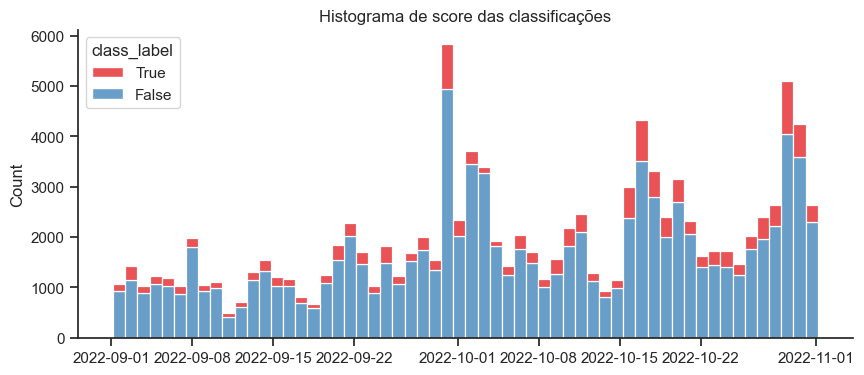

In [34]:
# Distribuição dos tweets pelo tempo
fig, ax = plt.subplots(1, 1, figsize=presentation_figsize)

sns.histplot(
    df,
    x='date',
    hue='class_label',
    hue_order=[True, False],
    palette=trin_palette,
    multiple='stack',
).set(title="Histograma de score das classificações", xlabel=None)

## Aplicação de filtros de candidato

### Filtro de candidatos com scraping incompleto

Houve erros no scraping das respostas de alguns candidatos a deputado federal. Como não é mais possível fazer scraping no Twitter para completar os dados, vamos removê-los da análise.

In [44]:
# Alguns candidatos tiveram erro no scraping de suas replies. Vamos removê-los para que não influenciem nas métricas
deps_with_scraping_error = [
    'julianapt',
    'adriventurasp',
    'rosangelamorosp',
    'carlossampaio_',
    'anaperugini',
]

cand_df = cand_df[~cand_df['TW_USER'].isin(deps_with_scraping_error)]
filters.append({'col': 'TW_USER', 'condition': f'not in {deps_with_scraping_error}'})
df.shape

(112600, 36)

### Tratamento de Outliers

#### Removendo candidatos pouco ativos

Alguns candidatos foram muito pouco ativos no Twitter, somando uma quantidade muito baixa de tweets.

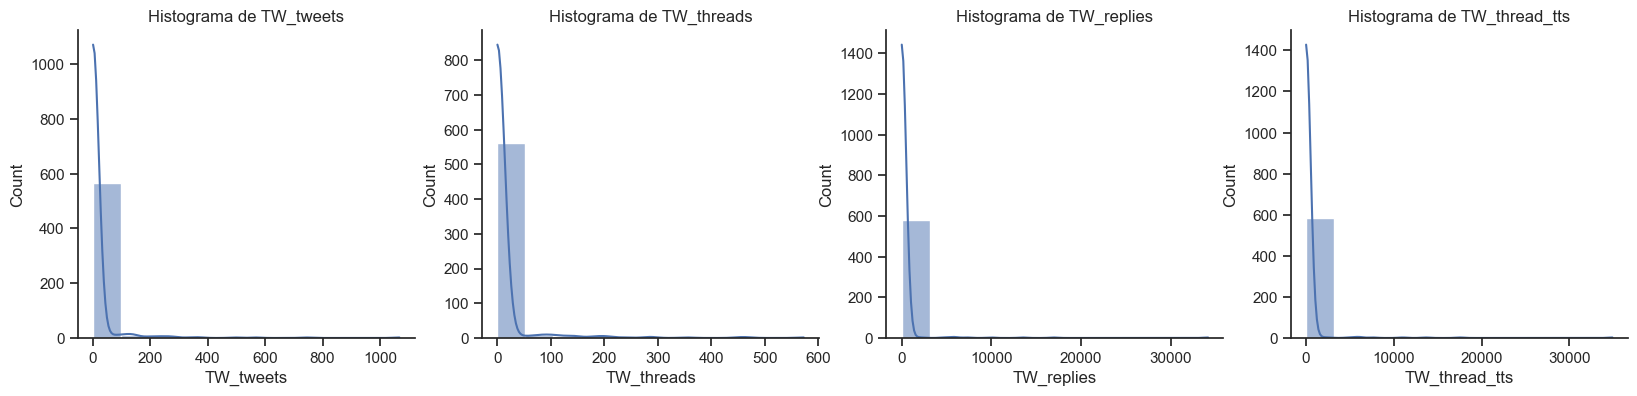

In [45]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))
for i, col in enumerate(abs_activity_cols):
    sns.histplot(
        cand_df,
        x=col,
        kde=True,
        ax=ax[i],
    ).set(title=f'Histograma de {col}')  

In [46]:
cand_df[['TW_tweets', 'TW_threads', 'TW_replies', 'TW_thread_tts']].describe(
    percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
)

TW_tweets  TW_threads    TW_replies  TW_thread_tts
count   590.000000  590.000000    590.000000     590.000000
mean     12.547458    9.242373    176.052542     188.493220
std      72.021811   49.032755   1780.233839    1833.272359
min       0.000000    0.000000      0.000000       0.000000
1%        0.000000    0.000000      0.000000       0.000000
5%        0.000000    0.000000      0.000000       0.000000
10%       0.000000    0.000000      0.000000       0.000000
25%       0.000000    0.000000      0.000000       0.000000
50%       0.000000    0.000000      0.000000       0.000000
75%       0.000000    0.000000      0.000000       0.000000
90%       2.000000    0.000000      0.000000       0.000000
95%      36.400000   27.500000      3.550000      88.400000
99%     293.940000  244.060000   5729.450000    5969.750000
max    1068.000000  573.000000  34164.000000   34925.000000

In [47]:
# Vamos fitlrar somente os candidatos com mais do que uma thread e uma reply
min_threads = 1
cand_df = cand_df[cand_df['TW_threads'] > min_threads]
filters.append({'col': 'TW_threads', 'condition': f'> {min_threads}'})

min_replies = 1
cand_df = cand_df[cand_df['TW_replies'] > min_replies]
filters.append({'col': 'TW_replies', 'condition': f'> {min_replies}'})

print(cand_df.shape)

(28, 41)


TW_tweets  TW_threads    TW_replies  TW_thread_tts
count    28.000000   28.000000     28.000000      28.000000
mean    209.714286  151.178571   3708.285714    3922.214286
std     250.879912  157.026786   7453.375660    7624.430924
min       5.000000    4.000000      2.000000       7.000000
1%        5.270000    4.540000      2.540000       7.810000
5%        6.000000    6.000000      5.400000      11.400000
10%       8.800000    8.800000      8.000000      16.800000
25%      37.000000   21.750000     42.500000      98.000000
50%     112.000000   89.000000    144.000000     235.000000
75%     276.750000  214.250000   4960.250000    5188.500000
90%     514.900000  383.700000  10965.600000   11796.200000
95%     679.100000  461.450000  15747.250000   16187.550000
99%     979.440000  544.110000  29517.030000   30233.210000
max    1068.000000  573.000000  34164.000000   34925.000000

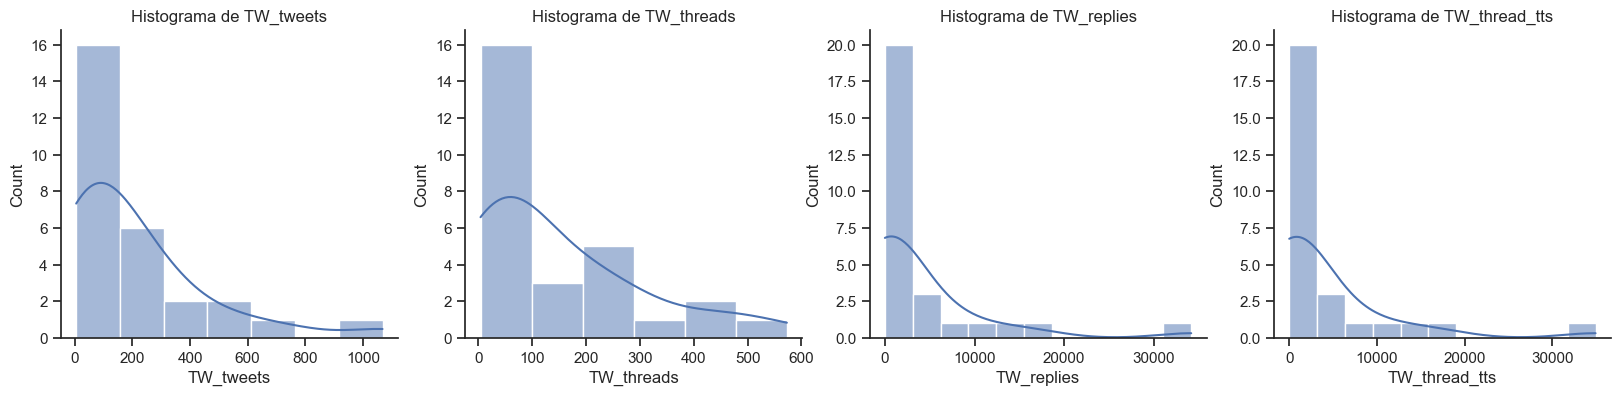

In [48]:
# Visualizando como ficou a distribuição após o filtro
display(cand_df[['TW_tweets', 'TW_threads', 'TW_replies', 'TW_thread_tts']].describe(
    percentiles=[0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]
))

fig, ax = plt.subplots(1, 4, figsize=(20,4))
for i, col in enumerate(abs_activity_cols):
    sns.histplot(
        cand_df,
        x=col,
        kde=True,
        ax=ax[i],
    ).set(title=f'Histograma de {col}')  

#### Removendo candidatos com engajamento excessivo

Por outro lado, alguns candidatos receberam um engajamento muito maior, e também podem distorcer nossas métricas. Vamos filtrá-los para que não impactem nas análise.

Por ser a coluna com maior variação, vamos centrar na `TW_thread_tts`.

In [49]:
# Removendo candidatos acima do limite
max_thread_tts = 7398.4  # 90th percentil
cand_df = cand_df[cand_df['TW_thread_tts'] <= max_thread_tts]

filters.append({'col': 'TW_thread_tts', 'condition': f'<= {max_thread_tts}'})

# Visualizando como ficou a distribuição após o filtro
print(cand_df.shape)
cand_df['TW_thread_tts'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99])

(23, 41)


count      23.000000
mean     1090.000000
std      1902.835014
min         7.000000
1%          7.660000
25%        88.000000
50%       179.000000
75%       996.000000
90%      4447.400000
95%      5863.200000
99%      5986.500000
max      5992.000000
Name: TW_thread_tts, dtype: float64

In [50]:
filters

[{'col': 'class_score', 'condition': '> 0.798449'},
 {'col': 'TW_USER',
  'condition': "not in ['julianapt', 'adriventurasp', 'rosangelamorosp', 'carlossampaio_', 'anaperugini']"},
 {'col': 'TW_threads', 'condition': '> 1'},
 {'col': 'TW_replies', 'condition': '> 1'},
 {'col': 'TW_thread_tts', 'condition': '<= 7398.4'}]

In [51]:
cand_df[cand_df['TW_thread_tts'] > 0]['TW_thread_tts'].describe(percentiles=[0.33, 0.67])

count      23.000000
mean     1090.000000
std      1902.835014
min         7.000000
33%       101.820000
50%       179.000000
67%       587.620000
max      5992.000000
Name: TW_thread_tts, dtype: float64

In [52]:
# Recalculando a categoria de nível de engajamento
def get_engagement_level(thread_tts):
    low_limit = 101  # 33º percentil
    high_limit = 588  # 66º percentil
    if thread_tts <= low_limit:
        return 'Baixo'
    if thread_tts < high_limit:
        return 'Médio'
    return 'Alto'
    
cand_df['TW_engage_lvl'] = cand_df['TW_thread_tts'].apply(get_engagement_level)
cand_df['TW_engage_lvl'].value_counts()

Alto     8
Baixo    8
Médio    7
Name: TW_engage_lvl, dtype: int64

In [ ]:
# Comparando distribuições antes de depois da remooção de outliers
fig, ax = plt.subplots(2, 1, figsize=figsize)
sns.boxplot(
    raw_cand_df[['TW_thread_tts']],
    orient='h',
    color='steelblue',
    ax=ax[0],
).set(yticklabels=[], ylabel='Com outliers')
sns.boxplot(
    cand_df[['TW_thread_tts']],
    orient='h',
    color='steelblue',
    ax=ax[1],
).set(yticklabels=[], ylabel='Sem outliers')

# EDA

## Glossário

- **tweet**: qualquer postagem feita no Twitter
- **reply**: tweets feitos em resposta direta a outro *tweet*
- **thread** (conversa): uma sequencia de *tweets*, composta pelo *tweet* inicial, *replies* feitas a esse *tweet*, *replies* feitas a essas *replies*, e assim sucessivamente

In [53]:
# Vamos definir uma variável para agrupar os insights e facilitar a análise final
insights = []
insight_template = {
    'col_1': 'coluna 1',
    'col_2': 'coluna 2',
    'association': 'associação entre colunas 1 e 2',
    'metrics': 'p_value=0.01',
    'extra': None, 
}

In [54]:
pd.options.display.max_colwidth = 300
df[df['class_label'] == True].sample(10)[['id', 'content']]

id  \
97118  1581802671971139584   
48940  1586872445620871171   
76123  1582204104667189248   
45423  1573356242390884354   
89460  1586497199063859200   
8924   1575608215256985603   
60771  1582422515774681089   
52458  1581625309186564098   
8905   1575616031699369984   
88768  1586206708011094016   

                                                                                                                                                                                                                                                                                      content  
97118                                                                                                                                                                                                                                                 @samiabomfim Pensei o mesmo! Um imbecil  
48940                                                                                                       @luizaerundina @Leonek_ Senhora Erundina, o pesadelo é saber que existem milhares de não pessoas, canalhas, estatisticamente quase a metade dos que habitam essa terra! Assusta!!  
76123                                                                                                                                                                                                                                                       @rsallesmma Traficante de madeira  
45423                                                                                                                                                                                                                                                       A culpa é da Marvada da Cachaça!!  
89460                                                                                                                                                                                                                     @samiabomfim Esse daí não é o chefe do mensalão do @LulaOficial ???  
8924                                                                                                                                                                                                                                                    @andreawerner_ Que escro...! Nojenta!  
60771  @marcofeliciano Os assaltos praticados pela esquerda, em 14 anos de governos, geraram a maioria dos problemas de hoje na Saúde, Educação, Infraestrutura, Segurança e tantos outros males no Brasil! \nO Brasil não merece a volta do mentiroso ‘L’adrão e da quadrilha dos corruPTos!  
52458                                                                                                                                                                                                                                     @luizaerundina HOMEM ADULTO NÃO, UM VELHO ASQUEROSO  
8905                                                                                                                                                                      @andreawerner_ Essa mulher não é louca, não é insana, ela é sagaz e sabe muito bem a corja que ela parte e defende.  
88768                                                                                                                                                                                                              @samiabomfim Não venceu ,apesar do Bonner fazer tudo para ajudar o ladrão.

In [55]:
# Checando alguns exemplos de tweets com conteúdo ofensivo
df[df['class_label'] == True].sample(10)['content'].values

array(['@samiabomfim político é assim mesmo, em época de eleições, comer pastel e hotdog é o padrão mais rasteiro que existe, o povo já sabe identificar os oportunistas.',
       '@luizaerundina O LulaLadrão vai ser preso novamente.',
       '@rsallesmma @GuilhermeBoulos todo, todo comunista é mentiroso sem o menor pudor, nem uma manchina de vermelhinho aparece na face.',
       '@leosiqueirabr @LeeonardoS7 E eu ouso dizer que a mornarquia britânica não custa 13bi de Libras.',
       '@carteiroreaca @tarcisiogdf Descarado, só ao debate pra atacar o presidente, capacho do 🦑',
       '@rsallesmma @Zambelli2210 Não acredito que a Zambeli faria isso,  parece mais uma desonestidade dessa turma da esquerda , querem dividir a direita e jogar um contra o outro,  com certeza os dois serão eleitos.',
       '@luizaerundina O PT É  A TREVA!🤮🤮🤮🤮🤮',
       '@samiabomfim Diabo correu do padre😂😂😂 https://t.co/sQykcoHuOM',
       '@pauloteixeira13 @DilmaResiste Grande TRAIDOR!\nBem FEITO.',
       '@c

## Análise dos Dados

### Distribuição de classe e score de conteúdo ofensivo

In [56]:
df.shape

(112600, 36)

False    0.858819
True     0.141181
Name: class_label, dtype: float64
False    96703
True     15897
Name: class_label, dtype: int64


<Axes: xlabel='count', ylabel='class_label'>

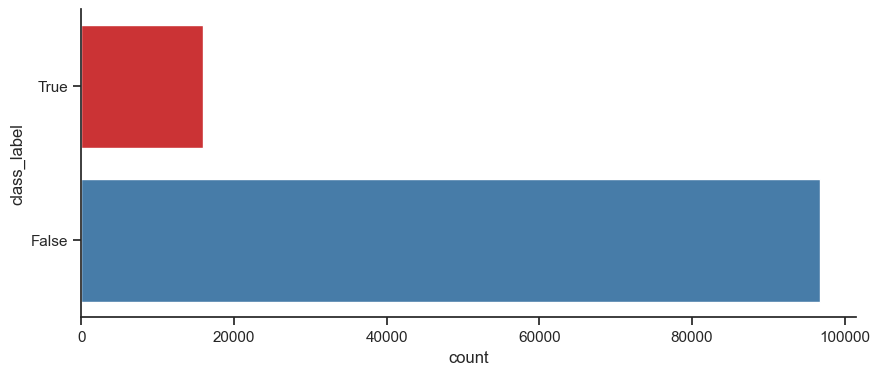

In [58]:
print(df['class_label'].value_counts(normalize=True))
print(df['class_label'].value_counts())
plt.figure(figsize=presentation_figsize)
sns.countplot(
    data=df,
    y='class_label',
    palette=trin_palette,
    orient='h',
    order=[True, False]
)

In [60]:
# Avaliando a distribuição e score de ofensas no dataset
print(df['class_label'].value_counts(normalize=True), '\n')
print(df['class_score'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9]))

False    0.858819
True     0.141181
Name: class_label, dtype: float64 

count    112600.000000
mean          0.966565
std           0.041901
min           0.798466
10%           0.905459
25%           0.958557
50%           0.985181
75%           0.992428
90%           0.996640
max           0.999262
Name: class_score, dtype: float64


/tmp/ipykernel_14782/3142256327.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(


[Text(0.5, 1.0, 'Histograma de score das classificações'), Text(0.5, 0, '')]

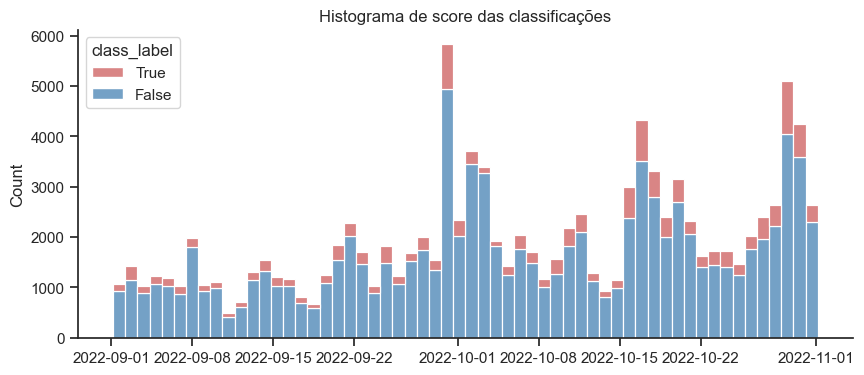

In [70]:
# PRESENTATION
# Distribuição dos tweets pelo tempo
fig, ax = plt.subplots(1, 1, figsize=presentation_figsize)

sns.histplot(
    df,
    x='date',
    hue='class_label',
    hue_order=[True, False],
    palette=trin_palette,
    multiple='stack',
    # kde=True,
    # ax=ax[0],
).set(title="Histograma de score das classificações", xlabel=None)

/tmp/ipykernel_14782/668978864.py:5: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(


[Text(0.5, 1.0, 'Score das classificações'), Text(0, 0.5, '')]

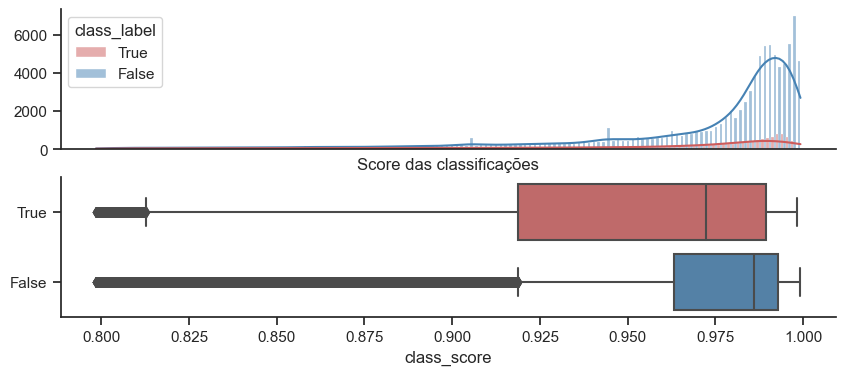

In [71]:
# DEFINIDO - class_score, class_label
# PRESENTATION
fig, ax = plt.subplots(2, 1, figsize=presentation_figsize)

sns.histplot(
    df,
    x='class_score',
    hue='class_label',
    hue_order=[True, False],
    palette=trin_palette,
    multiple='dodge',
    kde=True,
    ax=ax[0],
).set(ylabel=None, xlabel=None, xticks=[])

sns.boxplot(
    data=df,
    x='class_score',
    y=df['class_label'].astype(str),
    palette=trin_palette,
    order=['True', 'False'],
    ax=ax[1],
).set(title="Score das classificações", ylabel=None,)

Parece haver uma diferença na distribuição de `class_score` entre as duas classes. Vamos testar se ela é significante.

In [72]:
t_student_test(df, x_col='class_score')

Diferença significativa entre as médias de "class_score" agrupadas por "class_label": p_value=0.0, t_stat=60.85698002365709 



(0.0, 60.85698002365709)

### Tamanho dos tweets de acordo com a classe

/tmp/ipykernel_14782/943976567.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(


<Axes: xlabel='content_length', ylabel='class_label'>

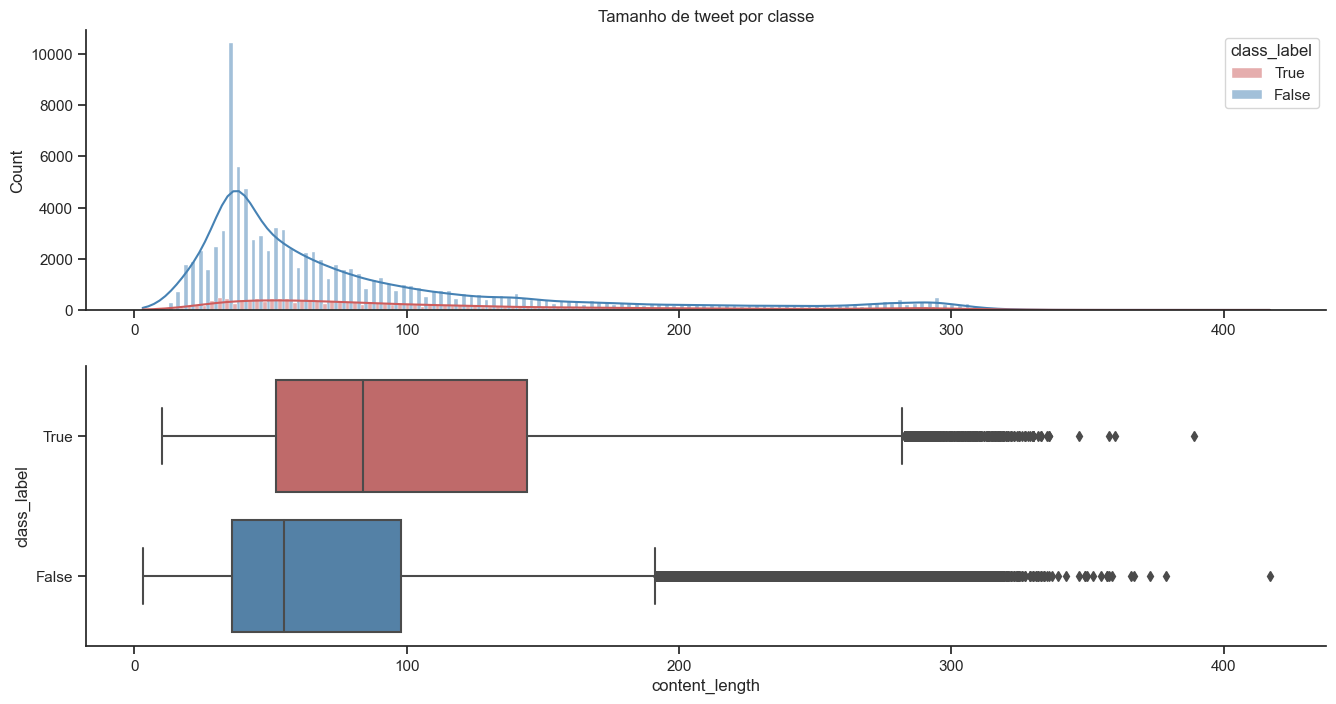

In [73]:
# Checando a distribuição do tamanho dos tweets
fig, ax = plt.subplots(2, 1, figsize=(16, 8))

sns.histplot(
    df,
    x='content_length',
    hue='class_label',
    multiple='dodge',
    kde=True,
    palette=trin_palette,
    hue_order=[True, False],
    ax=ax[0],
).set(title="Tamanho de tweet por classe", xlabel=None)

sns.boxplot(
    data=df,
    x='content_length',
    y=df['class_label'].astype(str),
    palette=trin_palette,
    order=['True', 'False'],
    ax=ax[1],
)

# sns.boxplot(
#     data=df,
#     x='filtered_content_length',
#     y=df['class_label'].astype(str),
#     palette=trin_palette,
#     order=['True', 'False'],
#     ax=ax[1][0],
# ).set(title="Boxplot de filtered_content_length por classe")

# sns.histplot(
#     df,
#     x='filtered_content_length',
#     hue='class_label',
#     multiple='dodge',
#     kde=True,
#     palette=trin_palette,
#     hue_order=[True, False],
#     ax=ax[1][1],
# ).set(title="Histograma de filtered_content_length por classe")


In [74]:
# Testando se as diferenças de tamanho são significantes
t_student_test(df, x_col='content_length', y_val_0=False, y_val_1=True)
t_student_test(df, x_col='filtered_content_length', y_val_0=False, y_val_1=True)

Diferença significativa entre as médias de "content_length" agrupadas por "class_label": p_value=0.0, t_stat=-46.38571534330981 

Diferença significativa entre as médias de "filtered_content_length" agrupadas por "class_label": p_value=0.0, t_stat=-46.48067411806944 



(0.0, -46.48067411806944)

### Proporção entre tweets de candidatos e não-candidatos

In [75]:
# Avaliando a proporção de tweets entre candidatos e não-candidatos
print(df["user_is_candidate"].value_counts(normalize=True))

False    0.923694
True     0.076306
Name: user_is_candidate, dtype: float64


In [76]:
df.groupby('user_is_candidate')['class_label'].value_counts(normalize=True)

user_is_candidate  class_label
False              False          0.852300
                   True           0.147700
True               False          0.937733
                   True           0.062267
Name: class_label, dtype: float64

<Axes: xlabel='count', ylabel='user_is_candidate'>

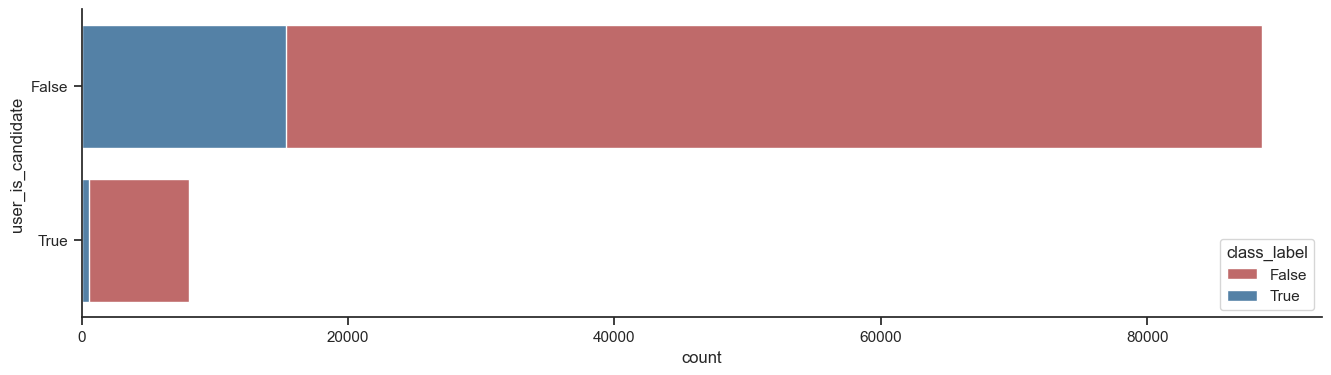

In [77]:
plt.figure(figsize=(16, 4))
sns.countplot(
    df,
    y='user_is_candidate',
    hue='class_label',
    dodge=False,
    orient='v',
    # saturation=0.7,
    palette=trin_palette,
    # order=[True, False],
    # hue_order=[True, False],
)

Aproximadamente 17% dos tweets analisados receberam a flag de conteúdo ofensivo

### Tweets de conteúdo repetido

In [78]:
# Checando tweets com conteúdo igual, que acontece principalmente em dois cenários:
# - Vários usuários postando exatamente a mesma mensagem para um candidato
# - Um usuário postando exatamente a mesma mensagem para vários candidatos diferentes
repeated_tweets = (df['filtered_content'].value_counts() > 1).loc[lambda x: x == True].index
repeated_tweets = df[df['filtered_content'].isin(repeated_tweets)]
indexes = repeated_tweets['filtered_content'].sort_values().index
repeated_tweets = repeated_tweets.reindex(indexes)

print(f'Tweets de conteúdo repetido: {repeated_tweets.shape[0]}')
print(f'Proporção de tweets repetidos: {repeated_tweets.shape[0] / df.shape[0]}')

print(f'\nProporção de conteúdo ofensivo nos tweets repetidos: \n{repeated_tweets["class_label"].value_counts(normalize=True)}')

Tweets de conteúdo repetido: 11083
Proporção de tweets repetidos: 0.09842806394316163

Proporção de conteúdo ofensivo nos tweets repetidos: 
False    0.878914
True     0.121086
Name: class_label, dtype: float64


A proporção de tweets com conteúdo repetido e ofensivo é semelhante à encontrada no total de tweets

### Métricas das contas

In [79]:
df.shape

(112600, 36)

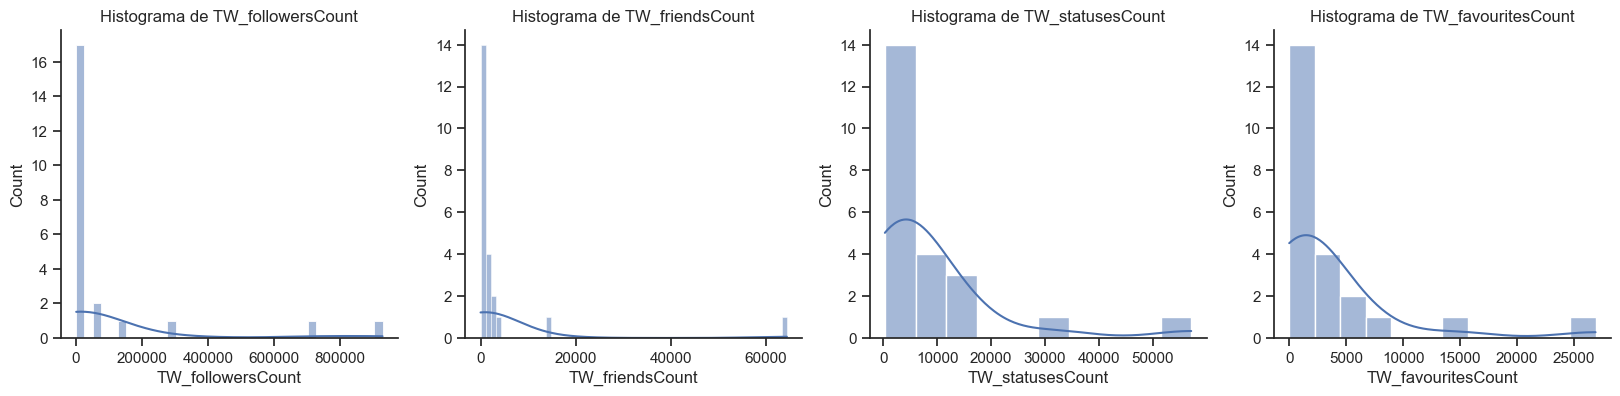

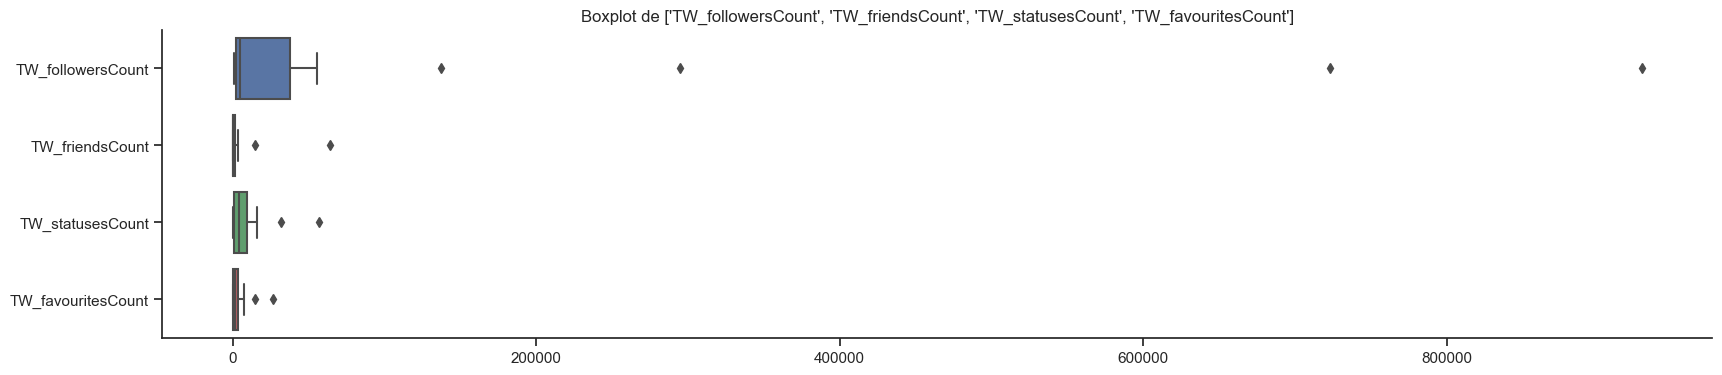

In [80]:
# Métricas gerais das contas Twitter, extraídas durante o scraping
account_metric_cols = ['TW_followersCount', "TW_friendsCount", "TW_statusesCount", "TW_favouritesCount",]

print_quant_data(cand_df, account_metric_cols, 'TW_followersCount')
plot_cols(cand_df, account_metric_cols)

### Atividade no Twitter (números absolutos)

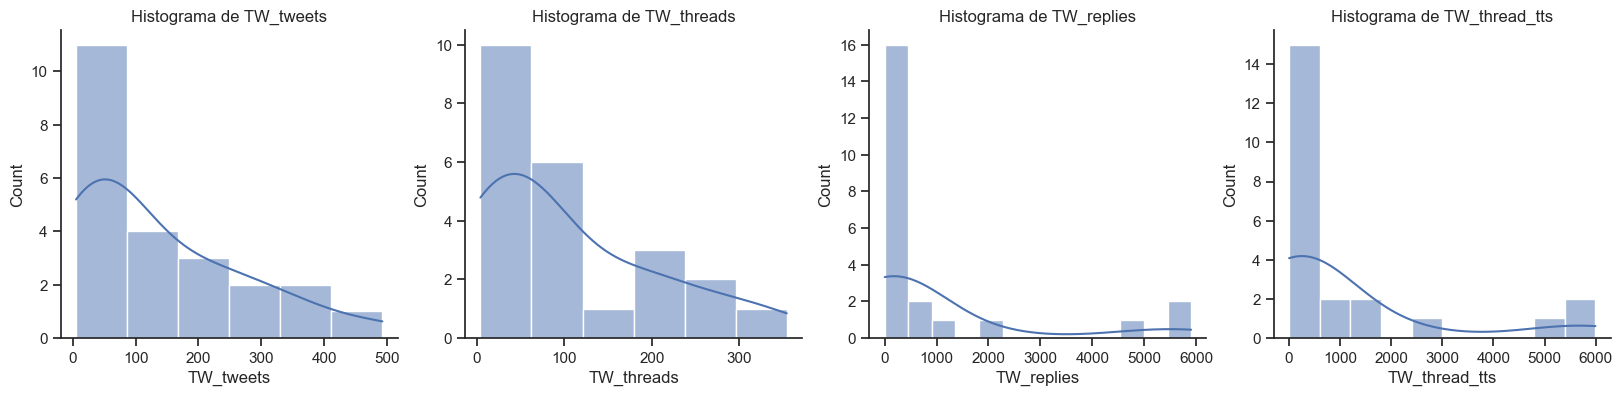

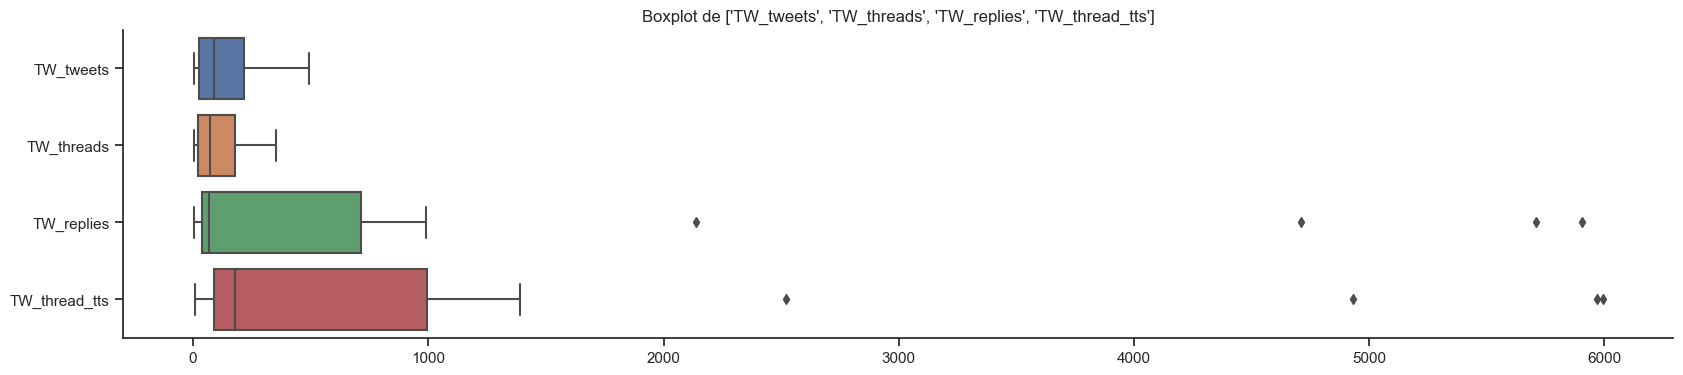

In [81]:
print_quant_data(cand_df, abs_activity_cols, 'TW_thread_tts')

side_by_side(
    cand_df[['TW_USER', 'TW_tweets']].sort_values('TW_tweets', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_threads']].sort_values('TW_threads', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_replies']].sort_values('TW_replies', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_thread_tts']].sort_values('TW_thread_tts', ascending=False).head(5),
)

plot_cols(cand_df, abs_activity_cols)

Podemos perceber alguns outliers nas quatro métricas, mas as diferenças são bem mais acentuadas em `TW_replies` e `TW_thread_tts`. Isso nos mostra que o engajamento recebido pelos usuarios pode ser bastante desigual e irregular, e é provável que isso impacte nas métricas de conteúdo ofensivo.

Além disso, a coluna `TW_replies` tem valores muito próximos de `TW_thread_tts`, indicando que as threads sejam pouco profundas (ou seja, possuem poucos níveis de replies) e que a grande maioria dos tweets são respostas diretas à quem iniciou as threads.

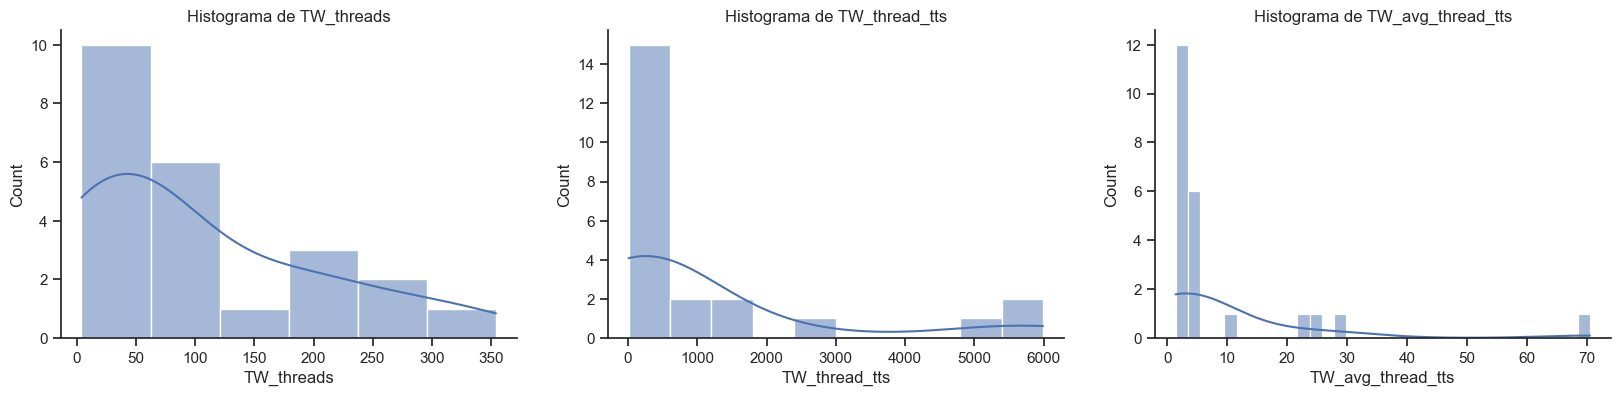

In [82]:
plot_histograms(cand_df, ['TW_threads', 'TW_thread_tts', 'TW_avg_thread_tts'], figsize=(20,4))

### Distribuição de tamanho dos Tweets (por usuário)

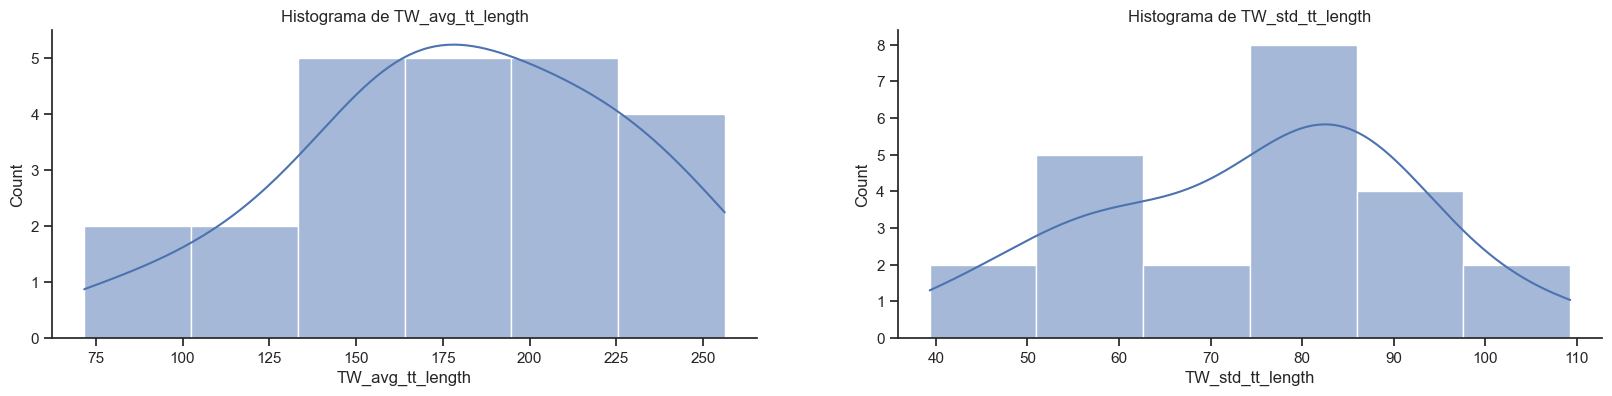

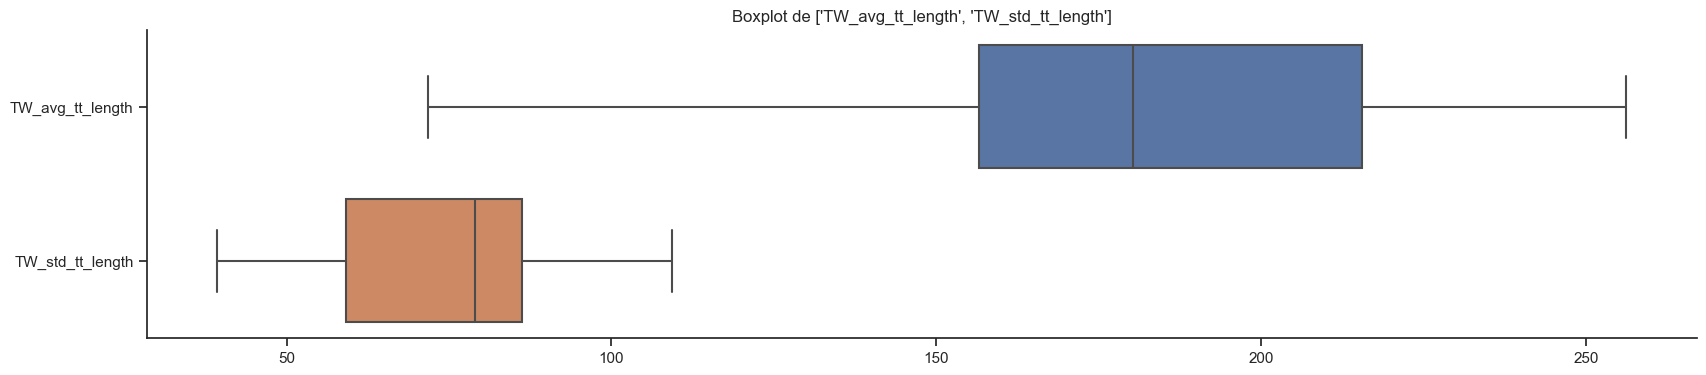

In [83]:
print_quant_data(cand_df, tweet_length_cols, 'TW_avg_tt_length')
plot_cols(cand_df, tweet_length_cols)

### Composição das threads (por usuário)

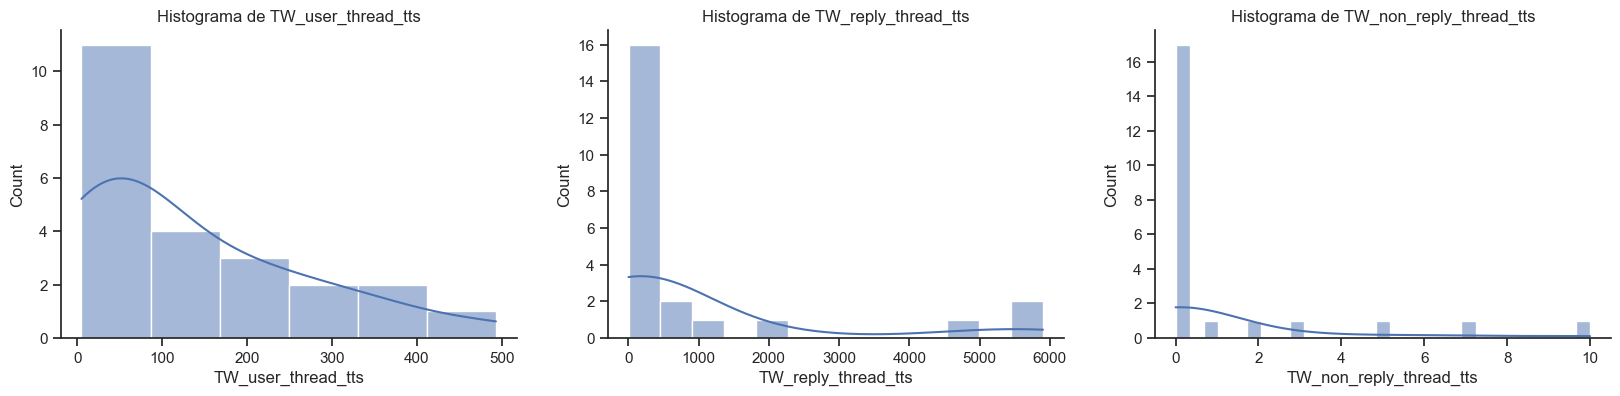

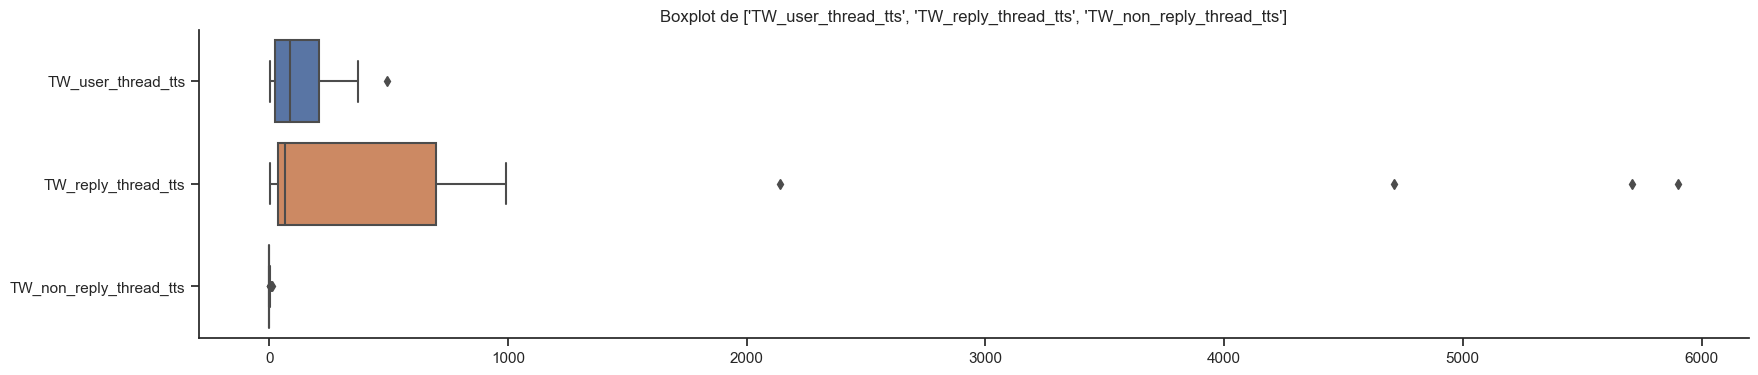

In [84]:
print_quant_data(cand_df, thread_comp_cols, 'TW_non_reply_thread_tts')

side_by_side(
    cand_df[['TW_USER', 'TW_user_thread_tts']].sort_values('TW_user_thread_tts', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_reply_thread_tts']].sort_values('TW_reply_thread_tts', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_non_reply_thread_tts']].sort_values('TW_non_reply_thread_tts', ascending=False).head(5),
)

plot_cols(cand_df, thread_comp_cols)

In [85]:
# Vamos checar a proporção de tipo de tweet em nosso dataset
means_sum = sum(cand_df[thread_comp_cols].mean())
cand_df[thread_comp_cols].mean() / means_sum

TW_user_thread_tts         0.122976
TW_reply_thread_tts        0.875907
TW_non_reply_thread_tts    0.001117
dtype: float64

Estes números confirmam que a grande maioria dos tweets são respostas diretas aos criadores das threads, e portanto podemos ignorar os tweets que não envolvem os criadores de threads: 
- **~7%:** tweets dos criadores das threads
- **~92%:** replies diretas aos criadores das threads
- **~0.01%:** replies que não envolvem os criadores das threads

Antes de seguir com as análises de conteúdo ofensivo, vamos calcular também algumas taxas relacionadas ao engajamento

### Atividade no Twitter (proporção)

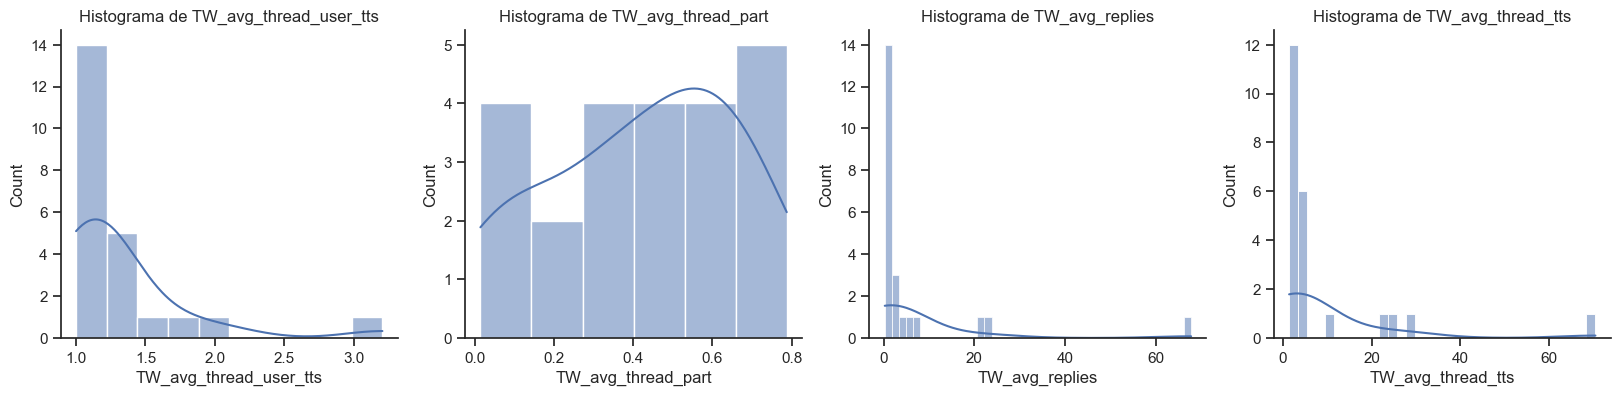

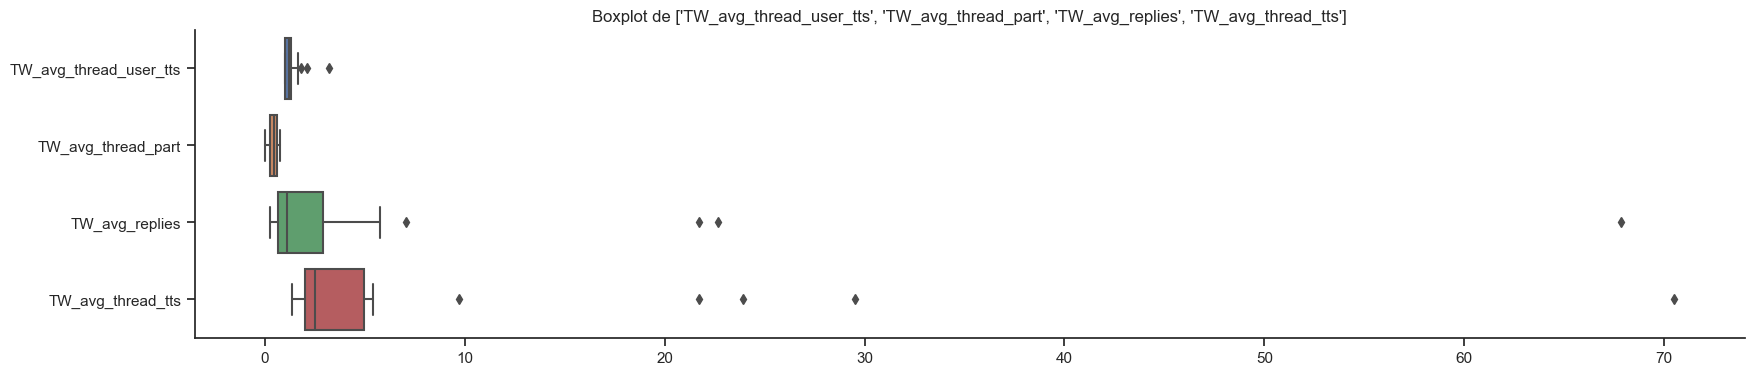

In [86]:
print_quant_data(cand_df, prop_activity_cols, 'TW_avg_thread_tts')
side_by_side(
    cand_df[['TW_USER', 'TW_avg_thread_user_tts']].sort_values('TW_avg_thread_user_tts', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_avg_thread_part']].sort_values('TW_avg_thread_part', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_avg_replies']].sort_values('TW_avg_replies', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_avg_thread_tts']].sort_values('TW_avg_thread_tts', ascending=False).head(5),
)
plot_cols(cand_df, prop_activity_cols)

Avaliando tanto `TW_avg_thread_user_tts`, podemos concluir que os usuários analisados não participam muito das discussões em suas threads

... 

INCOMPLETO

### Tweets de Conteúdo Ofensivo (números absolutos)

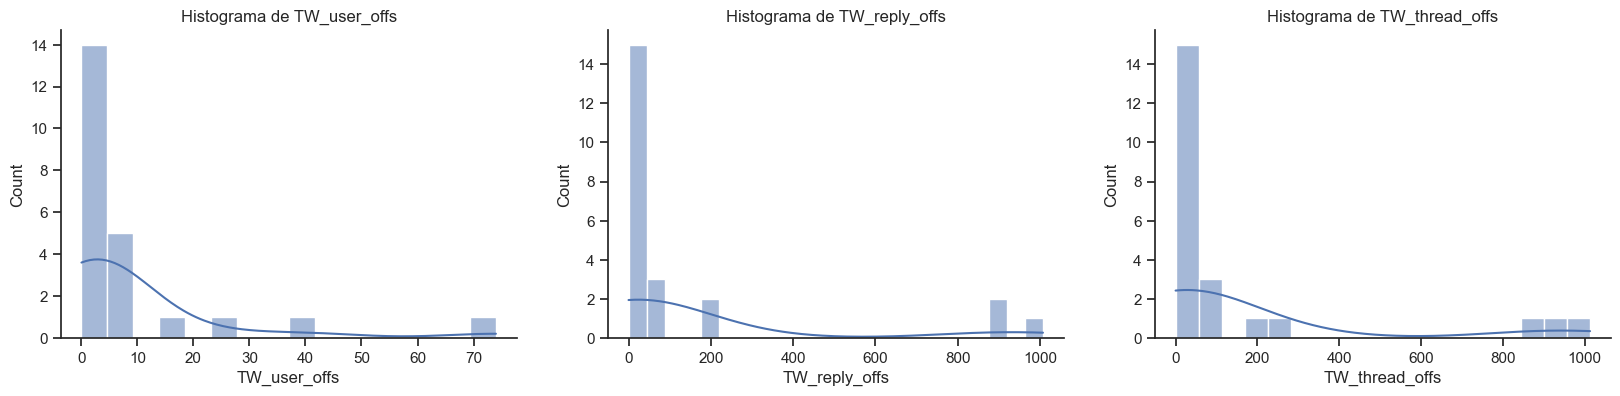

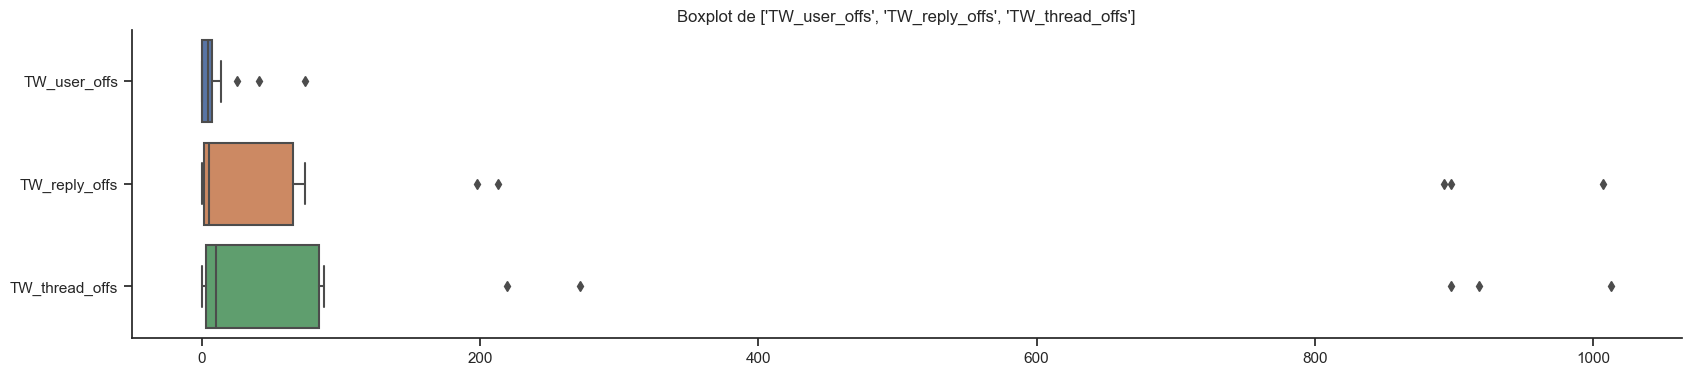

In [87]:
print_quant_data(cand_df, abs_offense_cols, 'TW_thread_offs')

side_by_side(
    cand_df[['TW_USER', 'TW_user_offs']].sort_values('TW_user_offs', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_reply_offs']].sort_values('TW_reply_offs', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_thread_offs']].sort_values('TW_thread_offs', ascending=False).head(5),
)

plot_cols(cand_df, abs_offense_cols)

Ao analisar a quantidade de conteudo ofensivo encontramos outliers de forma semelhante aos da análise anterior, o que pode apontar uma forte (e já esperada) correlação entre quantidade de tweets e de conteúdo ofensivo.

Vamos agora avaliar esta proporção.

### Tweets de Conteúdo Ofensivo (proporção)

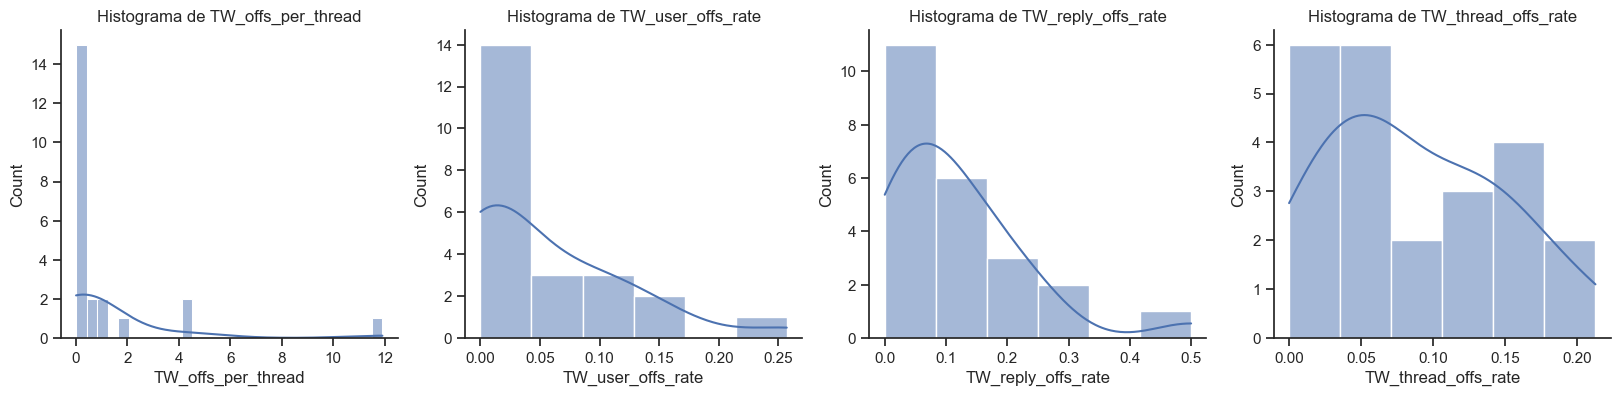

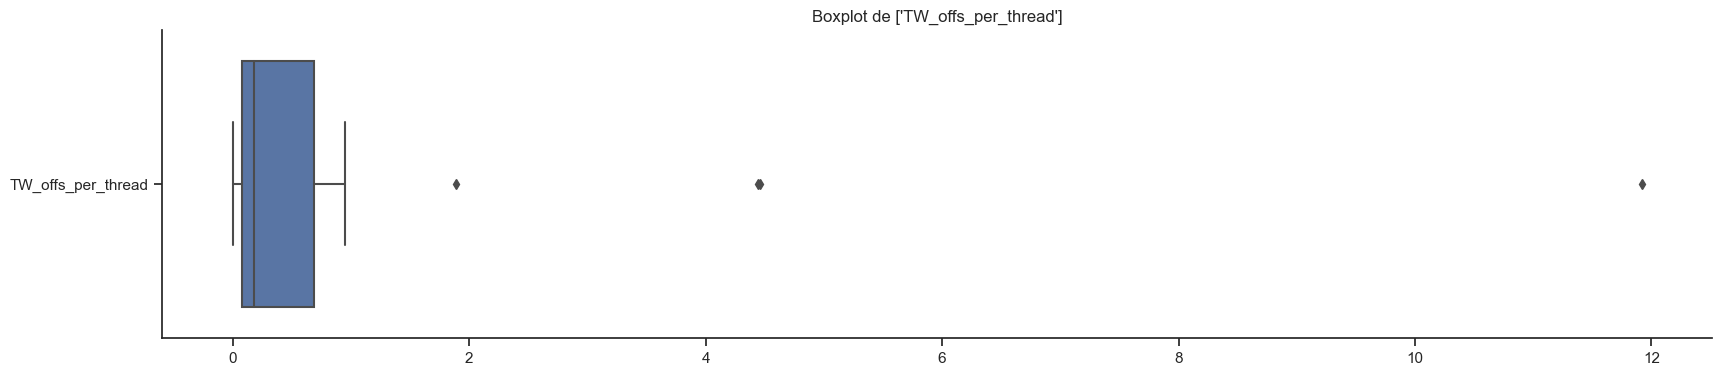

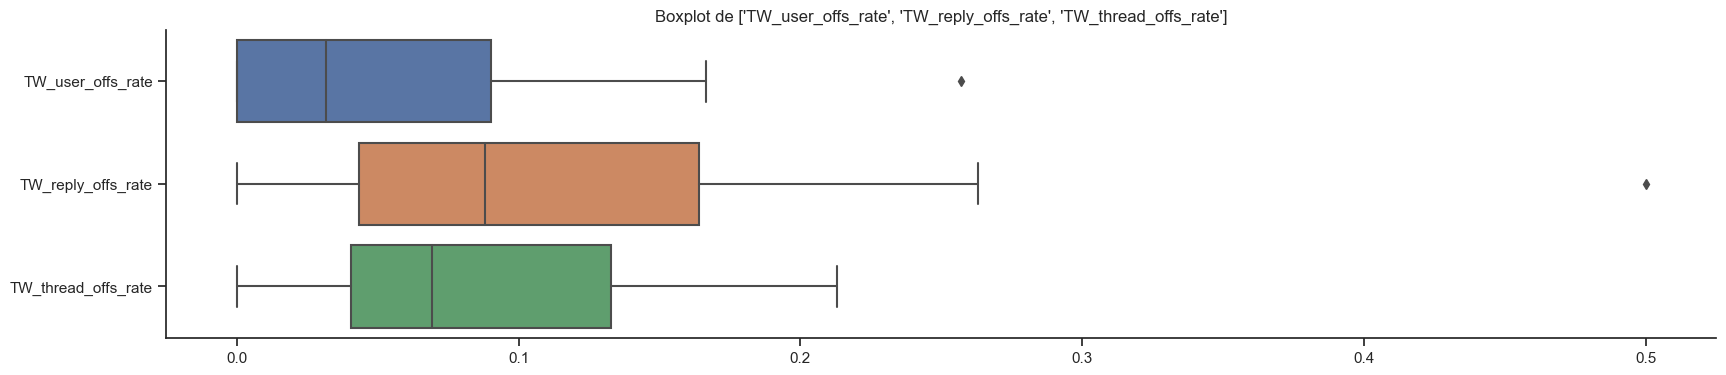

In [88]:
print_quant_data(
    cand_df, 
    prop_offense_cols, 
    'TW_thread_offs_rate'
)

side_by_side(
    cand_df[['TW_USER', 'TW_offs_per_thread']].sort_values('TW_offs_per_thread', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_user_offs_rate']].sort_values('TW_user_offs_rate', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_reply_offs_rate']].sort_values('TW_reply_offs_rate', ascending=False).head(5),
    cand_df[['TW_USER', 'TW_thread_offs_rate']].sort_values('TW_thread_offs_rate', ascending=False).head(5),
)

plot_histograms(
    cand_df, 
    prop_offense_cols, 
)

plot_boxplots(
    cand_df, 
    [prop_offense_cols[0]], 
)

plot_boxplots(
    cand_df, 
    prop_offense_cols[1:], 
)

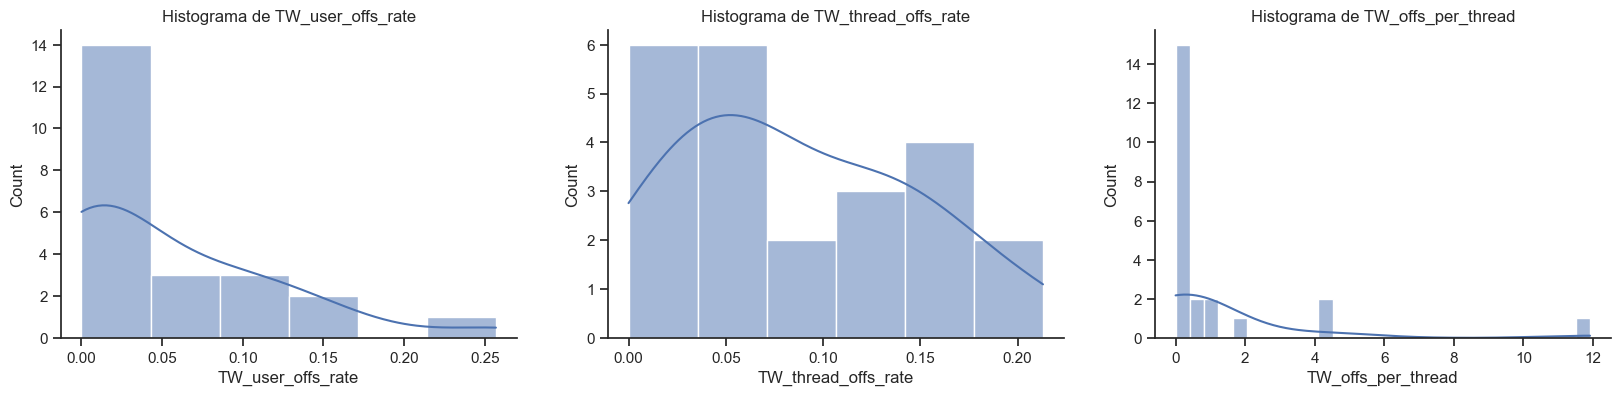

In [89]:
plot_histograms(cand_df, ['TW_user_offs_rate', 'TW_thread_offs_rate', 'TW_offs_per_thread',])

In [90]:
print(f"Distribuição de TW_offs_per_thread: \n{cand_df['TW_offs_per_thread'].value_counts(bins=5, normalize=True)}\n")

below_ten_prop = (cand_df[cand_df['TW_offs_per_thread'] <= 10].shape[0]) / (cand_df.shape[0])
print(f"{100*below_ten_prop:.2f}% dos candidatos tiveram até 10 tweets de conteúdo ofensivo por thread")

Distribuição de TW_offs_per_thread: 
(-0.012900000000000002, 2.384]    0.869565
(2.384, 4.767]                    0.086957
(9.534, 11.918]                   0.043478
(4.767, 7.151]                    0.000000
(7.151, 9.534]                    0.000000
Name: TW_offs_per_thread, dtype: float64

95.65% dos candidatos tiveram até 10 tweets de conteúdo ofensivo por thread


Ao considerarmos proporções ao invés de números absolutos as distribuições ficaram mais contínuas, diluindo o impacto dos outliers. 

Vamos agora avaliar a correlação entre estas variáveis para poder confirmar nossas suspeitas.

## Análise de Correlações

### Correlação entre as métricas de engajamento 

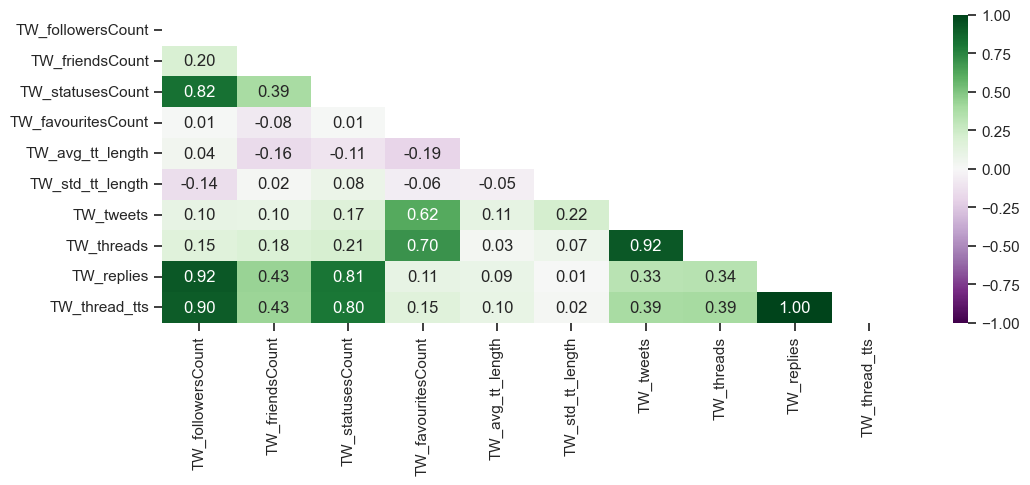

In [91]:
# Checando métricas absolutas de engajamento
_df = cand_df[account_metric_cols + tweet_length_cols + abs_activity_cols]
abs_engag_corr = plot_corr_heatmap(_df)

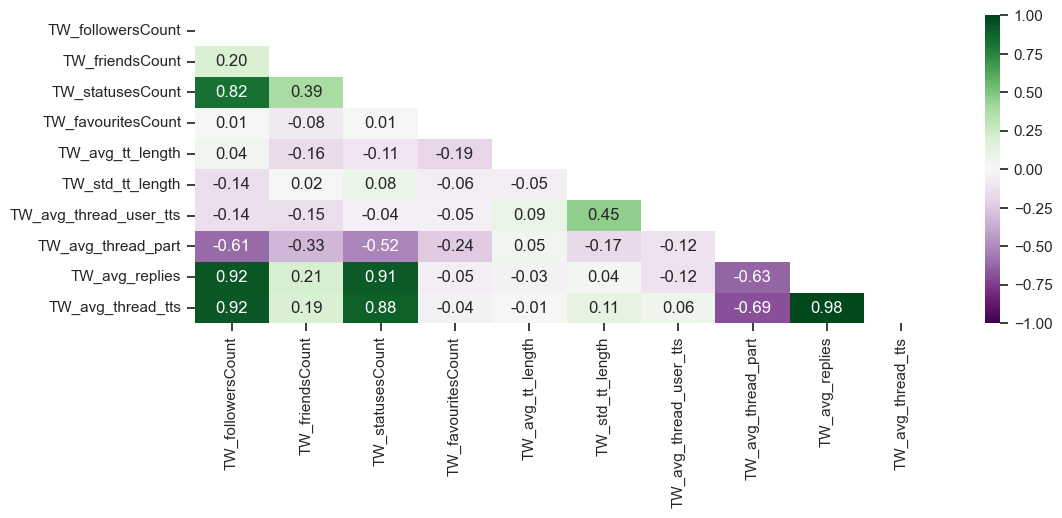

In [92]:
# Checando métricas proporcionais de engajamento
_df = cand_df[account_metric_cols + tweet_length_cols + prop_activity_cols]
prop_engag_corr = plot_corr_heatmap(_df)

In [93]:
insights.append({
    'col_1': 'TW_thread_tts',
    'col_2': 'TW_replies',
    'association': 'Correlação forte e direta',
    'metrics': {'corr': abs_engag_corr['TW_thread_tts']['TW_replies']},
    'extra': 'Relação esperada, mas o fato dela ser tão alta aponta que as threads são formadas predominantemente por replies'
})

insights.append({
    'col_1': 'TW_followersCount',
    'col_2': 'TW_statusesCount',
    'association': 'Correlação forte e direta',
    'metrics': {'corr': abs_engag_corr['TW_followersCount']['TW_statusesCount']},
    'extra': 'Faz sentido que contas com mais postagens no total sejam mais ativas, e por isso atraiam mais seguidores'
})

insights.append({
    'col_1': 'TW_followersCount',
    'col_2': 'TW_thread_tts',
    'association': 'Correlação forte e direta',
    'metrics': {'corr': abs_engag_corr['TW_followersCount']['TW_thread_tts']},
    'extra': 'Relação esperada, que demonstra o impacto da quantidade de seguidores no engajamento em suas publicações'
})

insights.append({
    'col_1': 'TW_followersCount',
    'col_2': 'TW_avg_thread_part',
    'association': 'Correlação média e inversa',
    'metrics': {'corr': prop_engag_corr['TW_followersCount']['TW_avg_thread_part']},
    'extra': 'Relação esperada, pois com mais engajamento externo a proporção dos próprios tweets nas threads diminui'
})

insights.append({
    'col_1': 'TW_favouritesCount',
    'col_2': 'TW_threads',
    'association': 'Correlação média e direta',
    'metrics': {'corr': abs_engag_corr['TW_favouritesCount']['TW_threads']},
    'extra': 'Tanto a quantidade de threads quanto de curtidas em outros tweets são indicadores diretos de que a conta é ativa, então faz sentido que estejam correlacionadas'
})

**TW_followersCount (quantidade de seguidores)**
- Relação forte com TW_statusesCount
    - Faz sentido que contas com mais postagens no total sejam mais ativas, e por isso atraiam mais seguidores
- Relação forte com 'TW_replies', 'TW_thread_tts', 'TW_avg_replies', 'TW_avg_thread_tts'
    - Era uma relação esperada, e demonstran o impacto da quantidade de seguidores no engajamento em suas publicações
- Relação média inversa com TW_avg_thread_part
    - Também esperado, afinal com mais engajamento externo a proporção dos próprios tweets nas threads diminui
 
**TW_favouritesCount (quantidade de postagens que curtiu)**
- Relação média com 'TW_tweets' e 'TW_threads'
    - Tanto a quantidade de postagens quanto de curtidas em outras postagens são indicadores diretos de que a conta é ativa, então faz sentido que estejam correlacionadas

### Correlação entre métricas de conteúdo ofensivo

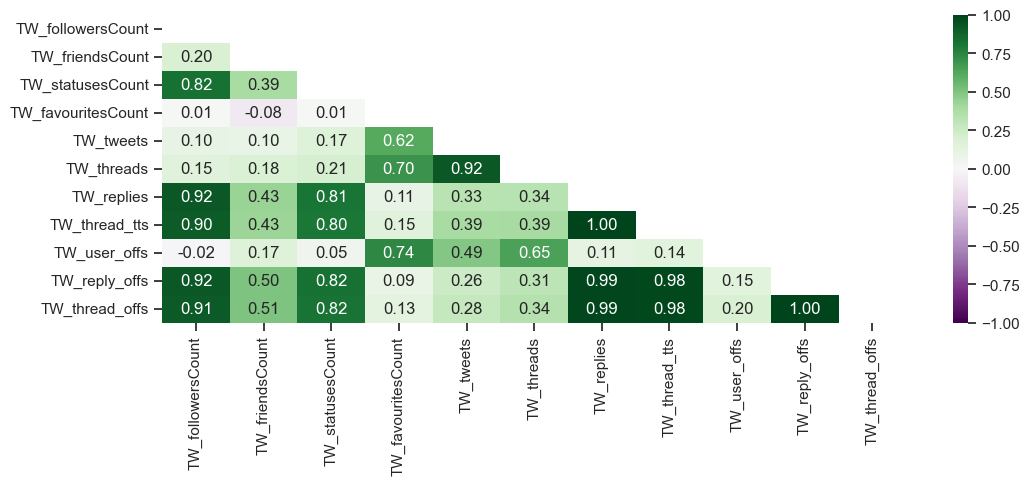

In [94]:
# Avaliando correlação entre os valores absolutos de conteúdo ofensivo
cols = account_metric_cols + abs_activity_cols + abs_offense_cols
_df = cand_df[cols]
abs_off_corr = plot_corr_heatmap(_df)

**TW_user_offs (tweets com conteúdo ofensivo postados pelo usuário)**
- Relação média com 'TW_tweets', 'TW_threads'
    - Esperado, afinal usuarios que postem mais tem maior probabilidade de postar conteúdo ofensivo
- Relação média com TW_favouritesCount
    - Esta relação chama atenção à principio, mas como TW_favouritesCount também tem uma correlação muito forte com 'TW_tweets', 'TW_threads' isso faz sentido

In [95]:
insight = {
    'col_1': 'TW_user_offs',
    'col_2': 'TW_tweets, TW_threads',
    'association': 'Correlação alta e direta',
    'metrics': {'corr': abs_off_corr['TW_user_offs']['TW_threads']},
    'extra': 'Esperado que usuarios que postam mais tem maior probabilidade de postar conteúdo ofensivo'
}
insights.append(insight)

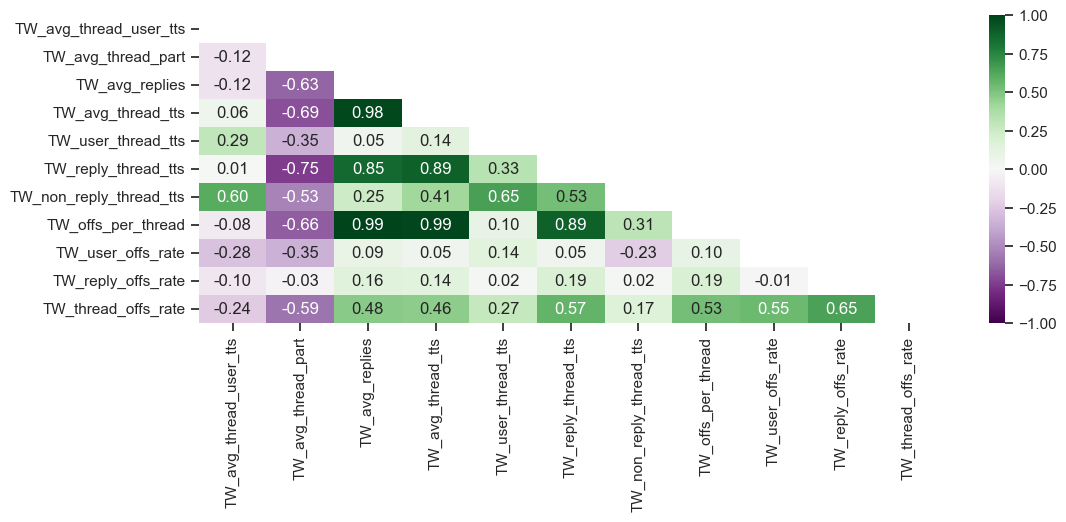

In [96]:
# Avaliando correlação entre as taxas
cols = prop_activity_cols + thread_comp_cols + prop_offense_cols
_df = cand_df[cols]

prop_off_corr = plot_corr_heatmap(_df)

In [97]:
insight = {
    'col_1': 'TW_avg_thread_part',
    'col_2': 'TW_offs_per_thread',
    'association': 'Correlação média e inversa',
    'metrics': {'corr': prop_off_corr['TW_avg_thread_part']['TW_offs_per_thread']},
    'extra': ''
}
insights.append(insight)

insight = {
    'col_1': 'TW_avg_thread_part',
    'col_2': 'TW_thread_offs_rate',
    'association': 'Correlação média e inversa',
    'metrics': {'corr': prop_off_corr['TW_avg_thread_part']['TW_thread_offs_rate']},
    'extra': ''
}
insights.append(insight)

In [98]:
cand_df['TW_engage_lvl'].values

array(['Alto', 'Médio', 'Baixo', 'Baixo', 'Médio', 'Baixo', 'Médio',
       'Alto', 'Baixo', 'Médio', 'Médio', 'Alto', 'Alto', 'Alto', 'Alto',
       'Baixo', 'Baixo', 'Alto', 'Baixo', 'Médio', 'Baixo', 'Alto',
       'Médio'], dtype=object)

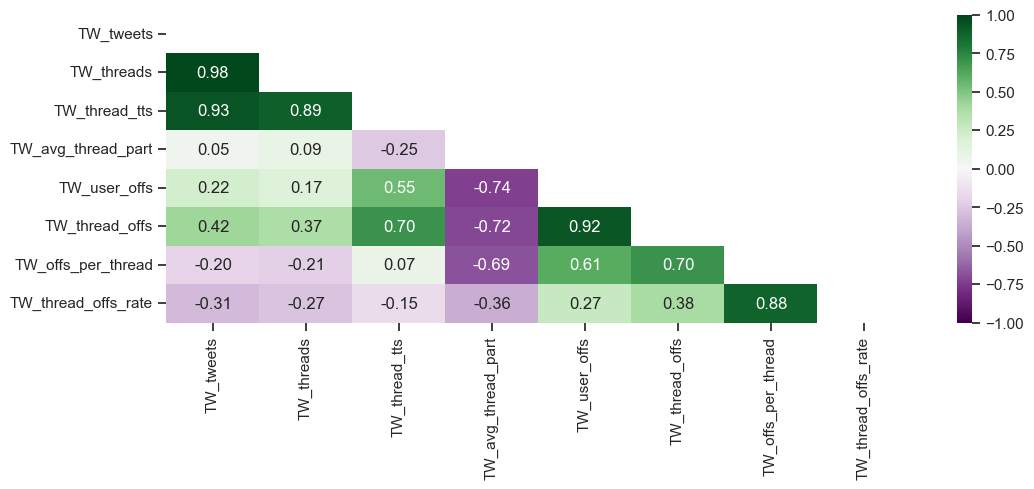

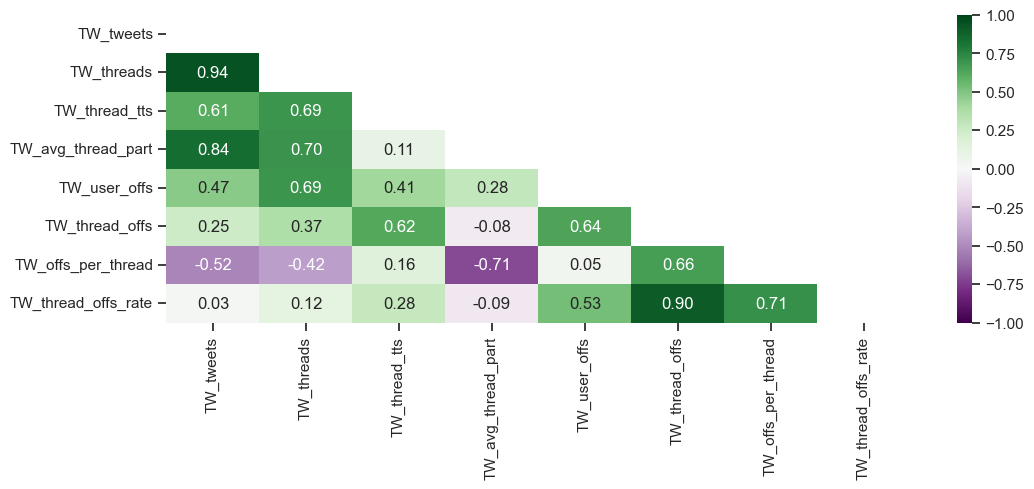

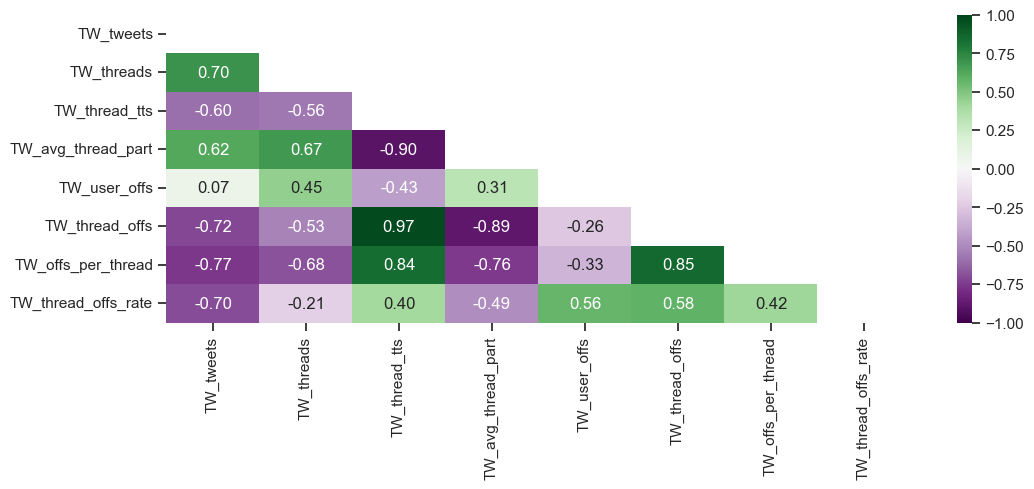

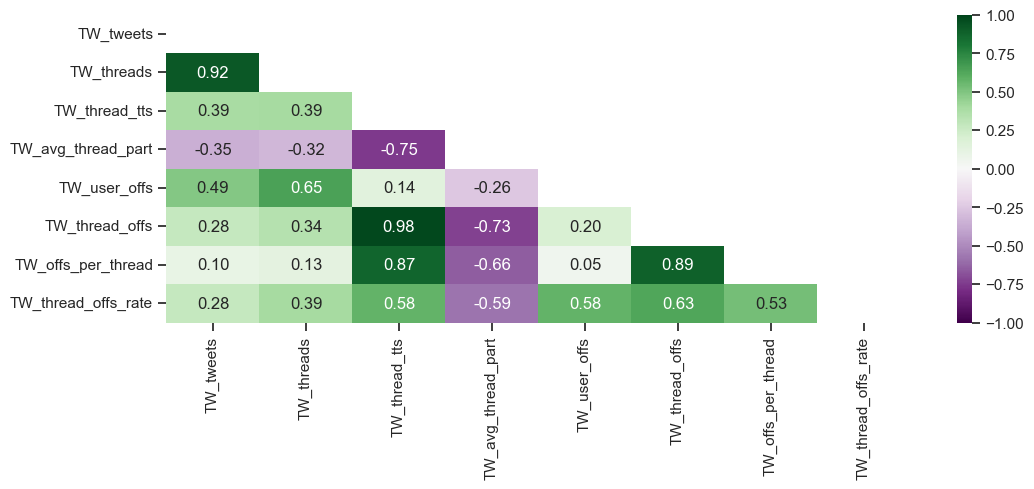

In [99]:
# Correlação segmentando por níveis de negajamento
cols = [
    'TW_tweets', 'TW_threads', 'TW_thread_tts', 'TW_avg_thread_part', 
    'TW_user_offs', 'TW_thread_offs', 'TW_offs_per_thread', 'TW_thread_offs_rate'
]
# _df = cand_df[cand_df['TW_engage_lvl'] == 'Baixo' ][cols]
_ = plot_corr_heatmap(cand_df[cand_df['TW_engage_lvl'] == 'Baixo' ][cols])
_ = plot_corr_heatmap(cand_df[cand_df['TW_engage_lvl'] == 'Médio' ][cols])
_ = plot_corr_heatmap(cand_df[cand_df['TW_engage_lvl'] == 'Alto' ][cols])
_ = plot_corr_heatmap(cand_df[cols])

In [100]:
cand_df['TW_thread_tts'].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])

count      23.000000
mean     1090.000000
std      1902.835014
min         7.000000
10%        14.800000
25%        88.000000
50%       179.000000
75%       996.000000
90%      4447.400000
max      5992.000000
Name: TW_thread_tts, dtype: float64

[[<matplotlib.axis.XTick at 0x7f5525c64a00>,

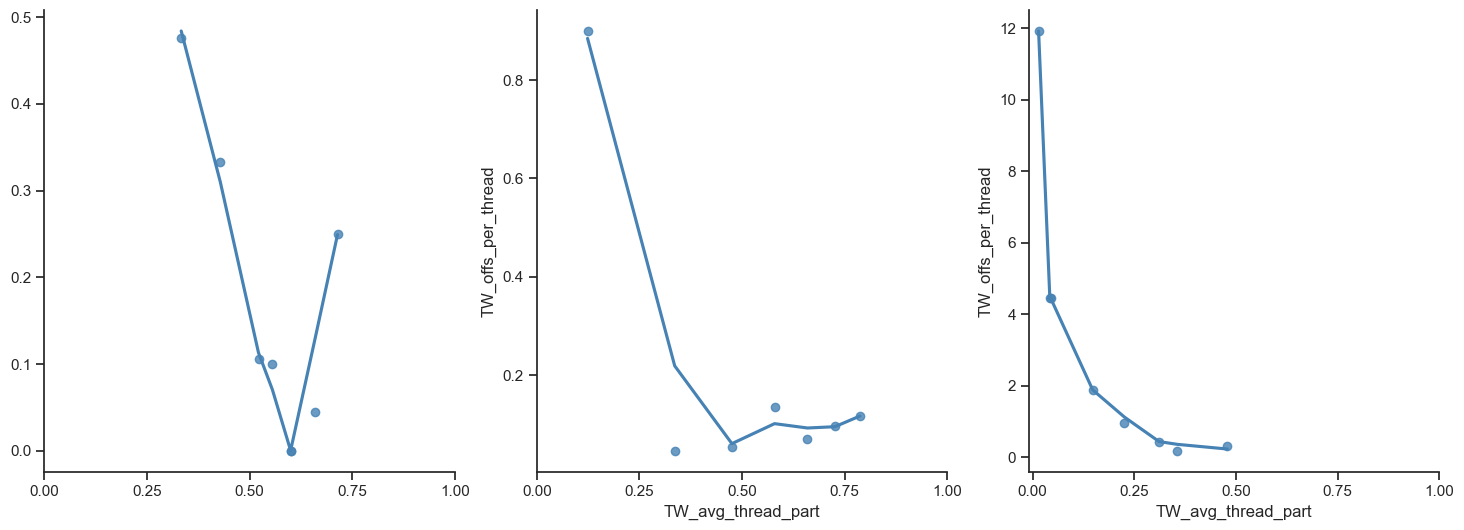

In [101]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

x = 'TW_avg_thread_part'
y = 'TW_offs_per_thread'


sns.regplot(
    data=cand_df[cand_df['TW_engage_lvl'] == 'Baixo'],
    x=x,
    y=y,
    color='steelblue',
    lowess=True,
    truncate=True,
    ax=ax[0],
).set(ylabel=None, xlabel=None)

sns.regplot(
    data=cand_df[cand_df['TW_engage_lvl'] == 'Médio'],
    x=x,
    y=y,
    color='steelblue',
    lowess=True,
    truncate=True,
    ax=ax[1],
)

sns.regplot(
    data=cand_df[cand_df['TW_engage_lvl'] == 'Alto'],
    x=x,
    y=y,
    color='steelblue',
    lowess=True,
    truncate=True,
    ax=ax[2],
)

ax[0].set(xticks=([0, 0.25, 0.5, 0.75, 1]))
ax[1].set(xticks=([0, 0.25, 0.5, 0.75, 1]))
ax[2].set(xticks=([0, 0.25, 0.5, 0.75, 1]))

/tmp/ipykernel_14782/4164828302.py:49: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[0].set_xlim(0, 10)
/tmp/ipykernel_14782/4164828302.py:50: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[1].set_xlim(0, 10)
/tmp/ipykernel_14782/4164828302.py:51: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[2].set_xlim(0, 10)


(0.14663107602509762, 10)

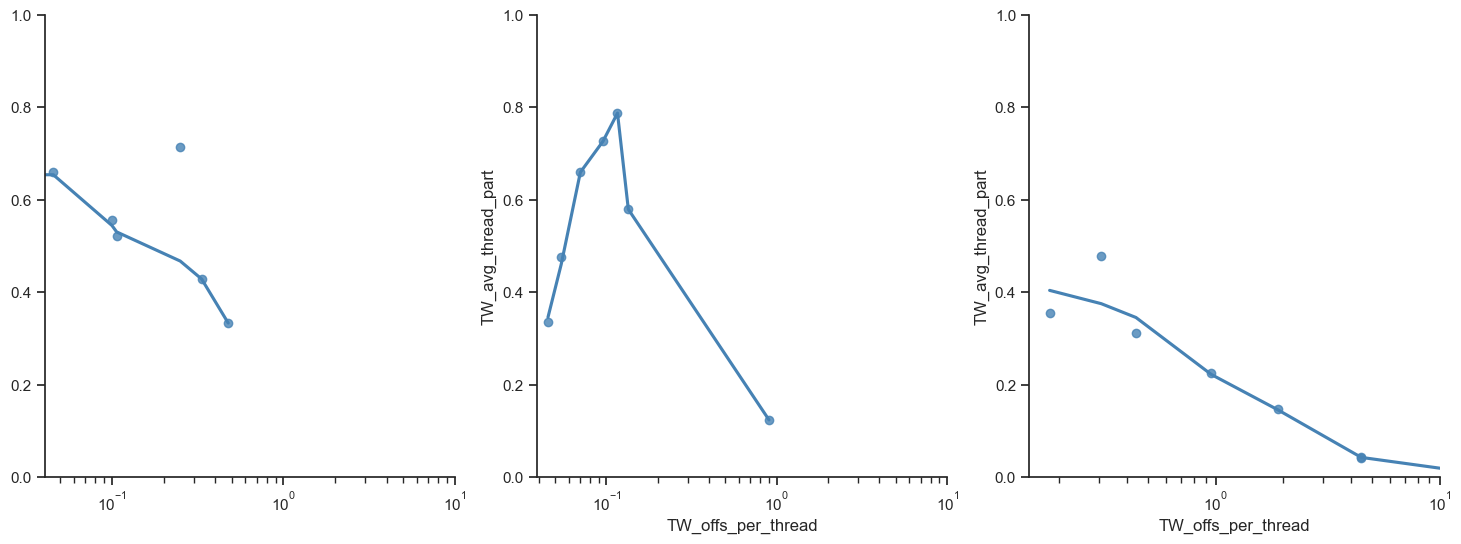

In [102]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

y = 'TW_avg_thread_part'
x = 'TW_offs_per_thread'


sns.regplot(
    data=cand_df[cand_df['TW_engage_lvl'] == 'Baixo'],
    x=x,
    y=y,
    color='steelblue',
    lowess=True,
    truncate=True,
    ax=ax[0],
).set(ylabel=None, xlabel=None)

sns.regplot(
    data=cand_df[cand_df['TW_engage_lvl'] == 'Médio'],
    x=x,
    y=y,
    color='steelblue',
    lowess=True,
    truncate=True,
    ax=ax[1],
)

sns.regplot(
    data=cand_df[cand_df['TW_engage_lvl'] == 'Alto'],
    x=x,
    y=y,
    color='steelblue',
    lowess=True,
    truncate=True,
    ax=ax[2],
)

ax[0].set_ylim(0, 1)
ax[1].set_ylim(0, 1)
ax[2].set_ylim(0, 1)

# ax[0].set(yticks=([0, 0.25, 0.5, 0.75, 1]))
# ax[1].set(yticks=([0, 0.25, 0.5, 0.75, 1]))
# ax[2].set(yticks=([0, 0.25, 0.5, 0.75, 1]))

ax[0].set(xscale='log')
ax[1].set(xscale='log')
ax[2].set(xscale='log')

ax[0].set_xlim(0, 10)
ax[1].set_xlim(0, 10)
ax[2].set_xlim(0, 10)



In [103]:
# cand_df[cand_df['TW_avg_thread_part'] ]
_df = cand_df[cand_df['TW_thread_tts'] >= 88 ]
_df[['TW_USER', 'TW_threads', 'TW_tweets', 'TW_thread_tts', 'TW_avg_thread_part']].sort_values('TW_avg_thread_part', ascending=False)

TW_USER  TW_threads  TW_tweets  TW_thread_tts  \
369     itamar_borges          86        141            179   
1216    marcialiapt13         178        178            245   
1000   xerifedoconsum          66         66            100   
977   thainarafariapt          71         95            144   
313         bethsahao          52         62            107   
924   deputadomaurici          47         48             92   
957    bfeministapsol         286        342            715   
464   professorabebel          92        107            225   
679    carlosgiannazi         354        493           1388   
186   rafaelsaraivasp          22         40            119   
749      caiofranca40         182        220            708   
826      valbolsonaro         285        288           1277   
1015    leosiqueirabr         116        372           2521   
661       lucasbovesp          20         24            194   
113   pauloteixeira13         206        217           4929   
671          esuplicy         202        252           5967   
403    marcofeliciano          85         87           5992   

      TW_avg_thread_part  
369             0.787709  
1216            0.726531  
1000            0.660000  
977             0.659722  
313             0.579439  
924             0.521739  
957             0.478322  
464             0.475556  
679             0.355187  
186             0.336134  
749             0.310734  
826             0.225529  
1015            0.147560  
661             0.123711  
113             0.044025  
671             0.042232  
403             0.014519

[Text(0, 0.5, 'Proporção de tts ofensivos'),
 Text(0.5, 0, 'Participação em threads')]

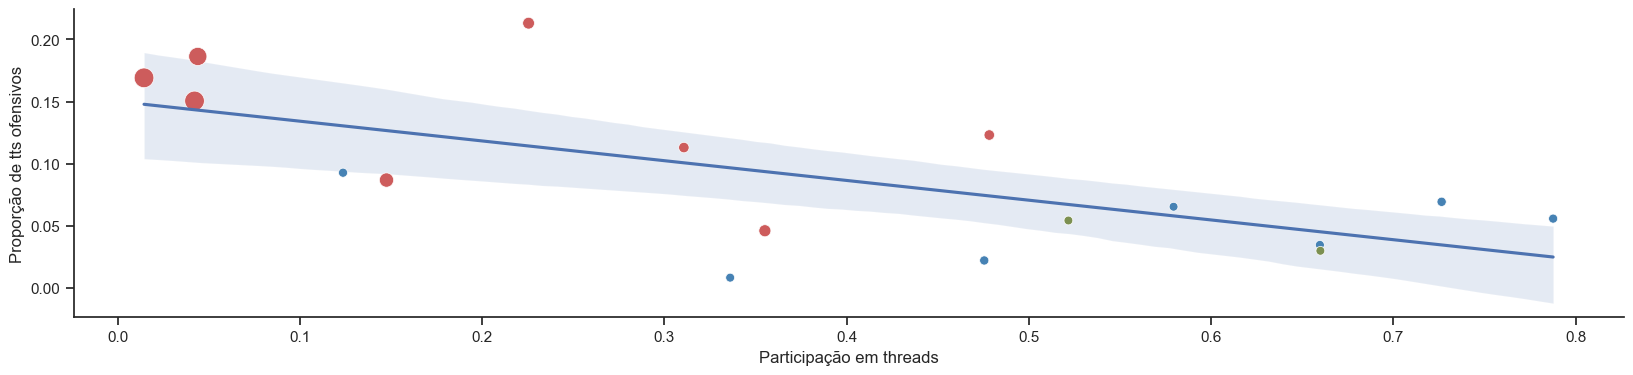

In [104]:
# Participação do candidato por Taxa de ofensas em suas threads (Corr = -0.58)
x = 'TW_avg_thread_part'
y = 'TW_thread_offs_rate'
plt.subplots(figsize=figsize)

_df = cand_df[cand_df['TW_thread_tts'] >= 88 ]

sns.regplot(
    data=_df,
    x=x,
    y=y,
    scatter_kws={'s': 1},
).set(ylabel=None, xlabel=None)

sns.scatterplot(
    data=_df,
    x=x,
    y=y,
    size='TW_thread_tts',
    sizes=(40, 200),
    # color='steelblue',
    hue='TW_engage_lvl',
    palette=trin_palette,
    legend=False,
).set(ylabel="Proporção de tts ofensivos", xlabel="Participação em threads")

<Axes: xlabel='TW_tweets', ylabel='TW_user_offs'>

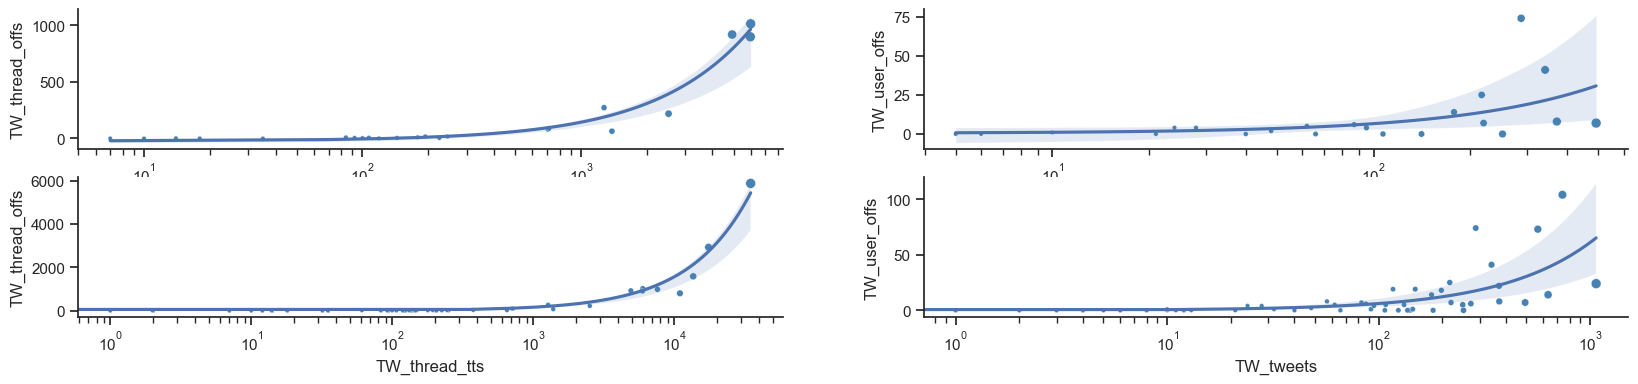

In [105]:
fig, ax = plt.subplots(2, 2, figsize=figsize)

x = 'TW_thread_tts'
y = 'TW_thread_offs'
sns.regplot(
    data=cand_df,
    x=x,
    y=y,
    scatter_kws={'s': 1},
    ax=ax[0][0],
).set(ylabel=None, xlabel=None, xscale='log')
sns.scatterplot(
    data=cand_df,
    x=x,
    y=y,
    size='TW_thread_tts',
    sizes=(10, 50),
    color='steelblue',
    legend=False,
    ax=ax[0][0],
)

x = 'TW_tweets'
y = 'TW_user_offs'
sns.regplot(
    data=cand_df,
    x=x,
    y=y,
    scatter_kws={'s': 1},
    ax=ax[0][1],
).set(ylabel=None, xlabel=None, xscale='log')
sns.scatterplot(
    data=cand_df,
    x=x,
    y=y,
    size='TW_tweets',
    sizes=(10, 50),
    color='steelblue',
    legend=False,
    ax=ax[0][1],
)


x = 'TW_thread_tts'
y = 'TW_thread_offs'
sns.regplot(
    data=raw_cand_df,
    x=x,
    y=y,
    scatter_kws={'s': 1},
    ax=ax[1][0],
).set(ylabel=None, xlabel=None, xscale='log')
sns.scatterplot(
    data=raw_cand_df,
    x=x,
    y=y,
    size='TW_thread_tts',
    sizes=(10, 50),
    color='steelblue',
    legend=False,
    ax=ax[1][0],
)

x = 'TW_tweets'
y = 'TW_user_offs'
sns.regplot(
    data=raw_cand_df,
    x=x,
    y=y,
    scatter_kws={'s': 1},
    ax=ax[1][1],
).set(ylabel=None, xlabel=None, xscale='log')
sns.scatterplot(
    data=raw_cand_df,
    x=x,
    y=y,
    size='TW_tweets',
    sizes=(10, 50),
    color='steelblue',
    legend=False,
    ax=ax[1][1],
)

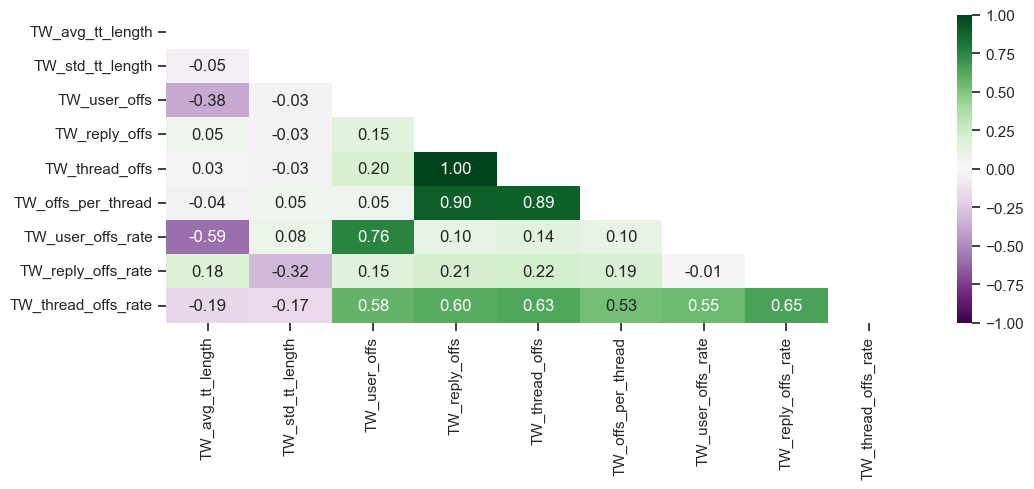

In [106]:
# Avaliando correlação entre tamanho dos tweets e conteúdo ofensivo
cols = tweet_length_cols + abs_offense_cols + prop_offense_cols
_df = cand_df[cols]

prop_off_len_corr = plot_corr_heatmap(_df)

**TW_avg_tt_length (tamanho médio dos tweets do usuario)**
- Relação inversa média com `TW_user_offs_rate`
    - Usuários com tweets maiores apresentaram uma pequena tendencia de redução de conteudo ofensivo
    - Isto é contra intuitivo, pois os tweets ofensivos tiveram tamanho médio significativamente maior do que os não ofensivos

In [107]:
insight = {
    'col_1': 'TW_avg_tt_length',
    'col_2': 'TW_user_offs_rate',
    'association': 'Correlação média e inversa',
    'metrics': {'corr': prop_off_len_corr['TW_avg_tt_length']['TW_user_offs_rate']},
    'extra': 'Estranho, pois os tweets ofensivos tiveram tamanho médio significativamente maior do que os não ofensivos'
}
insights.append(insight)

### Investigações sobre as correlações encontradas

Testes para visualizar melhor algumas correlações. Ainda experimental, não cheguei em nada relevante ainda

<Axes: >

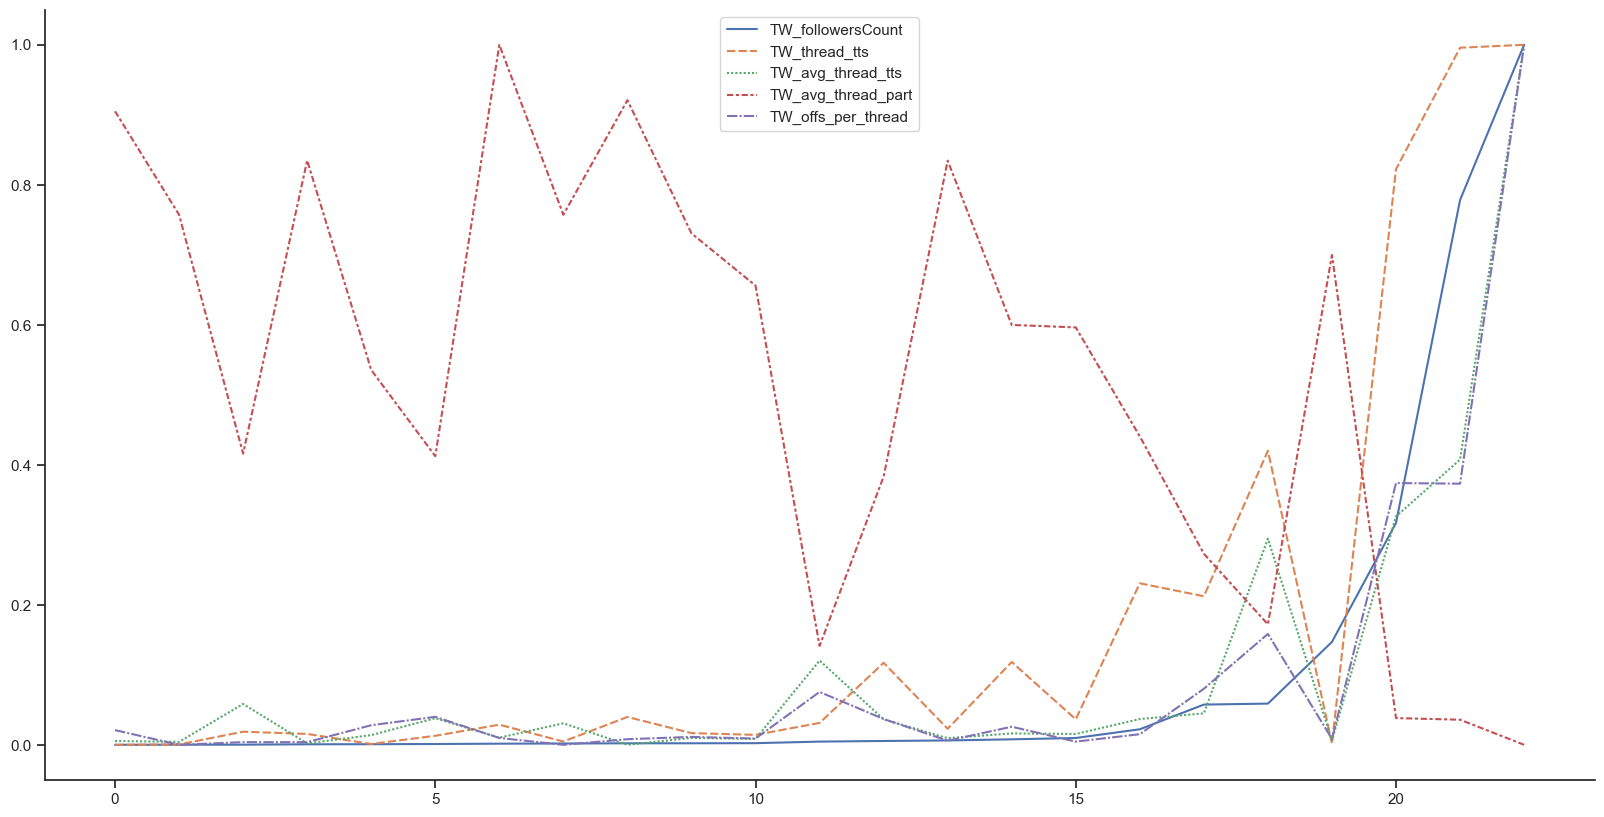

In [108]:
from sklearn.preprocessing import MinMaxScaler

corr_cols = ['TW_followersCount', 'TW_thread_tts', 'TW_avg_thread_tts', 'TW_avg_thread_part', 'TW_offs_per_thread']

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(
    np.array(cand_df[corr_cols])
)
scaled_df = pd.DataFrame(scaled_data, columns=corr_cols)
scaled_df = scaled_df.sort_values('TW_followersCount')

plt.figure(figsize=(20, 10))
sns.lineplot(
    data=scaled_df.reset_index(drop=True),
)

<Axes: xlabel='TW_followersCount', ylabel='TW_offs_per_thread'>

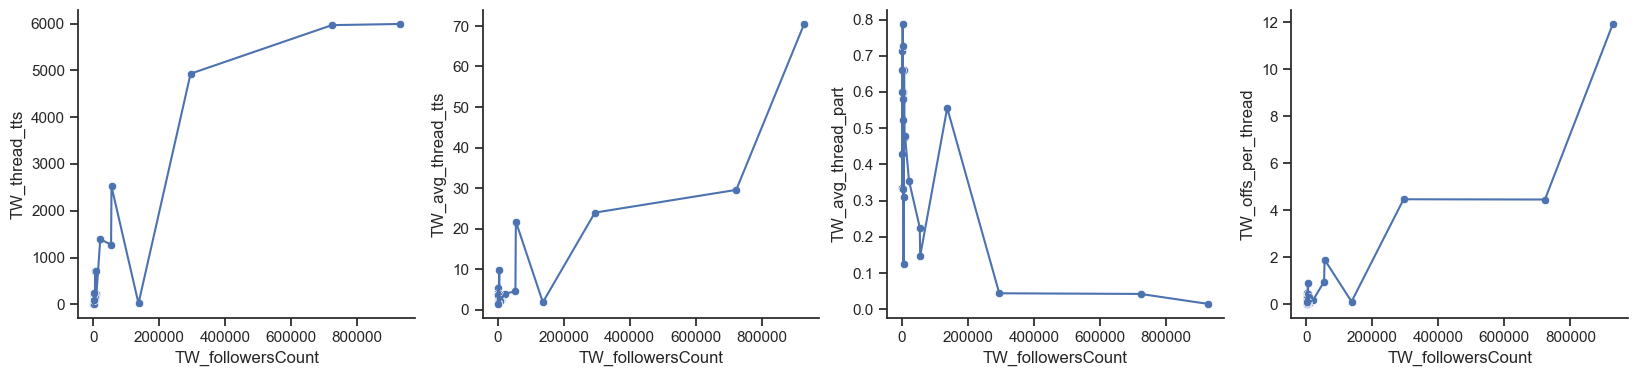

In [109]:
fig, ax = plt.subplots(1, 4, figsize=(20, 4))

sns.lineplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[1],
    ax=ax[0],
)
sns.scatterplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[1],
    ax=ax[0],
)

sns.lineplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[2],
    ax=ax[1],
)
sns.scatterplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[2],
    ax=ax[1],
)

sns.lineplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[3],
    ax=ax[2],
)
sns.scatterplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[3],
    ax=ax[2],
)

sns.lineplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[4],
    ax=ax[3],
)
sns.scatterplot(
    data=cand_df,
    x='TW_followersCount',
    y=corr_cols[4],
    ax=ax[3],
)

Como esperado, encontramos correlações muito fortes entre a quantidade de tweets postados e a ocorrência de conteúdo ofensivo, tanto com relação a quantidade de threads abertas, quanto de tamanho das threads.

## Análise das métricas calculadas por feature dos candidatos

In [110]:
# Definindo as colunas quantitativas que serão testadas com colunas qualitativas
x_cols = abs_activity_cols + prop_activity_cols + thread_comp_cols + abs_offense_cols + prop_offense_cols

### Gênero

In [111]:
# Visualizando a distribuição de gênero entre os tweets
print(cand_df['DS_GENERO'].value_counts())

MASCULINO    16
FEMININO      7
Name: DS_GENERO, dtype: int64


Diferença significativa encontrada nas colunas: ['TW_user_offs', 'TW_user_offs_rate']



col   p_value    t_stat  sig_dif
11       TW_user_offs  0.029832 -2.330453     True
15  TW_user_offs_rate  0.024542 -2.422506     True

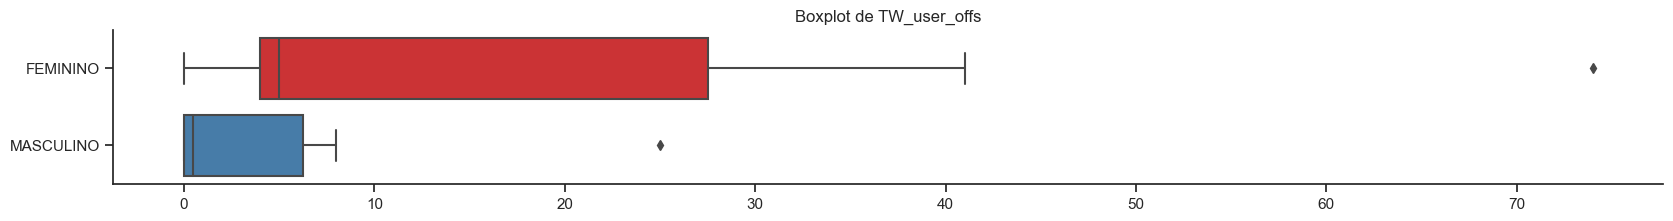

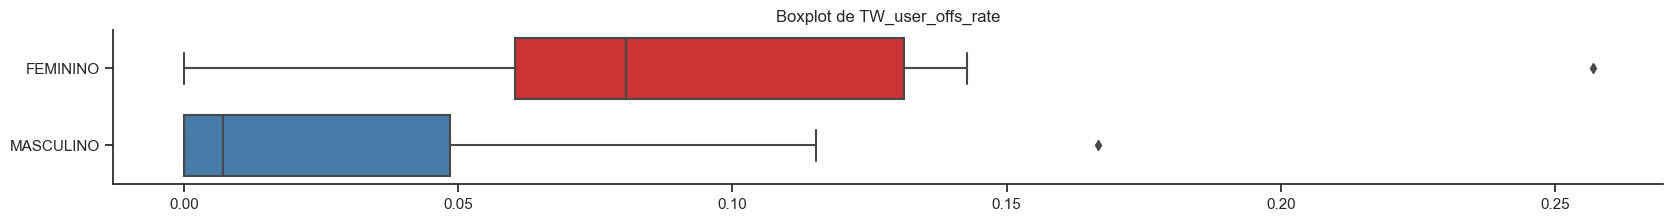

In [112]:
# Teste T de Student para comparar a diferença entre as médias por gênero
y_col = 'DS_GENERO'
y_val_0 = 'MASCULINO'
y_val_1 = 'FEMININO'
_ttest = t_test_candidate_quali_columns(cand_df, x_cols, y_col, y_val_0, y_val_1)

<Axes: xlabel='TW_threads', ylabel='DS_GENERO'>

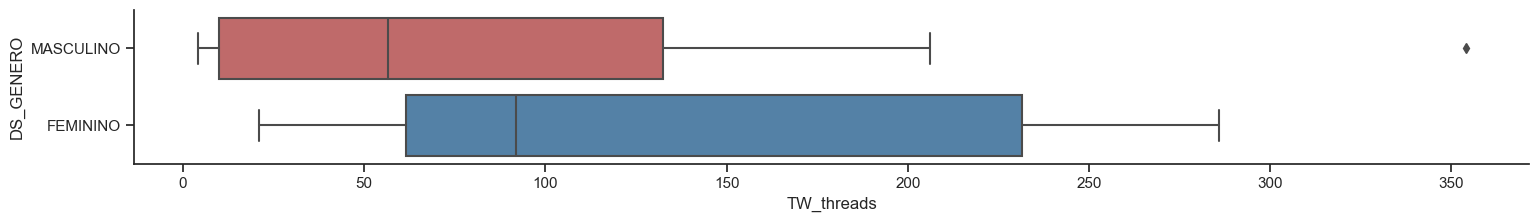

In [113]:
plt.subplots(figsize=(18, 2))
sns.boxplot(
    data=cand_df,
    y='DS_GENERO',
    x='TW_threads',
    palette=trin_palette,
)

Foram encontradas diferenças significativas em 2 métricas diretas de atividade no Twitter: `TW_tweets` e `TW_threads`.

Também foram encontradas diferenças em `TW_user_thread_tts` (razão entre tweets do usuario e total de tweets em suas threads) e `TW_user_offs` (quantidade de tweets do usuário com conteúdo ofensivo), porém como estas colunas já possuem uma forte associação com `TW_tweets` e `TW_threads`, não podemos afirmar o gênero foi o fator determinante para a associação.

<Axes: xlabel='TW_user_offs_rate', ylabel='DS_GENERO'>

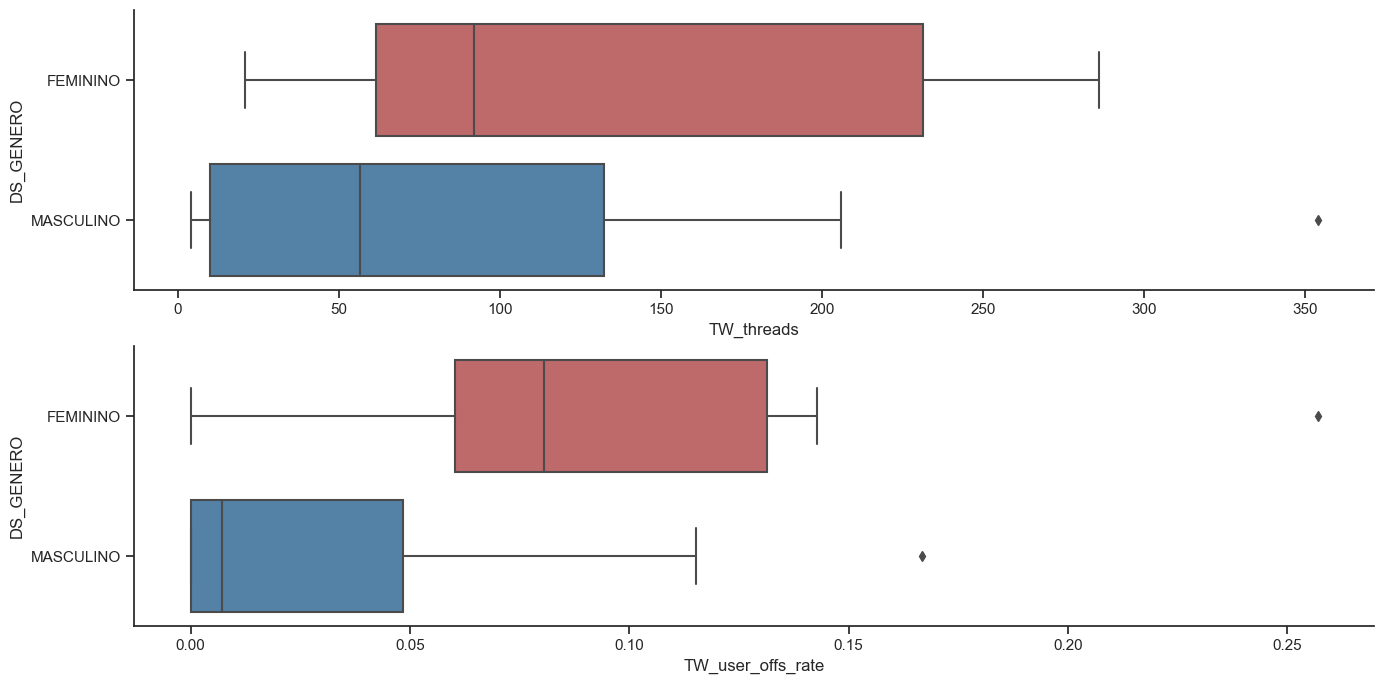

In [114]:
f, ax = plt.subplots(2, 1, figsize=(16, 8))
# plt.subplots(figsize=(16, 4))

sns.boxplot(
    data=cand_df,
    x='TW_threads',
    y='DS_GENERO',
    order=['FEMININO', 'MASCULINO'],
    palette=trin_palette,
    ax=ax[0],
)
sns.boxplot(
    data=cand_df,
    x='TW_user_offs_rate',
    y='DS_GENERO',
    order=['FEMININO', 'MASCULINO'],
    palette=trin_palette,
    ax=ax[1],
)


In [115]:
# Uma única candidata mulher está puxando a média de toda a categoria
cand_df.sort_values('TW_user_offs_rate', ascending=False)[['TW_USER', 'SG_PARTIDO', 'TW_tweets', 'TW_user_offs', 'TW_user_offs_rate']][:5]

TW_USER SG_PARTIDO  TW_tweets  TW_user_offs  TW_user_offs_rate
826     valbolsonaro         PL        288            74           0.256944
661      lucasbovesp         PL         24             4           0.166667
238         sppretas       PSOL         28             4           0.142857
957   bfeministapsol       PSOL        342            41           0.119883
113  pauloteixeira13         PT        217            25           0.115207

/tmp/ipykernel_14782/1847824053.py:21: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(


<Axes: xlabel='TW_tweets', ylabel='TW_user_offs'>

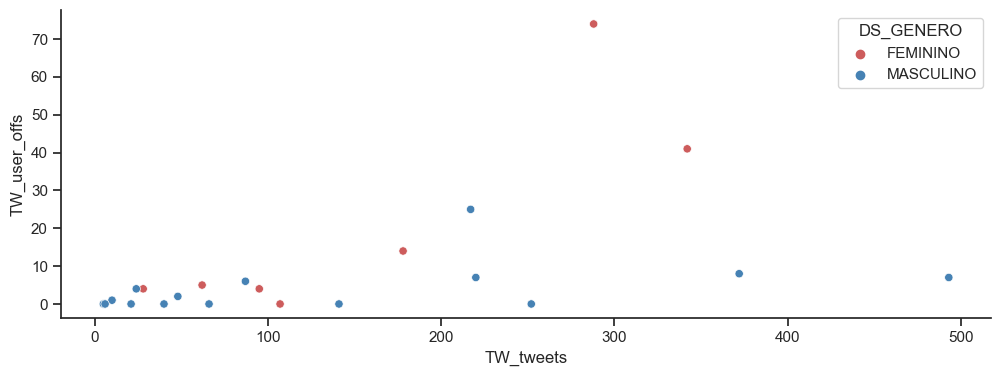

In [116]:
plt.subplots(figsize=(12, 4))
# _df = cand_df[cand_df['DS_GENERO'] == 'MASCULINO']
# sns.regplot(
#     data=_df,
#     x='TW_tweets',
#     y='TW_user_offs',
#     color='blue',
#     # ax=ax[0],
# )#.set(xscale="log")

# _df = cand_df[cand_df['DS_GENERO'] == 'FEMININO']
# sns.regplot(
#     data=_df,
#     x='TW_tweets',
#     y='TW_user_offs',
#     color='red',
#     # palette=trin_palette,
#     # ax=ax[0],
# )#.set(xscale="log")

sns.scatterplot(
    data=cand_df,
    x='TW_tweets',
    y='TW_user_offs',
    hue='DS_GENERO',
    hue_order=['FEMININO', 'MASCULINO'],
    palette=trin_palette,
    # ax=ax[0],
)

### Cor/Raça

In [117]:
cand_df[cand_df['DS_COR_RACA'] != 'BRANCA'][['TW_USER','DS_COR_RACA']]

TW_USER DS_COR_RACA
238         sppretas       PRETA
947      lcmarcolino       PRETA
957   bfeministapsol       PRETA
977  thainarafariapt       PRETA

In [118]:
print(cand_df['DS_COR_RACA'].value_counts())

BRANCA    19
PRETA      4
Name: DS_COR_RACA, dtype: int64


In [119]:
# Como temos quatro classes diferentes, precisamos agrupa-las em somente duas para fazer o teste de hipoteses. 
# Como a classe BRANCA já está bastante desbalanceada, vamos deixá-la como está e agrupar PRETA, PARDA e INDÍGENA como NAO-BRANCA
def get_simplified_color(color):
    if color != 'BRANCA':
        return 'NAO_BRANCA'
    return color

cand_df['DS_COR_RACA_SIMP'] = cand_df['DS_COR_RACA'].apply(get_simplified_color)
print(cand_df['DS_COR_RACA_SIMP'].value_counts())

BRANCA        19
NAO_BRANCA     4
Name: DS_COR_RACA_SIMP, dtype: int64


In [120]:
# Teste T de Student para comparar a diferença entre as médias por cor/raça
y_col = 'DS_COR_RACA_SIMP'
y_val_0 = 'BRANCA'
y_val_1 = 'NAO_BRANCA'
_ttest = t_test_candidate_quali_columns(cand_df, x_cols, y_col, y_val_0, y_val_1)

Nenhuma coluna apresentou diferença significativa para DS_COR_RACA_SIMP


### Grau/Instrução

In [121]:
print(cand_df['DS_GRAU_INSTRUCAO'].value_counts())

SUPERIOR COMPLETO    23
Name: DS_GRAU_INSTRUCAO, dtype: int64


Os dados de DS_GRAU_INSTRUCAO estão muito desbalanceados, portanto não podemos fazer análises sobre eles

### Candidato a Reeleição

In [122]:
tested_col = 'ST_REELEICAO'
print(cand_df[tested_col].value_counts())

S    12
N    11
Name: ST_REELEICAO, dtype: int64


Diferença significativa encontrada nas colunas: ['TW_reply_offs_rate']



col   p_value    t_stat  sig_dif
16  TW_reply_offs_rate  0.026899 -2.379426     True

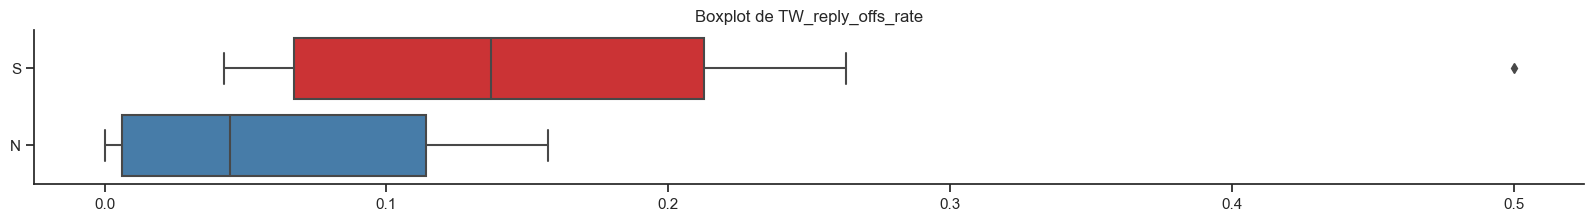

In [123]:
# Teste T de Student para comparar a diferença entre as médias por cor/raça
y_col = 'ST_REELEICAO'
y_val_0 = 'N'
y_val_1 = 'S'
_ttest = t_test_candidate_quali_columns(cand_df, x_cols, y_col, y_val_0, y_val_1)

In [124]:
cand_df[['TW_USER', 'DS_GENERO', 'TW_tweets', 'TW_user_offs', 'TW_user_offs_rate']].sort_values('TW_user_offs_rate', ascending=False)[:5]

TW_USER  DS_GENERO  TW_tweets  TW_user_offs  TW_user_offs_rate
826     valbolsonaro   FEMININO        288            74           0.256944
661      lucasbovesp  MASCULINO         24             4           0.166667
238         sppretas   FEMININO         28             4           0.142857
957   bfeministapsol   FEMININO        342            41           0.119883
113  pauloteixeira13  MASCULINO        217            25           0.115207

In [125]:
df[(df['user'] == 'valbolsonaro') & (df['class_label'] == True)].sample(10)['content'].values

array(['Corja de militantes sujos!!! Deveriam perder o diploma, isso é criminoso!!! https://t.co/R34blfItPn',
       'A CPI da vergonha , da turma do Descondenado ladrão e toda sua corja não provou nada !!!',
       'Com toda certeza o bandido Descondenado acha que os seus Ministros tem currículo, o currículo de partidarismo, principalmente o que  soltou \no ex-presidiário para concorrer à Presidência !!!!',
       'O cara de Pau do governador Raiz @rodrigogarcia, falando em acabar com a fome diminuindo ICMS, o safado sequer cancelou o decreto do seu amiguinho Agripino que todos os meses confisca parte do salário dos servidores públicos aposentados .\nRAIZ DE ERVA DANINHA !!!!',
       'Ué???? Cadê a esquerda sempre defensora das minorias???? \nO discurso mentiroso e manipulador da esquerda está cada vez mais escancarado!!!!!!! https://t.co/ykdnBC9tqz',
       'Para os adoradores da bandidagem, realmente é um choque quando alguém se posiciona contra !!!!! https://t.co/azqwNmclgl',
    

# Conclusão

**Correlações entre as métricas:**
- TW_avg_thread_part e -TW_offs_per_thread
- TW_avg_thread_part e -TW_thread_offs_rate

**Diferenças significativas entre categorias:**
- DS_GENERO e TW_tweets
- DS_GENERO e TW_threads
- DS_GENERO e TW_user_thread_tts
- DS_GENERO e TW_user_offs

In [126]:
insights_df = pd.DataFrame(insights)

print('Filtros utilizados:')
for f in filters:
    print(f)

print('\nRelações encontradas entre as colunas:')
insights_df.sort_values('col_1')

Filtros utilizados:
{'col': 'class_score', 'condition': '> 0.798449'}
{'col': 'TW_USER', 'condition': "not in ['julianapt', 'adriventurasp', 'rosangelamorosp', 'carlossampaio_', 'anaperugini']"}
{'col': 'TW_threads', 'condition': '> 1'}
{'col': 'TW_replies', 'condition': '> 1'}
{'col': 'TW_thread_tts', 'condition': '<= 7398.4'}

Relações encontradas entre as colunas:


col_1                    col_2  \
12           DS_GENERO             TW_user_offs   
13           DS_GENERO        TW_user_offs_rate   
14        ST_REELEICAO       TW_reply_offs_rate   
9   TW_avg_thread_part       TW_offs_per_thread   
10  TW_avg_thread_part      TW_thread_offs_rate   
11    TW_avg_tt_length        TW_user_offs_rate   
7   TW_favouritesCount               TW_threads   
4    TW_followersCount         TW_statusesCount   
5    TW_followersCount            TW_thread_tts   
6    TW_followersCount       TW_avg_thread_part   
3        TW_thread_tts               TW_replies   
8         TW_user_offs    TW_tweets, TW_threads   
0          class_label              class_score   
1          class_label           content_length   
2          class_label  filtered_content_length   

                          association  \
12  Diferença significativa de médias   
13  Diferença significativa de médias   
14  Diferença significativa de médias   
9          Correlação média e inversa   
10         Correlação média e inversa   
11         Correlação média e inversa   
7           Correlação média e direta   
4           Correlação forte e direta   
5           Correlação forte e direta   
6          Correlação média e inversa   
3           Correlação forte e direta   
8            Correlação alta e direta   
0   Diferença significativa de médias   
1   Diferença significativa de médias   
2   Diferença significativa de médias   

                                                            metrics  \
12   {'t_stat': -2.3304530314783527, 'p_value': 0.0298324862711511}   
13  {'t_stat': -2.422506112557246, 'p_value': 0.024542062435232406}   
14  {'t_stat': -2.379425892239724, 'p_value': 0.026899292691626817}   
9                                     {'corr': -0.6561520455446417}   
10                                    {'corr': -0.5852197593386925}   
11                                     {'corr': -0.594795697709295}   
7                                      {'corr': 0.6989617891076522}   
4                                      {'corr': 0.8214934958783946}   
5                                      {'corr': 0.9049051303815959}   
6                                      {'corr': -0.614775362102856}   
3                                      {'corr': 0.9976711314364741}   
8                                      {'corr': 0.6461808967447336}   
0                     {'t_stat': 60.85698002365709, 'p_value': 0.0}   
1                    {'t_stat': -46.38571534330981, 'p_value': 0.0}   
2                    {'t_stat': -46.48067411806944, 'p_value': 0.0}   

                                                                                                                                                              extra  
12                                                                                                                                                                   
13                                                                                                                                                                   
14                                                                                                                                                                   
9                                                                                                                                                                    
10                                                                                                                                                                   
11                                                        Estranho, pois os tweets ofensivos tiveram tamanho médio significativamente maior do que os não ofensivos  
7   Tanto a quantidade de threads quanto de curtidas em outros tweets são indicadores diretos de que a conta é ativa, então faz sentido que estejam correlacionadas  
4                                                          Faz sentido que con

Vamos visualizar as colunas que apresentaram correlação para entender melhor sua distribuição

#### TW_avg_thread_part

[Text(0.5, 1.0, 'Participação do candidato por média de ofensas nas threads (Corr = -0.66)')]

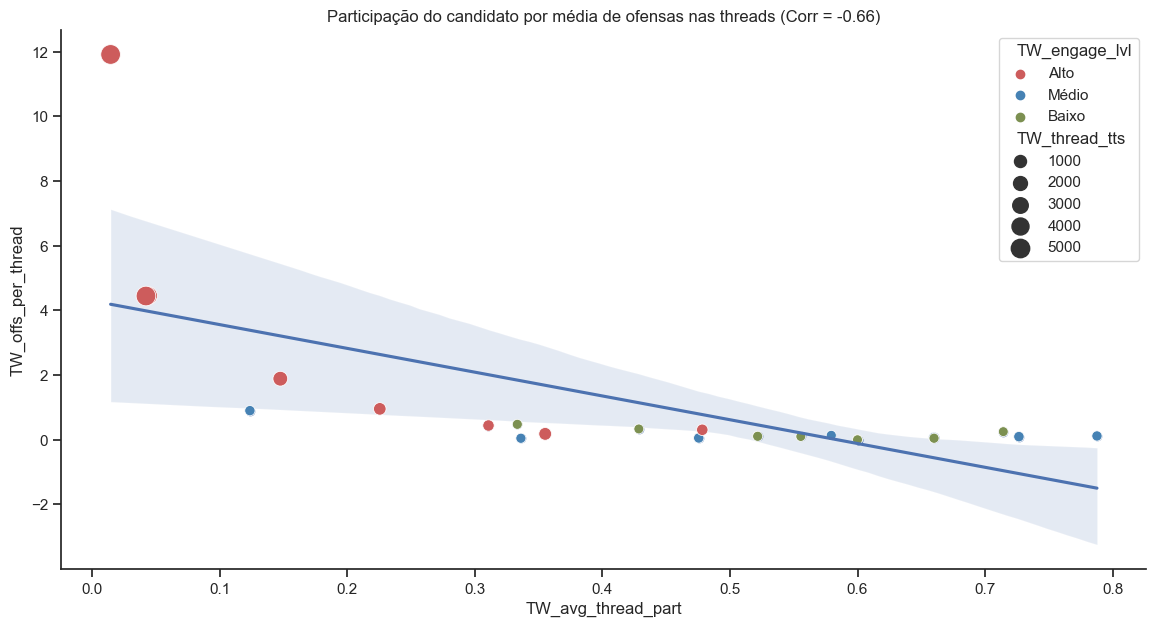

In [127]:
plt.subplots(figsize=(14, 7))
x = 'TW_avg_thread_part'
y = 'TW_offs_per_thread'

sns.regplot(
    data=cand_df,
    x=x,
    y=y,
)

sns.scatterplot(
    data=cand_df,
    x=x,
    y=y,
    size='TW_thread_tts',
    sizes=(50, 200),
    hue='TW_engage_lvl',
    palette=trin_palette,
).set(title=f'Participação do candidato por média de ofensas nas threads (Corr = -0.66)')

[Text(0.5, 1.0, 'Participação do candidato e taxa de ofensas nas threads (Corr = -0.58)')]

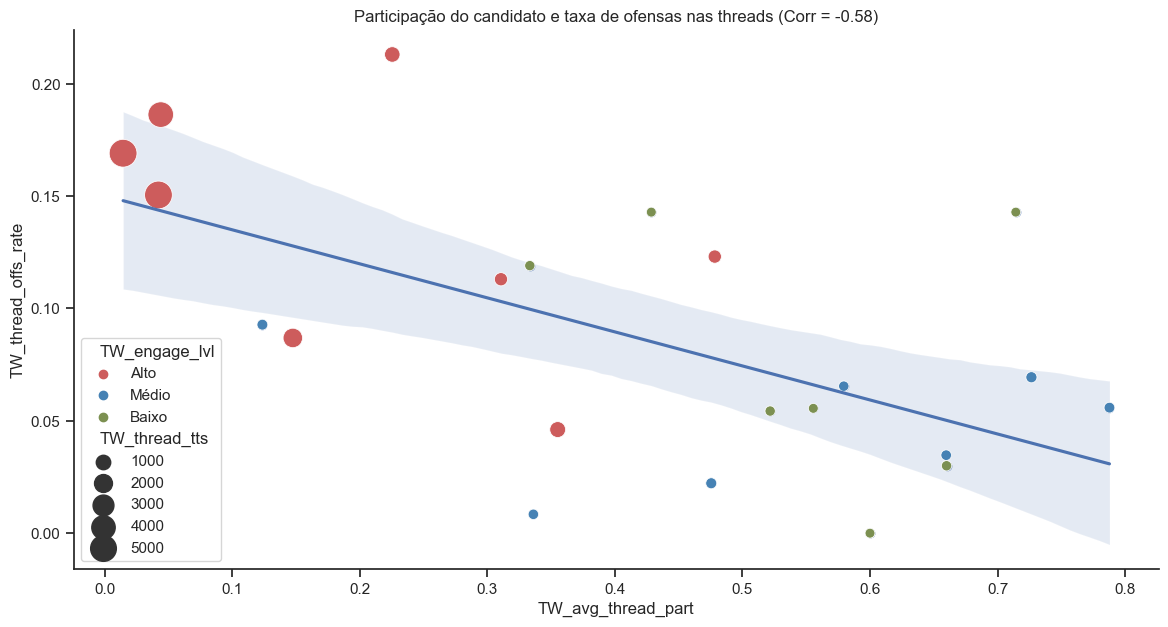

In [128]:
plt.subplots(figsize=(14, 7))
x = 'TW_avg_thread_part'
y = 'TW_thread_offs_rate'

sns.regplot(
    data=cand_df,
    x=x,
    y=y,
)

sns.scatterplot(
    data=cand_df,
    x=x,
    y=y,
    size='TW_thread_tts',
    sizes=(50, 400),
    hue='TW_engage_lvl',
    palette=trin_palette,
).set(title=f'Participação do candidato e taxa de ofensas nas threads (Corr = -0.58)')

<Axes: xlabel='TW_thread_tts', ylabel='TW_user_offs_rate'>

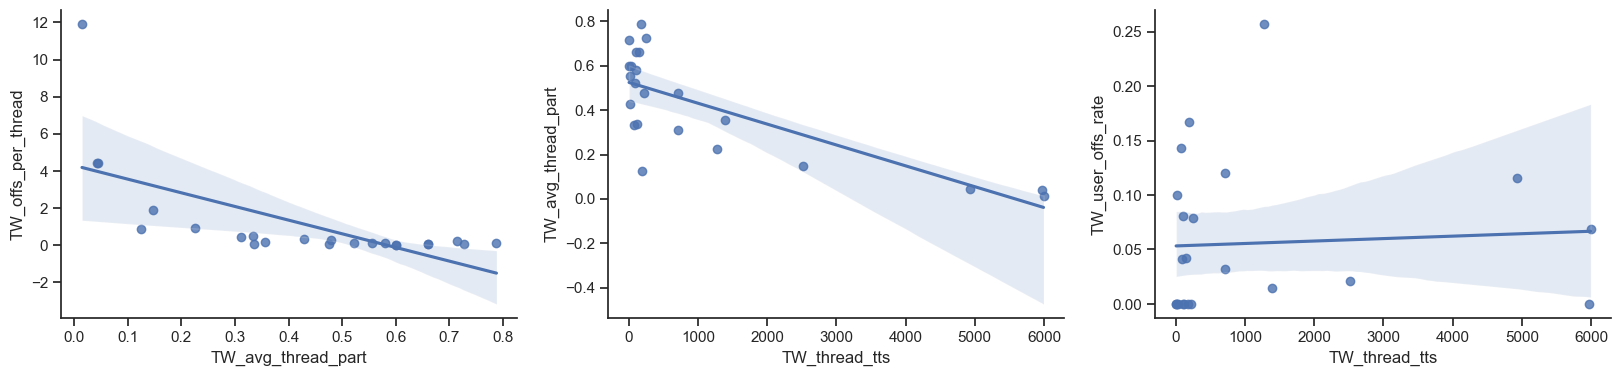

In [129]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

sns.regplot(
    data=cand_df,
    x='TW_avg_thread_part',
    y='TW_offs_per_thread',
    ax=ax[0],
)

sns.regplot(
    data=cand_df,
    x='TW_thread_tts',
    y='TW_avg_thread_part',
    ax=ax[1],
)

sns.regplot(
    data=cand_df,
    x='TW_thread_tts',
    y='TW_user_offs_rate',
    ax=ax[2],
)

O primeiro gráfico possui muitos candidatos com `TW_offs_per_thread` próximo de zero, e os poucos que possuem um valor maior tem baixo `TW_avg_thread_part`. Será que esta correlação se deve a estes valores?
Vamos dar um zoom na escala de `TW_offs_per_thread` para avaliar:

[Text(0.5, 1.0, 'Relação entre participação e quantidade de ofensas nas threads')]

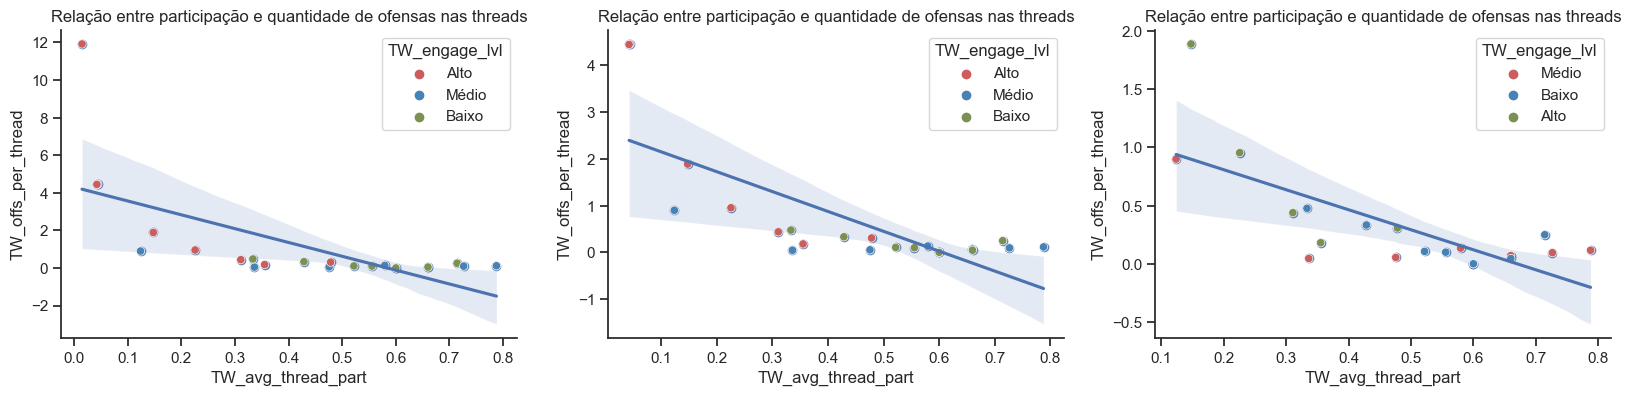

In [130]:
fig, ax = plt.subplots(1, 3, figsize=(20, 4))

_df = cand_df
sns.regplot(
    data=_df,
    x='TW_avg_thread_part',
    y='TW_offs_per_thread',
    ax=ax[0],
)
sns.scatterplot(
    data=_df,
    x='TW_avg_thread_part',
    y='TW_offs_per_thread',
    # size='TW_thread_tts',
    # sizes=(50, 200),
    hue='TW_engage_lvl',
    palette=trin_palette,
    ax=ax[0],
).set(title=f'Relação entre participação e quantidade de ofensas nas threads')


_df = cand_df[cand_df['TW_offs_per_thread'] < 10]
sns.regplot(
    data=_df,
    x='TW_avg_thread_part',
    y='TW_offs_per_thread',
    ax=ax[1],
)
sns.scatterplot(
    data=_df,
    x='TW_avg_thread_part',
    y='TW_offs_per_thread',
    # size='TW_thread_tts',
    # sizes=(50, 200),
    hue='TW_engage_lvl',
    palette=trin_palette,
    ax=ax[1],
).set(title=f'Relação entre participação e quantidade de ofensas nas threads')

_df = cand_df[cand_df['TW_offs_per_thread'] < 2]
sns.regplot(
    data=_df,
    x='TW_avg_thread_part',
    y='TW_offs_per_thread',
    ax=ax[2],
)
sns.scatterplot(
    data=_df,
    x='TW_avg_thread_part',
    y='TW_offs_per_thread',
    # size='TW_thread_tts',
    # sizes=(50, 200),
    hue='TW_engage_lvl',
    palette=trin_palette,
    ax=ax[2],
).set(title=f'Relação entre participação e quantidade de ofensas nas threads')

Mesmo se removermos os candidatos com `TW_offs_per_thread` mais altos, vemos que a correlação ainda se mantém

#### TW_avg_tt_length - TW_user_offs_rate

[Text(0.5, 1.0, 'Relação entre tamanho de tweet e taxa de ofensas entre candidatos (Corr = -0.59)')]

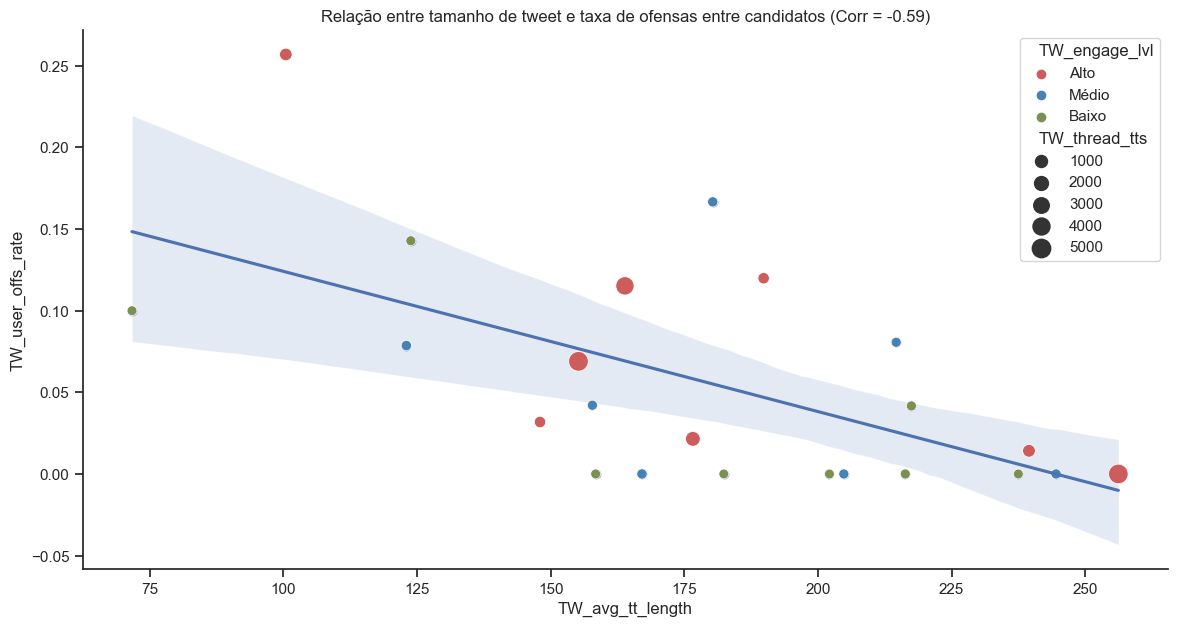

In [131]:
plt.subplots(figsize=(14, 7))
sns.regplot(
    data=cand_df,
    x='TW_avg_tt_length',
    y='TW_user_offs_rate',
    # ax=ax[1],
)
sns.scatterplot(
    data=cand_df,
    x='TW_avg_tt_length',
    y='TW_user_offs_rate',
    size='TW_thread_tts',
    sizes=(50, 200),
    hue='TW_engage_lvl',
    palette=trin_palette,
    # ax=ax[1],
).set(title=f'Relação entre tamanho de tweet e taxa de ofensas entre candidatos (Corr = -0.59)')

/tmp/ipykernel_14782/1251894043.py:13: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(


[Text(0.5, 1.0, 'Histograma de tamanho de tweet por classe')]

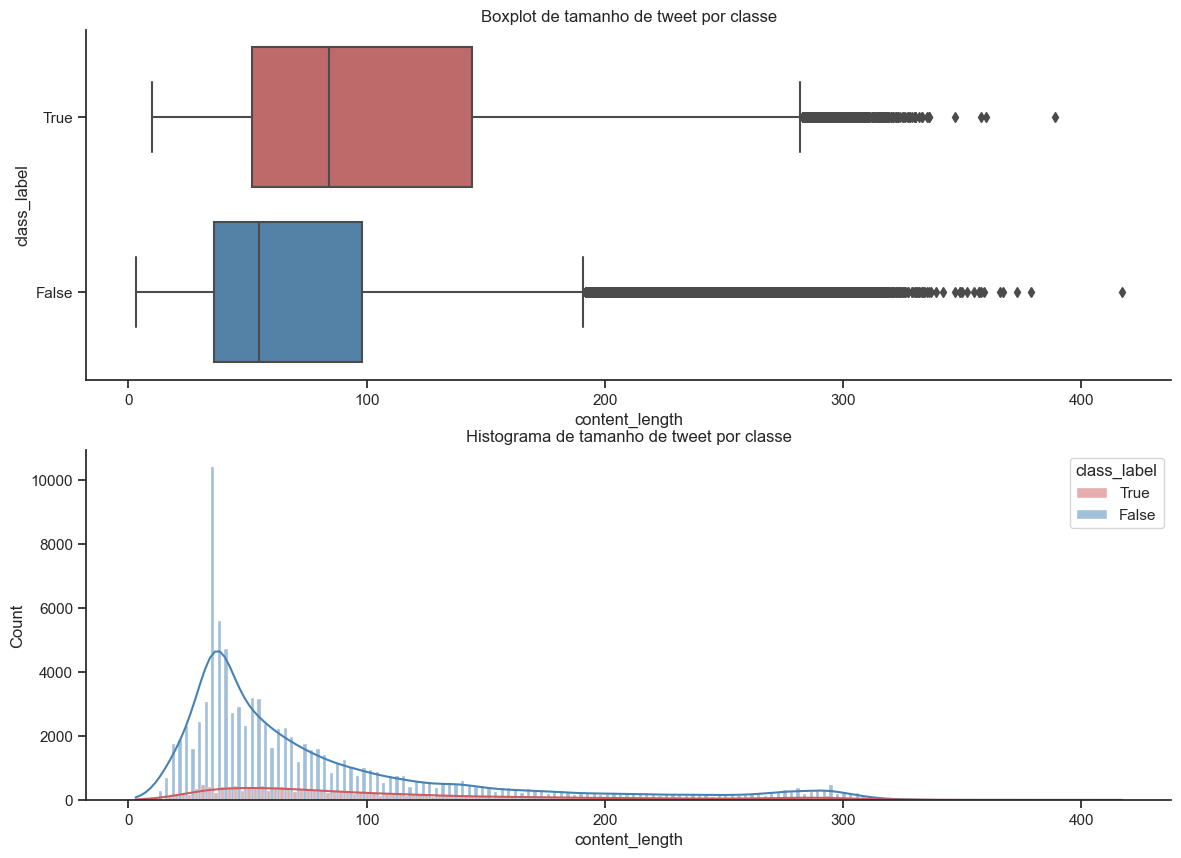

In [132]:
# Checando a distribuição do tamanho dos tweets
fig, ax = plt.subplots(2, 1, figsize=(14, 10))

sns.boxplot(
    data=df,
    x='content_length',
    y=df['class_label'].astype(str),
    palette=trin_palette,
    order=['True', 'False'],
    ax=ax[0],
).set(title="Boxplot de tamanho de tweet por classe")

sns.histplot(
    df,
    x='content_length',
    hue='class_label',
    multiple='dodge',
    kde=True,
    palette=trin_palette,
    hue_order=[True, False],
    ax=ax[1],
).set(title="Histograma de tamanho de tweet por classe")


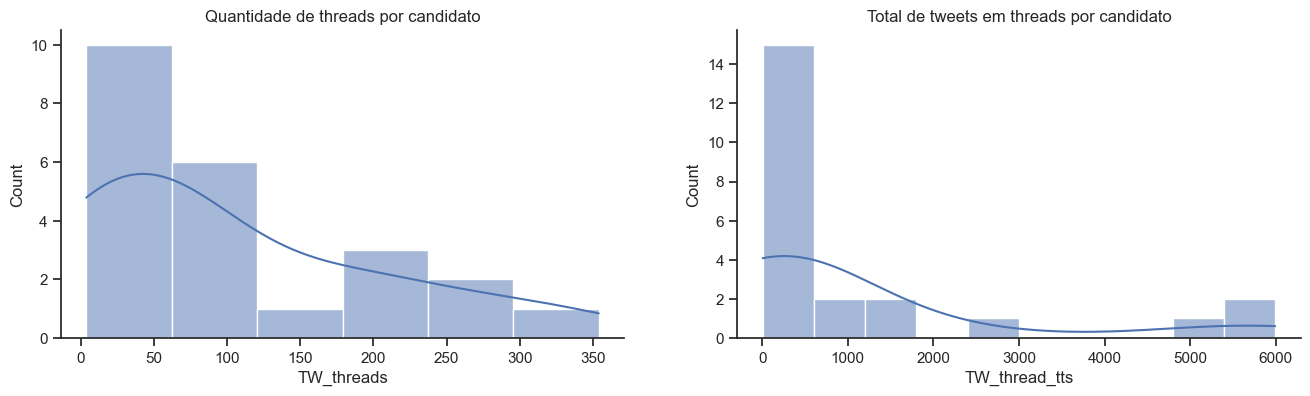

[Text(0.5, 1.0, 'Média do total de tweets por thread')]

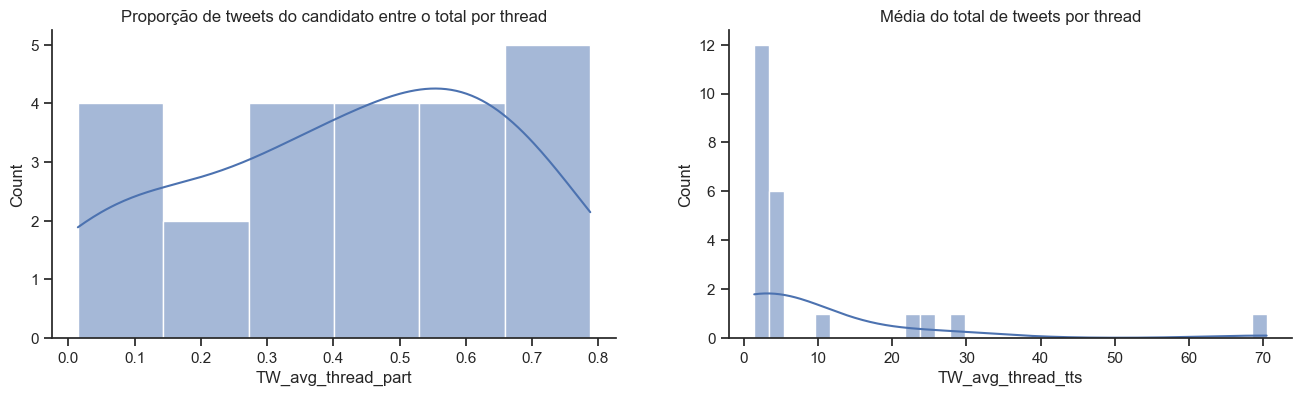

In [133]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(
    data=cand_df,
    x='TW_threads',
    # hue='class_label',
    # multiple='dodge',
    kde=True,
    # palette=trin_palette,
    # hue_order=[True, False],
    ax=ax[0],
).set(title="Quantidade de threads por candidato")

sns.histplot(
    data=cand_df,
    x='TW_thread_tts',
    # hue='class_label',
    # multiple='dodge',
    kde=True,
    # palette=trin_palette,
    # hue_order=[True, False],
    # log_scale=True,
    ax=ax[1],
).set(title="Total de tweets em threads por candidato")

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(
    data=cand_df,
    x='TW_avg_thread_part',
    # hue='class_label',
    # multiple='dodge',
    kde=True,
    # palette=trin_palette,
    # hue_order=[True, False],
    # element='poly',
    ax=ax[0],
).set(title="Proporção de tweets do candidato entre o total por thread")

sns.histplot(
    data=cand_df,
    x='TW_avg_thread_tts',
    # hue='class_label',
    # multiple='dodge',
    kde=True,
    # element='poly',
    # palette=trin_palette,
    # hue_order=[True, False],
    ax=ax[1],
).set(title="Média do total de tweets por thread")

[Text(0.5, 1.0, 'Média de tweets ofensivos por thread do candidato'),
 Text(0, 0.5, '')]

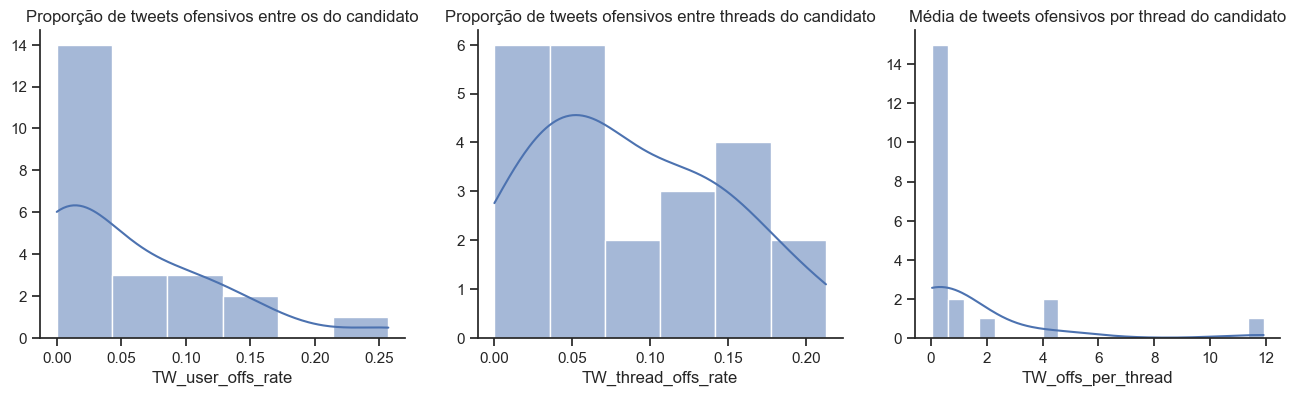

In [134]:
['TW_user_offs_rate', 'TW_thread_offs_rate', 'TW_offs_per_thread',]

fig, ax = plt.subplots(1, 3, figsize=(16, 4))

sns.histplot(
    data=cand_df,
    x='TW_user_offs_rate',
    kde=True,
    ax=ax[0],
).set(title="Proporção de tweets ofensivos entre os do candidato", ylabel=None)

sns.histplot(
    data=cand_df,
    x='TW_thread_offs_rate',
    kde=True,
    ax=ax[1],
).set(title="Proporção de tweets ofensivos entre threads do candidato", ylabel=None)

sns.histplot(
    data=cand_df[cand_df['TW_offs_per_thread'] > 0],
    x='TW_offs_per_thread',
    kde=True,
    ax=ax[2],
    # log_scale=True,
).set(title="Média de tweets ofensivos por thread do candidato", ylabel=None)

[Text(0.5, 1.0, 'Média de tweets ofensivos por thread do candidato'),
 Text(0, 0.5, '')]

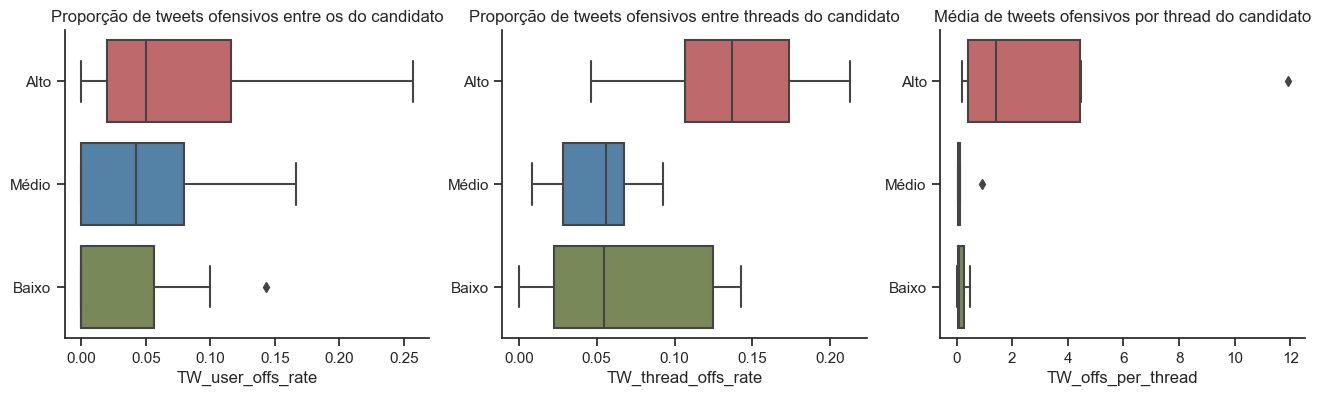

In [135]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

sns.boxplot(
    data=cand_df,
    x='TW_user_offs_rate',
    y='TW_engage_lvl',
    palette=trin_palette,
    ax=ax[0],
).set(title="Proporção de tweets ofensivos entre os do candidato", ylabel=None)

sns.boxplot(
    data=cand_df,
    x='TW_thread_offs_rate',
    y='TW_engage_lvl',
    palette=trin_palette,
    ax=ax[1],
).set(title="Proporção de tweets ofensivos entre threads do candidato", ylabel=None)

sns.boxplot(
    data=cand_df,
    x='TW_offs_per_thread',
    y='TW_engage_lvl',
    palette=trin_palette,
    ax=ax[2],
).set(title="Média de tweets ofensivos por thread do candidato", ylabel=None)

<Axes: title={'center': 'Tweets ofensivos pelo tamanho das threads'}, xlabel='TW_thread_tts', ylabel='TW_thread_offs'>

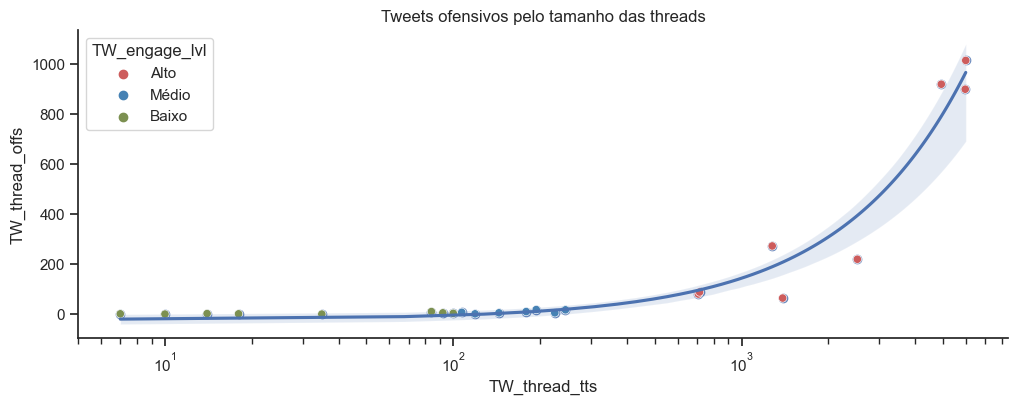

In [136]:

# f, ax = plt.subplots(1, 2, figsize=(16, 4))
# ax[0].set(xscale="log")
# ax[1].set(xscale="log")

plt.subplots(figsize=(12, 4))
sns.regplot(
    data=cand_df,
    x='TW_thread_tts',
    y='TW_thread_offs',
    # ax=ax[0],
).set(title="Tweets ofensivos pelo tamanho das threads", xscale="log")
sns.scatterplot(
    data=cand_df,
    x='TW_thread_tts',
    y='TW_thread_offs',
    hue='TW_engage_lvl',
    palette=trin_palette,
    # ax=ax[0],
)

# sns.regplot(
#     data=cand_df,
#     y='TW_offs_per_thread',
#     x='TW_avg_thread_tts',
#     ax=ax[1],
# )
# sns.scatterplot(
#     data=cand_df,
#     y='TW_offs_per_thread',
#     x='TW_avg_thread_tts',
#     hue='TW_engage_lvl',
#     palette=trin_palette,
#     ax=ax[1],
# )



/tmp/ipykernel_14782/2195517961.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(
/tmp/ipykernel_14782/2195517961.py:14: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(


[Text(0.5, 1.0, 'Média do total de tweets por thread')]

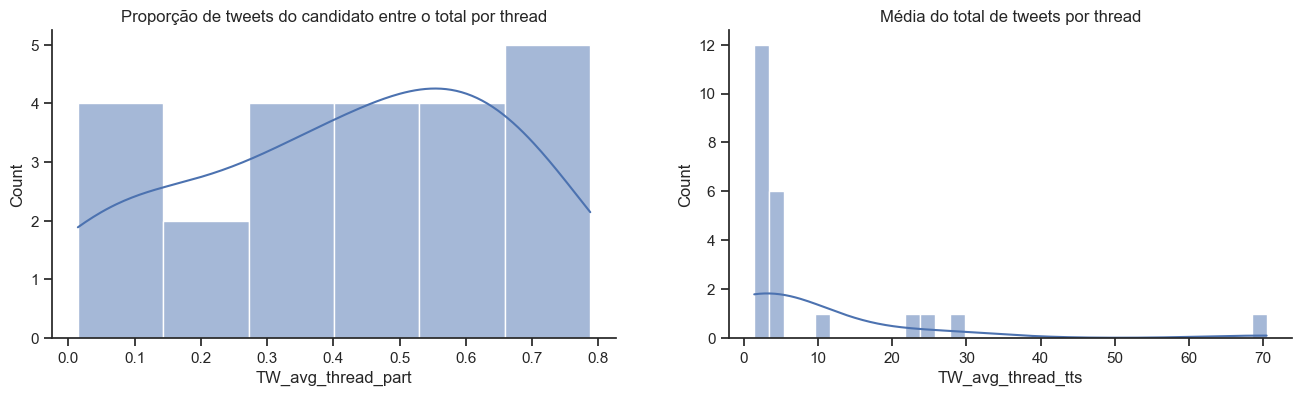

In [137]:
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

sns.histplot(
    data=cand_df,
    x='TW_avg_thread_part',
    # hue='class_label',
    # multiple='dodge',
    kde=True,
    palette=trin_palette,
    # hue_order=[True, False],
    ax=ax[0],
).set(title="Proporção de tweets do candidato entre o total por thread")

sns.histplot(
    data=cand_df,
    x='TW_avg_thread_tts',
    # hue='class_label',
    # multiple='dodge',
    kde=True,
    palette=trin_palette,
    # hue_order=[True, False],
    ax=ax[1],
).set(title="Média do total de tweets por thread")


# Gráficos para Apresentação

In [138]:
# Configurações gerais para os gráficos
plt.style.use('ggplot')
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
bin_palette = ['indianred', 'steelblue']
trin_palette = ['#CD5C5C', '#4682B4', '#7C9051']
presentation_figsize = (10, 4)

/tmp/ipykernel_14782/3082667659.py:4: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(


(array([19236., 19243., 19250., 19257., 19266., 19273., 19280., 19287.,
        19297.]),
 [Text(19236.0, 0, '2022-09-01'),
  Text(19243.0, 0, '2022-09-08'),
  Text(19250.0, 0, '2022-09-15'),
  Text(19257.0, 0, '2022-09-22'),
  Text(19266.0, 0, '2022-10-01'),
  Text(19273.0, 0, '2022-10-08'),
  Text(19280.0, 0, '2022-10-15'),
  Text(19287.0, 0, '2022-10-22'),
  Text(19297.0, 0, '2022-11-01')])

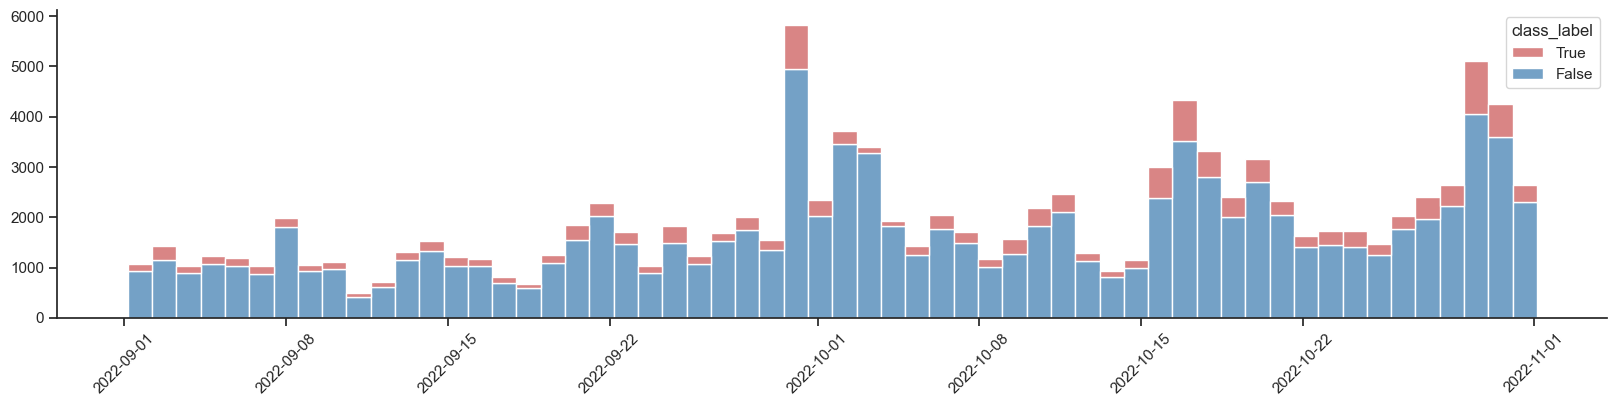

In [140]:
# Distribuição dos tweets pelo tempo, antes do tratamento dos outliers
fig, ax = plt.subplots(1, 1, figsize=figsize)

sns.histplot(
    df,
    x='date',
    hue='class_label',
    hue_order=[True, False],
    palette=trin_palette,
    multiple='stack',
    # kde=True,
    # ax=ax[0],
).set(title=None, xlabel=None, ylabel=None)
plt.xticks(rotation=45)

[[Text(0, 0, '')], Text(0, 0.5, 'Sem outliers')]

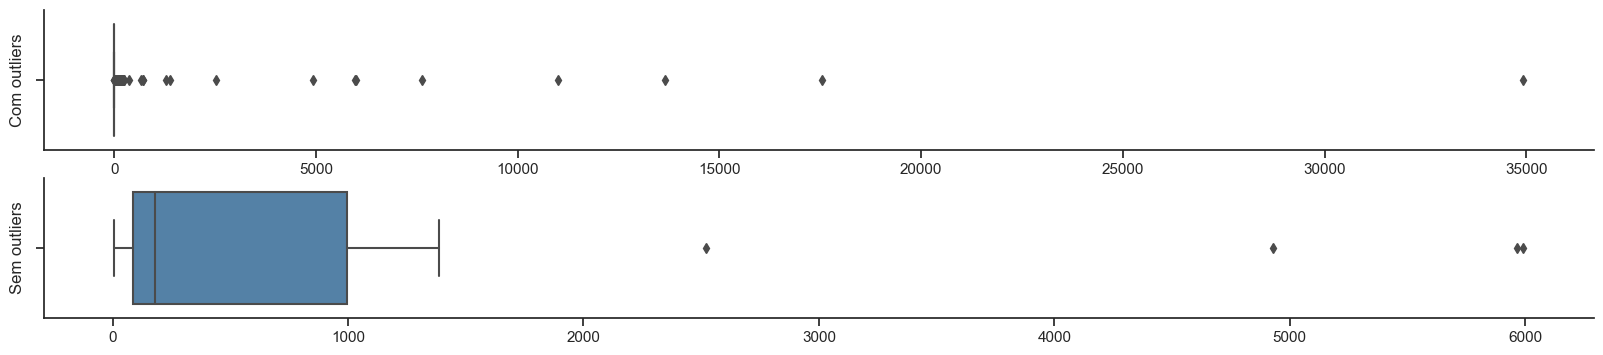

In [141]:
# Demonstração do tratamento de outliers
fig, ax = plt.subplots(2, 1, figsize=figsize)
sns.boxplot(
    raw_cand_df[['TW_thread_tts']],
    orient='h',
    color='steelblue',
    ax=ax[0],
).set(yticklabels=[], ylabel='Com outliers')
sns.boxplot(
    cand_df[['TW_thread_tts']],
    orient='h',
    color='steelblue',
    ax=ax[1],
).set(yticklabels=[], ylabel='Sem outliers')

[Text(0.5, 0, ''), Text(0, 0.5, '')]

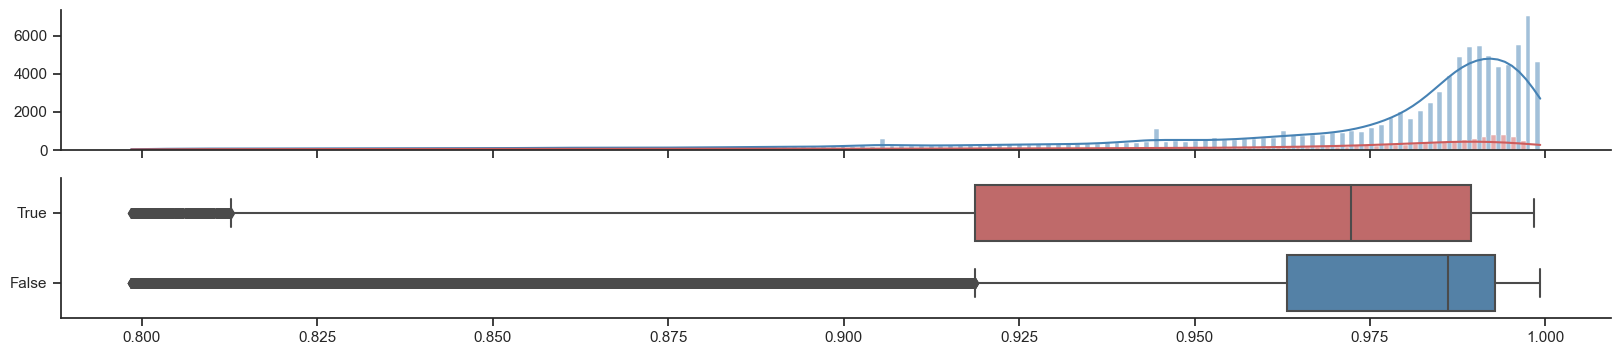

In [142]:
fig, ax = plt.subplots(2, 1, figsize=figsize)

# Score das classificações por classe
sns.histplot(
    df,
    x='class_score',
    hue='class_label',
    hue_order=[True, False],
    palette=bin_palette,
    legend=False,
    multiple='dodge',
    kde=True,
    ax=ax[0],
).set(xlabel=None, ylabel=None, xticklabels=[])

sns.boxplot(
    data=df,
    x='class_score',
    y=df['class_label'].astype(str),
    palette=bin_palette,
    order=['True', 'False'],
    ax=ax[1],
).set(xlabel=None, ylabel=None)

[Text(0, 0.5, ''), Text(0.5, 0, '')]

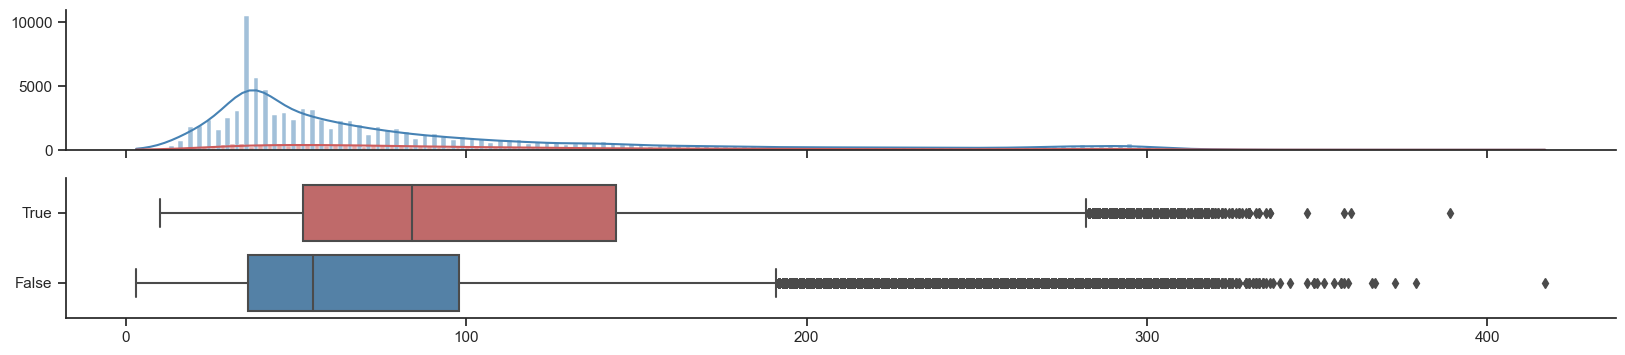

In [143]:
fig, ax = plt.subplots(2, 1, figsize=figsize)

# Tamanho de tweet por classe
sns.histplot(
    df,
    x='content_length',
    hue='class_label',
    hue_order=[True, False],
    palette=bin_palette,
    legend=False,
    multiple='dodge',
    kde=True,
    ax=ax[0],
).set(ylabel=None, xlabel=None, xticklabels=[])

sns.boxplot(
    data=df,
    x='content_length',
    y=df['class_label'].astype(str),
    palette=bin_palette,
    order=['True', 'False'],
    ax=ax[1],
).set(ylabel=None, xlabel=None)


[Text(0, 0.5, 'Tweets ofensivos / thread'),
 Text(0.5, 0, 'Total de tweets / thread'),
 None]

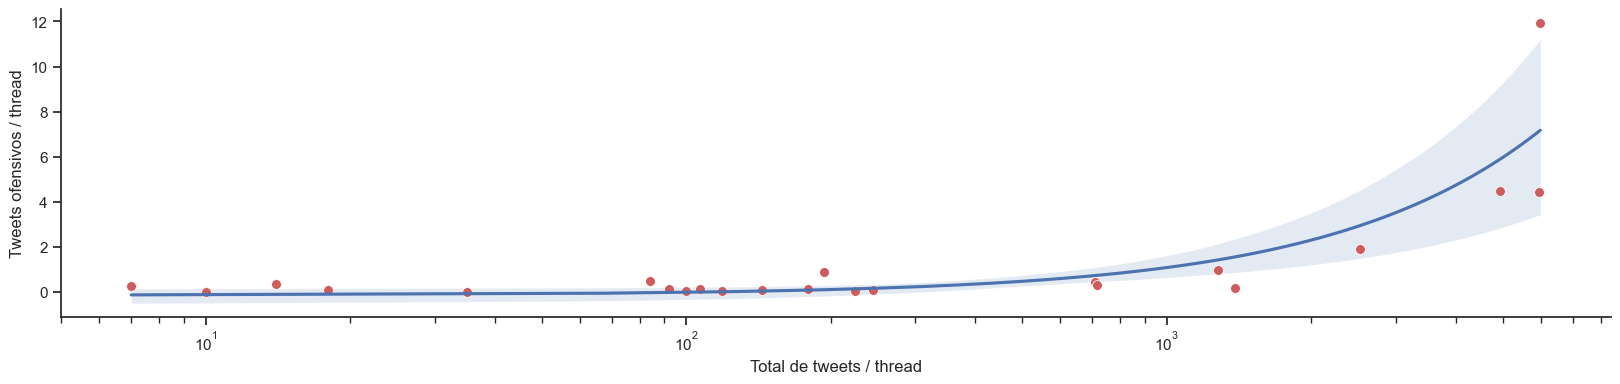

In [146]:
# DEFINIDO
fig, ax = plt.subplots(1, 1, figsize=figsize)

sns.regplot(
    data=cand_df,
    x='TW_thread_tts',
    y='TW_offs_per_thread',
    scatter_kws={'s': 0},
).set(ylabel=None, xlabel=None, xscale="log")

sns.scatterplot(
    data=cand_df,
    x='TW_thread_tts',
    y='TW_offs_per_thread',
    color='indianred',
    s=50,
).set(ylabel='Tweets ofensivos / thread', xlabel='Total de tweets / thread', xscale="log")

[Text(0, 0.5, 'Tweets ofensivos / thread'),
 Text(0.5, 0, 'Total de tweets / thread'),
 None]

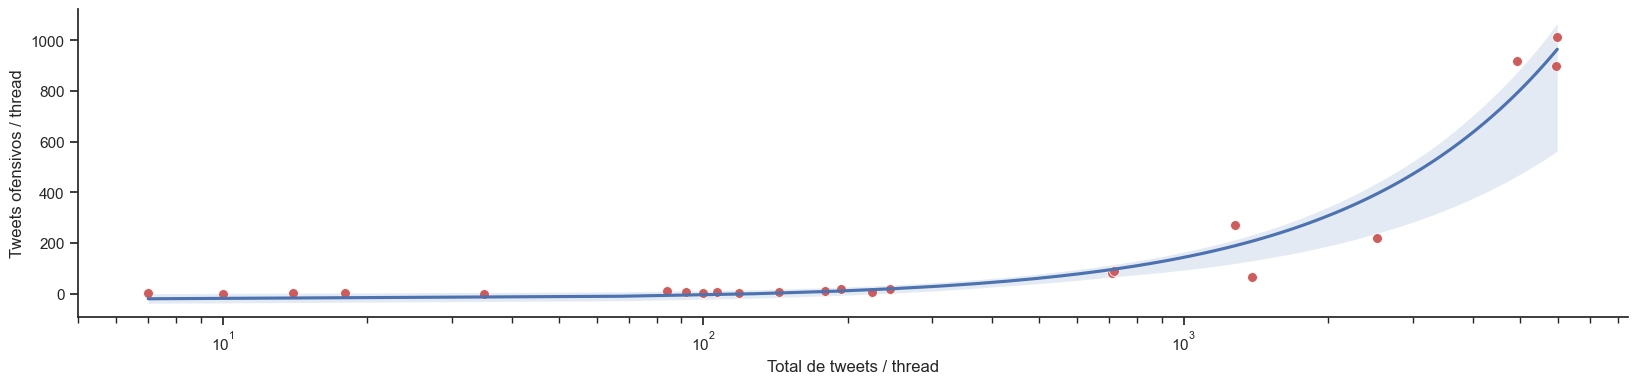

In [147]:
# DEFINIDO
fig, ax = plt.subplots(1, 1, figsize=figsize)

sns.regplot(
    data=cand_df,
    x='TW_thread_tts',
    y='TW_thread_offs',
    scatter_kws={'s': 0},
).set(ylabel=None, xlabel=None, xscale="log")

sns.scatterplot(
    data=cand_df,
    x='TW_thread_tts',
    y='TW_thread_offs',
    color='indianred',
    s=50,
).set(ylabel='Tweets ofensivos / thread', xlabel='Total de tweets / thread', xscale="log")

[Text(0, 0.5, 'Taxa de tts ofensivos'),
 Text(0.5, 0, 'Média de caracteres por tt')]

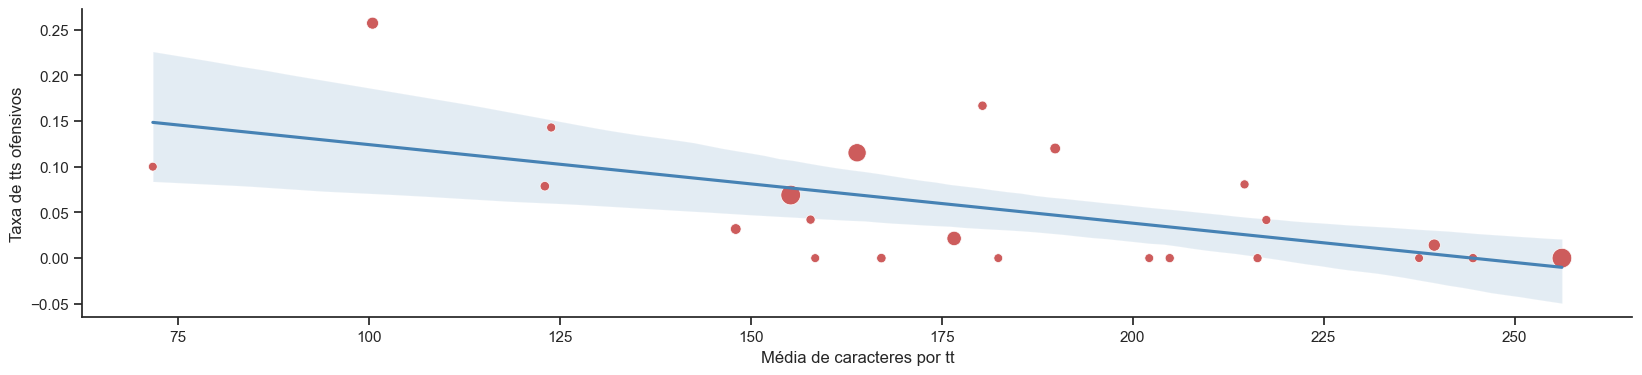

In [148]:
# Relação entre tamanho de tweet e taxa de ofensas entre candidatos (Corr = -0.59)
# Usuários com tweets maiores tendem a postar menos conteúdo ofensivo
x = 'TW_avg_tt_length'
y = 'TW_user_offs_rate'
plt.subplots(figsize=figsize)

sns.regplot(
    data=cand_df,
    x=x,
    y=y,
    scatter_kws={'s': 1},
    color='steelblue',
).set(ylabel=None, xlabel=None)

sns.scatterplot(
    data=cand_df,
    x=x,
    y=y,
    size='TW_thread_tts',
    sizes=(40, 200),
    color='indianred',
    legend=False,
).set(ylabel="Taxa de tts ofensivos", xlabel="Média de caracteres por tt")

[Text(0, 0.5, 'Tts ofensivos por thread'),
 Text(0.5, 0, 'Participação em threads')]

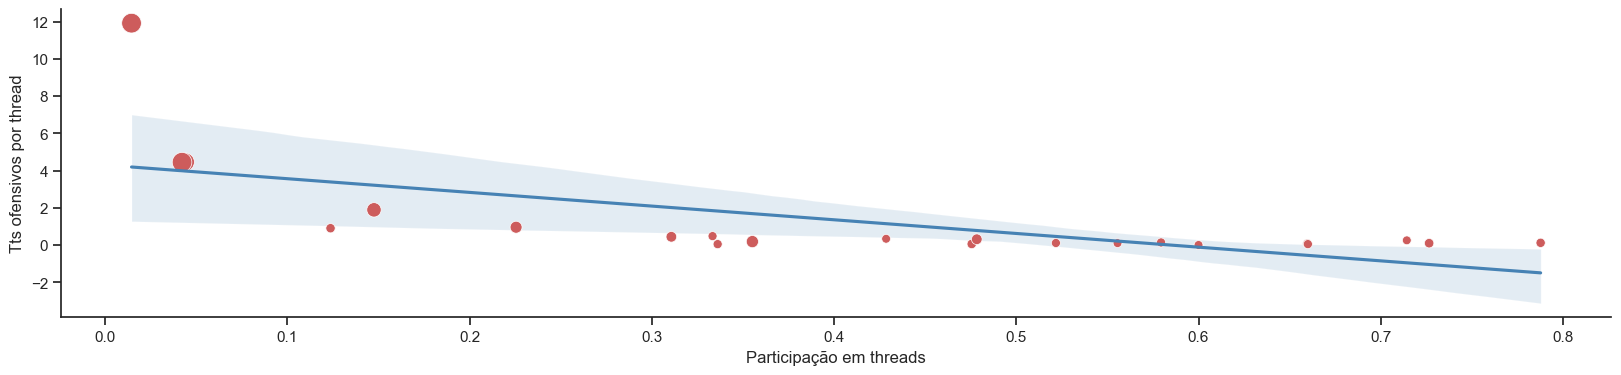

In [149]:
# Participação do candidato por Quantidade de ofensas em suas threads (Corr = -0.66)
x = 'TW_avg_thread_part'
y = 'TW_offs_per_thread'
plt.subplots(figsize=figsize)

sns.regplot(
    data=cand_df,
    x=x,
    y=y,
    scatter_kws={'s': 1},
    color='steelblue',
).set(ylabel=None, xlabel=None)

sns.scatterplot(
    data=cand_df,
    x=x,
    y=y,
    size='TW_thread_tts',
    sizes=(40, 200),
    # style='TW_engage_lvl',
    # style_order=['Baixo', 'Médio', 'Alto'],
    color='indianred',
    legend=False,
).set(ylabel="Tts ofensivos por thread", xlabel="Participação em threads")

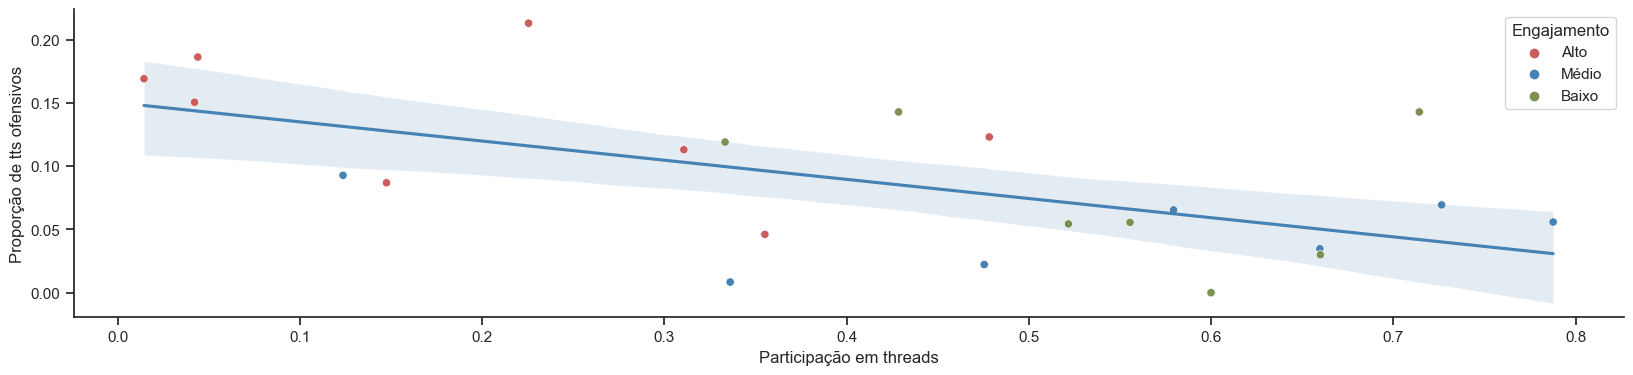

In [150]:
# Participação do candidato por Taxa de ofensas em suas threads (Corr = -0.58)
x = 'TW_avg_thread_part'
y = 'TW_thread_offs_rate'
plt.subplots(figsize=figsize)

sns.regplot(
    data=cand_df,
    x=x,
    y=y,
    scatter_kws={'s': 1},
    color='steelblue',
).set(ylabel=None, xlabel=None)

sns.scatterplot(
    data=cand_df,
    x=x,
    y=y,
    palette=trin_palette,
    hue='TW_engage_lvl',
).set(ylabel="Proporção de tts ofensivos", xlabel="Participação em threads")
plt.legend(title='Engajamento')

[Text(0.5, 0, 'Taxa de tts ofensivos'), Text(0, 0.5, '')]

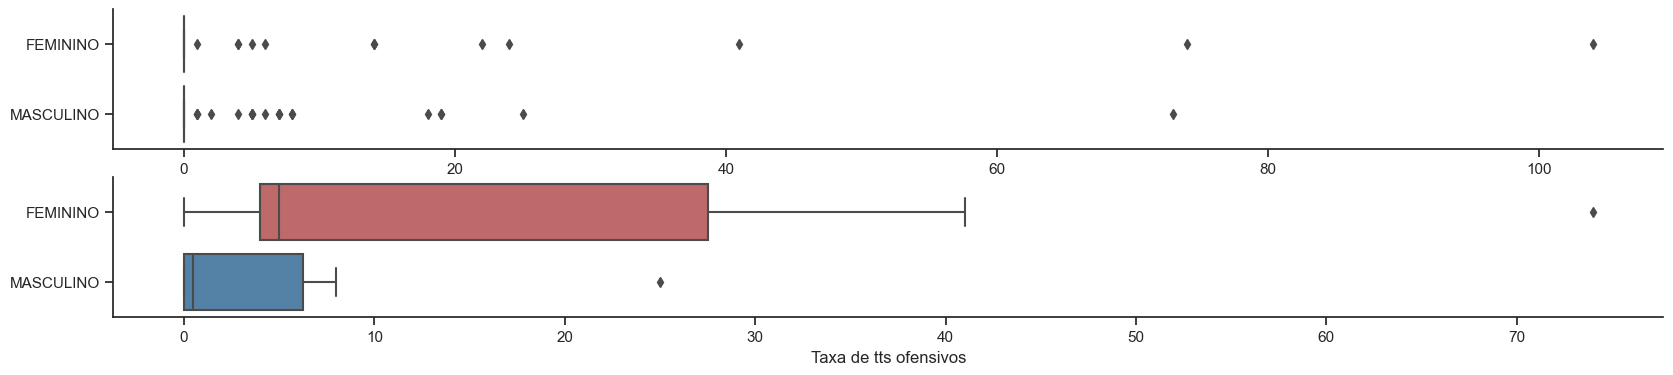

In [151]:
fig, ax = plt.subplots(2, 1, figsize=figsize)

sns.boxplot(
    data=raw_cand_df,
    x='TW_user_offs',
    y='DS_GENERO',
    order=['FEMININO', 'MASCULINO'],
    palette=trin_palette,
    ax=ax[0],
).set(xlabel='Total de tts ofensivos', ylabel=None,)

sns.boxplot(
    data=cand_df,
    x='TW_user_offs',
    y='DS_GENERO',
    order=['FEMININO', 'MASCULINO'],
    palette=trin_palette,
    ax=ax[1],
).set(xlabel='Taxa de tts ofensivos', ylabel=None, )

[Text(0.5, 0, 'Taxa de tts ofensivos'), Text(0, 0.5, '')]

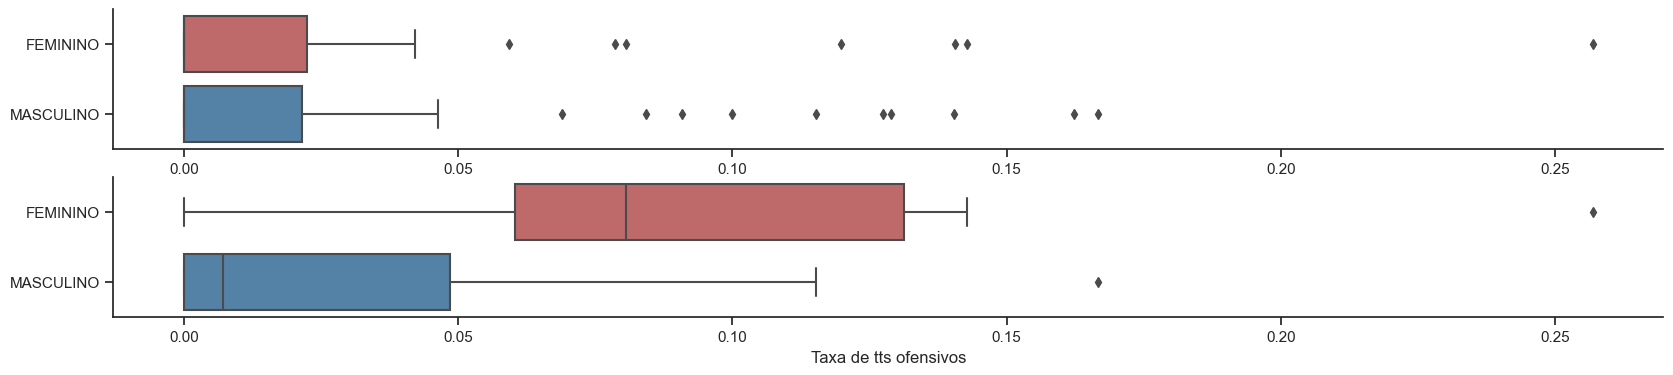

In [152]:
fig, ax = plt.subplots(2, 1, figsize=figsize)

sns.boxplot(
    data=raw_cand_df,
    x='TW_user_offs_rate',
    y='DS_GENERO',
    order=['FEMININO', 'MASCULINO'],
    palette=trin_palette,
    ax=ax[0],
).set(xlabel='Total de tts ofensivos', ylabel=None,)

sns.boxplot(
    data=cand_df,
    x='TW_user_offs_rate',
    y='DS_GENERO',
    order=['FEMININO', 'MASCULINO'],
    palette=trin_palette,
    ax=ax[1],
).set(xlabel='Taxa de tts ofensivos', ylabel=None, )